In [1]:
#fold 1

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

ModuleNotFoundError: No module named 'DWT_IDWT_Functions'

Multiple versions of MONAI may have been installed?
Please see the installation guide: https://docs.monai.io/en/stable/installation.html


In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpqe0r3jd_


In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [6]:
# data_dir = "/dataset/"
split_json = "dataset_1.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]


image shape: torch.Size([1, 296, 230, 150]), label shape: torch.Size([1, 296, 230, 150])


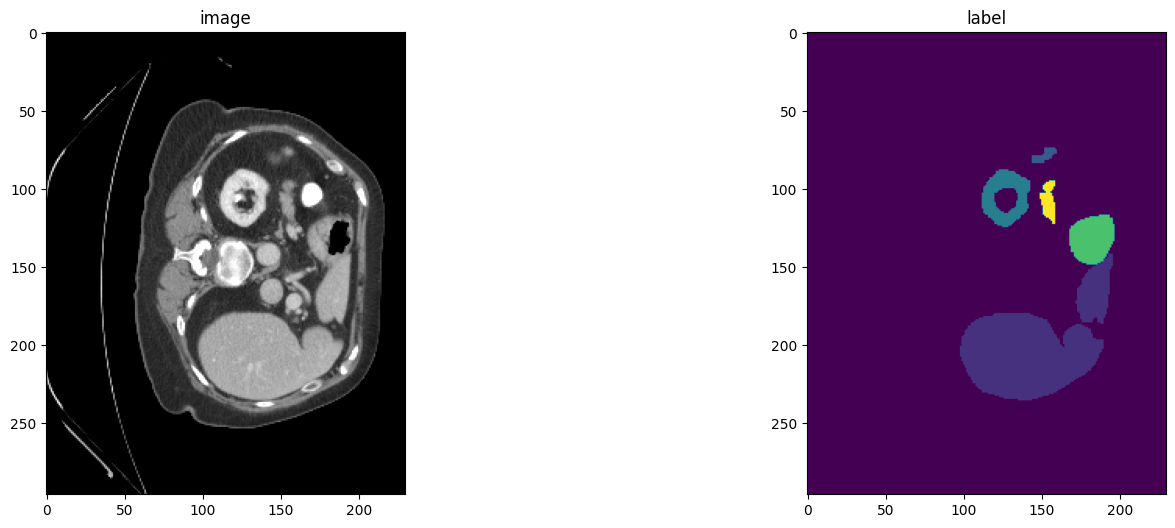

In [7]:
slice_map = {
    "img0029.nii.gz": 90,
    "img0030.nii.gz": 230,
    "img0031.nii.gz": 204,
    "img0032.nii.gz": 204,
    "img0033.nii.gz": 204,
    "img0034.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/unetr", "unetr_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.55281): 100%|█| 24/24 [00:09<00:00,  2.53it/
Training (47 / 25000 Steps) (loss=2.35540): 100%|█| 24/24 [00:07<00:00,  3.37it/
Training (71 / 25000 Steps) (loss=2.27384): 100%|█| 24/24 [00:07<00:00,  3.39it/
Training (95 / 25000 Steps) (loss=2.15873): 100%|█| 24/24 [00:07<00:00,  3.35it/
Training (119 / 25000 Steps) (loss=2.16909): 100%|█| 24/24 [00:07<00:00,  3.39it
Training (143 / 25000 Steps) (loss=2.03993): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (167 / 25000 Steps) (loss=2.14014): 100%|█| 24/24 [00:07<00:00,  3.38it
Training (191 / 25000 Steps) (loss=1.96684): 100%|█| 24/24 [00:07<00:00,  3.42it
Training (215 / 25000 Steps) (loss=1.98887): 100%|█| 24/24 [00:07<00:00,  3.34it
Training (239 / 25000 Steps) (loss=1.91554): 100%|█| 24/24 [00:07<00:00,  3.40it
Training (263 / 25000 Steps) (loss=1.93277): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (287 / 25000 Steps) (loss=1.84701): 100%|█| 24/24 [00:07<00:00,  3.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.2105124443769455 Current Avg. Dice: 0.2105124443769455


Training (503 / 25000 Steps) (loss=1.82382): 100%|█| 24/24 [00:10<00:00,  2.24it
Training (527 / 25000 Steps) (loss=1.59770): 100%|█| 24/24 [00:07<00:00,  3.28it
Training (551 / 25000 Steps) (loss=1.60625): 100%|█| 24/24 [00:07<00:00,  3.41it
Training (575 / 25000 Steps) (loss=1.76977): 100%|█| 24/24 [00:07<00:00,  3.34it
Training (599 / 25000 Steps) (loss=1.74669): 100%|█| 24/24 [00:07<00:00,  3.39it
Training (623 / 25000 Steps) (loss=1.62296): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (647 / 25000 Steps) (loss=1.59277): 100%|█| 24/24 [00:07<00:00,  3.32it
Training (671 / 25000 Steps) (loss=1.58234): 100%|█| 24/24 [00:07<00:00,  3.37it
Training (695 / 25000 Steps) (loss=1.80207): 100%|█| 24/24 [00:07<00:00,  3.36it
Training (719 / 25000 Steps) (loss=1.50963): 100%|█| 24/24 [00:07<00:00,  3.40it
Training (743 / 25000 Steps) (loss=1.57102): 100%|█| 24/24 [00:07<00:00,  3.38it
Training (767 / 25000 Steps) (loss=1.59977): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.2266308069229126 Current Avg. Dice: 0.2266308069229126


Training (1007 / 25000 Steps) (loss=1.33053): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (1031 / 25000 Steps) (loss=1.31296): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1055 / 25000 Steps) (loss=1.28282): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1079 / 25000 Steps) (loss=1.37916): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (1103 / 25000 Steps) (loss=1.44033): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (1127 / 25000 Steps) (loss=1.36525): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (1151 / 25000 Steps) (loss=1.37786): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1175 / 25000 Steps) (loss=1.49569): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1199 / 25000 Steps) (loss=1.20355): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1223 / 25000 Steps) (loss=1.20884): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1247 / 25000 Steps) (loss=1.23885): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1271 / 25000 Steps) (loss=1.75137): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.27302470803260803 Current Avg. Dice: 0.27302470803260803


Training (1511 / 25000 Steps) (loss=1.36073): 100%|█| 24/24 [00:10<00:00,  2.22i
Training (1535 / 25000 Steps) (loss=1.21979): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1559 / 25000 Steps) (loss=1.20119): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1583 / 25000 Steps) (loss=1.24924): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1607 / 25000 Steps) (loss=1.15918): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1631 / 25000 Steps) (loss=1.19169): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (1655 / 25000 Steps) (loss=1.23388): 100%|█| 24/24 [00:07<00:00,  3.43i
Training (1679 / 25000 Steps) (loss=1.24772): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (1703 / 25000 Steps) (loss=1.08123): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1727 / 25000 Steps) (loss=1.08413): 100%|█| 24/24 [00:07<00:00,  3.22i
Training (1751 / 25000 Steps) (loss=1.16334): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (1775 / 25000 Steps) (loss=1.22738): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.32221847772598267 Current Avg. Dice: 0.32221847772598267


Training (2015 / 25000 Steps) (loss=1.24940): 100%|█| 24/24 [00:11<00:00,  2.18i
Training (2039 / 25000 Steps) (loss=1.03289): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (2063 / 25000 Steps) (loss=1.04540): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (2087 / 25000 Steps) (loss=1.05561): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2111 / 25000 Steps) (loss=1.00799): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (2135 / 25000 Steps) (loss=1.11574): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (2159 / 25000 Steps) (loss=1.28653): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2183 / 25000 Steps) (loss=1.02377): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2207 / 25000 Steps) (loss=1.04009): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2231 / 25000 Steps) (loss=1.08269): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (2255 / 25000 Steps) (loss=1.12556): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (2279 / 25000 Steps) (loss=1.19726): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.38300347328186035 Current Avg. Dice: 0.38300347328186035


Training (2519 / 25000 Steps) (loss=1.06389): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (2543 / 25000 Steps) (loss=1.13884): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (2567 / 25000 Steps) (loss=1.26945): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (2591 / 25000 Steps) (loss=1.17390): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (2615 / 25000 Steps) (loss=0.97864): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2639 / 25000 Steps) (loss=1.01019): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (2663 / 25000 Steps) (loss=1.00707): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (2687 / 25000 Steps) (loss=1.09680): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (2711 / 25000 Steps) (loss=0.96095): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2735 / 25000 Steps) (loss=1.05734): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (2759 / 25000 Steps) (loss=1.16518): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (2783 / 25000 Steps) (loss=1.09397): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.46878862380981445 Current Avg. Dice: 0.46878862380981445


Training (3023 / 25000 Steps) (loss=1.00372): 100%|█| 24/24 [00:11<00:00,  2.18i
Training (3047 / 25000 Steps) (loss=1.04912): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3071 / 25000 Steps) (loss=0.99912): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3095 / 25000 Steps) (loss=1.02220): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3119 / 25000 Steps) (loss=1.03266): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3143 / 25000 Steps) (loss=1.46579): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3167 / 25000 Steps) (loss=0.97672): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3191 / 25000 Steps) (loss=1.07480): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3215 / 25000 Steps) (loss=0.93781): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3239 / 25000 Steps) (loss=0.93461): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3263 / 25000 Steps) (loss=1.00428): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (3287 / 25000 Steps) (loss=1.10387): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48213067650794983 Current Avg. Dice: 0.48213067650794983


Training (3503 / 25000 Steps) (loss=0.95075): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (3527 / 25000 Steps) (loss=0.92870): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (3551 / 25000 Steps) (loss=0.95081): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (3575 / 25000 Steps) (loss=0.97556): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (3599 / 25000 Steps) (loss=0.91231): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (3623 / 25000 Steps) (loss=1.27329): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (3647 / 25000 Steps) (loss=0.95338): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3671 / 25000 Steps) (loss=0.98872): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (3695 / 25000 Steps) (loss=0.96523): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3719 / 25000 Steps) (loss=1.00704): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (3743 / 25000 Steps) (loss=0.93924): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (3767 / 25000 Steps) (loss=0.91300): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4988107979297638 Current Avg. Dice: 0.4988107979297638


Training (4007 / 25000 Steps) (loss=1.02773): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (4031 / 25000 Steps) (loss=0.94113): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4055 / 25000 Steps) (loss=1.01334): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4079 / 25000 Steps) (loss=0.93135): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (4103 / 25000 Steps) (loss=0.98565): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4127 / 25000 Steps) (loss=0.93708): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (4151 / 25000 Steps) (loss=1.03463): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4175 / 25000 Steps) (loss=1.00238): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (4199 / 25000 Steps) (loss=0.90601): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4223 / 25000 Steps) (loss=0.89606): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4247 / 25000 Steps) (loss=0.85049): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4271 / 25000 Steps) (loss=0.93930): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5184574723243713 Current Avg. Dice: 0.5184574723243713


Training (4511 / 25000 Steps) (loss=0.91980): 100%|█| 24/24 [00:10<00:00,  2.22i
Training (4535 / 25000 Steps) (loss=0.88425): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (4559 / 25000 Steps) (loss=0.89559): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (4583 / 25000 Steps) (loss=0.97145): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4607 / 25000 Steps) (loss=0.86963): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (4631 / 25000 Steps) (loss=0.94060): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (4655 / 25000 Steps) (loss=1.02032): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (4679 / 25000 Steps) (loss=0.97674): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4703 / 25000 Steps) (loss=0.95403): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (4727 / 25000 Steps) (loss=0.91368): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (4751 / 25000 Steps) (loss=0.98886): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (4775 / 25000 Steps) (loss=1.06492): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5224751830101013 Current Avg. Dice: 0.5224751830101013


Training (5015 / 25000 Steps) (loss=0.94275): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (5039 / 25000 Steps) (loss=0.88483): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (5063 / 25000 Steps) (loss=0.87277): 100%|█| 24/24 [00:07<00:00,  3.22i
Training (5087 / 25000 Steps) (loss=1.10773): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (5111 / 25000 Steps) (loss=0.88841): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (5135 / 25000 Steps) (loss=0.95072): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5159 / 25000 Steps) (loss=0.84077): 100%|█| 24/24 [00:07<00:00,  3.22i
Training (5183 / 25000 Steps) (loss=0.87757): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (5207 / 25000 Steps) (loss=0.99473): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5231 / 25000 Steps) (loss=0.92793): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (5255 / 25000 Steps) (loss=0.89243): 100%|█| 24/24 [00:07<00:00,  3.25i
Training (5279 / 25000 Steps) (loss=0.88910): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5224751830101013 Current Avg. Dice: 0.5002531409263611


Training (5519 / 25000 Steps) (loss=0.91273): 100%|█| 24/24 [00:10<00:00,  2.29i
Training (5543 / 25000 Steps) (loss=0.92377): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5567 / 25000 Steps) (loss=0.92915): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5591 / 25000 Steps) (loss=0.81008): 100%|█| 24/24 [00:07<00:00,  3.43i
Training (5615 / 25000 Steps) (loss=0.85921): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (5639 / 25000 Steps) (loss=1.00695): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (5663 / 25000 Steps) (loss=0.83461): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (5687 / 25000 Steps) (loss=0.86120): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (5711 / 25000 Steps) (loss=0.87190): 100%|█| 24/24 [00:06<00:00,  3.47i
Training (5735 / 25000 Steps) (loss=0.94438): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (5759 / 25000 Steps) (loss=0.90255): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (5783 / 25000 Steps) (loss=0.89241): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5273088812828064 Current Avg. Dice: 0.5273088812828064


Training (6023 / 25000 Steps) (loss=0.96162): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (6047 / 25000 Steps) (loss=0.80580): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6071 / 25000 Steps) (loss=0.89913): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (6095 / 25000 Steps) (loss=0.86850): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (6119 / 25000 Steps) (loss=0.82193): 100%|█| 24/24 [00:07<00:00,  3.43i
Training (6143 / 25000 Steps) (loss=0.83388): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (6167 / 25000 Steps) (loss=1.02003): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (6191 / 25000 Steps) (loss=0.90334): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (6215 / 25000 Steps) (loss=0.77586): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6239 / 25000 Steps) (loss=0.84572): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (6263 / 25000 Steps) (loss=0.82642): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (6287 / 25000 Steps) (loss=0.84854): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5325375199317932 Current Avg. Dice: 0.5325375199317932


Training (6503 / 25000 Steps) (loss=0.78844): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (6527 / 25000 Steps) (loss=0.88597): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6551 / 25000 Steps) (loss=0.89433): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (6575 / 25000 Steps) (loss=0.79731): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6599 / 25000 Steps) (loss=0.89413): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (6623 / 25000 Steps) (loss=0.77884): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6647 / 25000 Steps) (loss=0.96525): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (6671 / 25000 Steps) (loss=0.77833): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (6695 / 25000 Steps) (loss=0.75196): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (6719 / 25000 Steps) (loss=0.80290): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (6743 / 25000 Steps) (loss=0.85183): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (6767 / 25000 Steps) (loss=0.85815): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5325375199317932 Current Avg. Dice: 0.5051192045211792


Training (7007 / 25000 Steps) (loss=0.89371): 100%|█| 24/24 [00:10<00:00,  2.32i
Training (7031 / 25000 Steps) (loss=0.81568): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (7055 / 25000 Steps) (loss=0.91417): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7079 / 25000 Steps) (loss=0.77295): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (7103 / 25000 Steps) (loss=0.79922): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (7127 / 25000 Steps) (loss=0.82801): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7151 / 25000 Steps) (loss=0.87869): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7175 / 25000 Steps) (loss=1.03091): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7199 / 25000 Steps) (loss=0.79212): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (7223 / 25000 Steps) (loss=0.81705): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (7247 / 25000 Steps) (loss=0.76884): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7271 / 25000 Steps) (loss=0.91028): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6314902305603027 Current Avg. Dice: 0.6314902305603027


Training (7511 / 25000 Steps) (loss=0.83549): 100%|█| 24/24 [00:10<00:00,  2.22i
Training (7535 / 25000 Steps) (loss=0.83454): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (7559 / 25000 Steps) (loss=0.80604): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (7583 / 25000 Steps) (loss=0.79828): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (7607 / 25000 Steps) (loss=0.82742): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7631 / 25000 Steps) (loss=0.77966): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (7655 / 25000 Steps) (loss=0.78217): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7679 / 25000 Steps) (loss=1.05688): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (7703 / 25000 Steps) (loss=0.88592): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7727 / 25000 Steps) (loss=0.84505): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (7751 / 25000 Steps) (loss=0.85307): 100%|█| 24/24 [00:07<00:00,  3.25i
Training (7775 / 25000 Steps) (loss=0.78223): 100%|█| 24/24 [00:06<00:00,  3.48i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6681725382804871 Current Avg. Dice: 0.6681725382804871


Training (8015 / 25000 Steps) (loss=0.69047): 100%|█| 24/24 [00:10<00:00,  2.25i
Training (8039 / 25000 Steps) (loss=0.81629): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8063 / 25000 Steps) (loss=0.85363): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8087 / 25000 Steps) (loss=0.74520): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (8111 / 25000 Steps) (loss=0.75126): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8135 / 25000 Steps) (loss=0.76092): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (8159 / 25000 Steps) (loss=0.88361): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8183 / 25000 Steps) (loss=0.69124): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8207 / 25000 Steps) (loss=0.73516): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8231 / 25000 Steps) (loss=0.88526): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (8255 / 25000 Steps) (loss=0.73941): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (8279 / 25000 Steps) (loss=0.68271): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7023751139640808 Current Avg. Dice: 0.7023751139640808


Training (8519 / 25000 Steps) (loss=0.68411): 100%|█| 24/24 [00:10<00:00,  2.19i
Training (8543 / 25000 Steps) (loss=1.00504): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (8567 / 25000 Steps) (loss=0.77531): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (8591 / 25000 Steps) (loss=0.70202): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (8615 / 25000 Steps) (loss=0.71093): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8639 / 25000 Steps) (loss=0.77001): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8663 / 25000 Steps) (loss=0.92703): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (8687 / 25000 Steps) (loss=0.71155): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8711 / 25000 Steps) (loss=1.14436): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8735 / 25000 Steps) (loss=0.99301): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (8759 / 25000 Steps) (loss=0.73511): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8783 / 25000 Steps) (loss=0.81123): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7940191626548767 Current Avg. Dice: 0.7940191626548767


Training (9023 / 25000 Steps) (loss=0.78451): 100%|█| 24/24 [00:10<00:00,  2.26i
Training (9047 / 25000 Steps) (loss=0.84621): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9071 / 25000 Steps) (loss=0.65534): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9095 / 25000 Steps) (loss=0.68299): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9119 / 25000 Steps) (loss=0.77530): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9143 / 25000 Steps) (loss=0.81767): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9167 / 25000 Steps) (loss=0.80581): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (9191 / 25000 Steps) (loss=0.92301): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9215 / 25000 Steps) (loss=0.73766): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9239 / 25000 Steps) (loss=0.89244): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (9263 / 25000 Steps) (loss=0.70004): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (9287 / 25000 Steps) (loss=0.72958): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7940191626548767 Current Avg. Dice: 0.7870512008666992


Training (9503 / 25000 Steps) (loss=0.86379): 100%|█| 24/24 [00:10<00:00,  2.29i
Training (9527 / 25000 Steps) (loss=0.63792): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9551 / 25000 Steps) (loss=0.64762): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9575 / 25000 Steps) (loss=0.77040): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (9599 / 25000 Steps) (loss=1.24426): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9623 / 25000 Steps) (loss=0.74510): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9647 / 25000 Steps) (loss=0.74378): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (9671 / 25000 Steps) (loss=1.01286): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (9695 / 25000 Steps) (loss=0.71311): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (9719 / 25000 Steps) (loss=0.76535): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (9743 / 25000 Steps) (loss=0.82858): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (9767 / 25000 Steps) (loss=0.54699): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7998571395874023 Current Avg. Dice: 0.7998571395874023


Training (10007 / 25000 Steps) (loss=0.83809): 100%|█| 24/24 [00:10<00:00,  2.19
Training (10031 / 25000 Steps) (loss=0.56466): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10055 / 25000 Steps) (loss=0.83916): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10079 / 25000 Steps) (loss=0.81836): 100%|█| 24/24 [00:07<00:00,  3.35
Training (10103 / 25000 Steps) (loss=0.89131): 100%|█| 24/24 [00:07<00:00,  3.40
Training (10127 / 25000 Steps) (loss=0.91013): 100%|█| 24/24 [00:07<00:00,  3.40
Training (10151 / 25000 Steps) (loss=0.75107): 100%|█| 24/24 [00:07<00:00,  3.28
Training (10175 / 25000 Steps) (loss=0.80510): 100%|█| 24/24 [00:07<00:00,  3.31
Training (10199 / 25000 Steps) (loss=0.78488): 100%|█| 24/24 [00:06<00:00,  3.43
Training (10223 / 25000 Steps) (loss=0.69526): 100%|█| 24/24 [00:06<00:00,  3.43
Training (10247 / 25000 Steps) (loss=0.64500): 100%|█| 24/24 [00:07<00:00,  3.40
Training (10271 / 25000 Steps) (loss=0.62227): 100%|█| 24/24 [00:07<00:00,  3.42
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7998571395874023 Current Avg. Dice: 0.798631489276886


Training (10511 / 25000 Steps) (loss=0.76846): 100%|█| 24/24 [00:10<00:00,  2.30
Training (10535 / 25000 Steps) (loss=0.78240): 100%|█| 24/24 [00:07<00:00,  3.27
Training (10559 / 25000 Steps) (loss=0.73910): 100%|█| 24/24 [00:07<00:00,  3.30
Training (10583 / 25000 Steps) (loss=0.62189): 100%|█| 24/24 [00:07<00:00,  3.32
Training (10607 / 25000 Steps) (loss=0.72200): 100%|█| 24/24 [00:07<00:00,  3.35
Training (10631 / 25000 Steps) (loss=0.74489): 100%|█| 24/24 [00:07<00:00,  3.23
Training (10655 / 25000 Steps) (loss=0.69936): 100%|█| 24/24 [00:07<00:00,  3.43
Training (10679 / 25000 Steps) (loss=0.71651): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10703 / 25000 Steps) (loss=0.65668): 100%|█| 24/24 [00:07<00:00,  3.30
Training (10727 / 25000 Steps) (loss=0.74698): 100%|█| 24/24 [00:07<00:00,  3.20
Training (10751 / 25000 Steps) (loss=0.69495): 100%|█| 24/24 [00:07<00:00,  3.42
Training (10775 / 25000 Steps) (loss=0.99905): 100%|█| 24/24 [00:07<00:00,  3.36
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7998571395874023 Current Avg. Dice: 0.7930000424385071


Training (11015 / 25000 Steps) (loss=0.62442): 100%|█| 24/24 [00:10<00:00,  2.26
Training (11039 / 25000 Steps) (loss=0.63889): 100%|█| 24/24 [00:07<00:00,  3.34
Training (11063 / 25000 Steps) (loss=0.79817): 100%|█| 24/24 [00:07<00:00,  3.41
Training (11087 / 25000 Steps) (loss=0.65444): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11111 / 25000 Steps) (loss=0.76375): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11135 / 25000 Steps) (loss=0.52821): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11159 / 25000 Steps) (loss=0.59473): 100%|█| 24/24 [00:07<00:00,  3.40
Training (11183 / 25000 Steps) (loss=1.11573): 100%|█| 24/24 [00:07<00:00,  3.38
Training (11207 / 25000 Steps) (loss=1.01925): 100%|█| 24/24 [00:07<00:00,  3.40
Training (11231 / 25000 Steps) (loss=0.72037): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11255 / 25000 Steps) (loss=0.70304): 100%|█| 24/24 [00:06<00:00,  3.46
Training (11279 / 25000 Steps) (loss=0.75354): 100%|█| 24/24 [00:07<00:00,  3.34
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7998571395874023 Current Avg. Dice: 0.7988566756248474


Training (11519 / 25000 Steps) (loss=0.67643): 100%|█| 24/24 [00:10<00:00,  2.31
Training (11543 / 25000 Steps) (loss=0.58548): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11567 / 25000 Steps) (loss=0.73832): 100%|█| 24/24 [00:07<00:00,  3.32
Training (11591 / 25000 Steps) (loss=0.84558): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11615 / 25000 Steps) (loss=0.65912): 100%|█| 24/24 [00:07<00:00,  3.34
Training (11639 / 25000 Steps) (loss=0.82738): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11663 / 25000 Steps) (loss=0.79716): 100%|█| 24/24 [00:07<00:00,  3.40
Training (11687 / 25000 Steps) (loss=0.77342): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11711 / 25000 Steps) (loss=0.72928): 100%|█| 24/24 [00:07<00:00,  3.32
Training (11735 / 25000 Steps) (loss=0.53975): 100%|█| 24/24 [00:07<00:00,  3.29
Training (11759 / 25000 Steps) (loss=0.91248): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11783 / 25000 Steps) (loss=0.66709): 100%|█| 24/24 [00:07<00:00,  3.38
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8174565434455872


Training (12023 / 25000 Steps) (loss=0.79206): 100%|█| 24/24 [00:11<00:00,  2.18
Training (12047 / 25000 Steps) (loss=0.64678): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12071 / 25000 Steps) (loss=0.72375): 100%|█| 24/24 [00:07<00:00,  3.30
Training (12095 / 25000 Steps) (loss=0.74562): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12119 / 25000 Steps) (loss=0.58396): 100%|█| 24/24 [00:07<00:00,  3.38
Training (12143 / 25000 Steps) (loss=0.65554): 100%|█| 24/24 [00:07<00:00,  3.30
Training (12167 / 25000 Steps) (loss=0.69324): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12191 / 25000 Steps) (loss=0.68581): 100%|█| 24/24 [00:07<00:00,  3.41
Training (12215 / 25000 Steps) (loss=0.78145): 100%|█| 24/24 [00:07<00:00,  3.37
Training (12239 / 25000 Steps) (loss=0.67461): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12263 / 25000 Steps) (loss=0.65353): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12287 / 25000 Steps) (loss=0.75613): 100%|█| 24/24 [00:07<00:00,  3.32
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8134042620658875


Training (12503 / 25000 Steps) (loss=0.69799): 100%|█| 24/24 [00:10<00:00,  2.29
Training (12527 / 25000 Steps) (loss=0.56478): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12551 / 25000 Steps) (loss=0.85463): 100%|█| 24/24 [00:07<00:00,  3.26
Training (12575 / 25000 Steps) (loss=0.64409): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12599 / 25000 Steps) (loss=0.79247): 100%|█| 24/24 [00:07<00:00,  3.25
Training (12623 / 25000 Steps) (loss=0.60449): 100%|█| 24/24 [00:07<00:00,  3.30
Training (12647 / 25000 Steps) (loss=0.67530): 100%|█| 24/24 [00:07<00:00,  3.38
Training (12671 / 25000 Steps) (loss=0.69633): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12695 / 25000 Steps) (loss=0.83541): 100%|█| 24/24 [00:07<00:00,  3.43
Training (12719 / 25000 Steps) (loss=0.79522): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12743 / 25000 Steps) (loss=0.59258): 100%|█| 24/24 [00:07<00:00,  3.37
Training (12767 / 25000 Steps) (loss=0.73581): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.7952063679695129


Training (13007 / 25000 Steps) (loss=0.66577): 100%|█| 24/24 [00:10<00:00,  2.30
Training (13031 / 25000 Steps) (loss=0.74249): 100%|█| 24/24 [00:07<00:00,  3.31
Training (13055 / 25000 Steps) (loss=0.65863): 100%|█| 24/24 [00:07<00:00,  3.36
Training (13079 / 25000 Steps) (loss=0.84978): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13103 / 25000 Steps) (loss=0.68489): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13127 / 25000 Steps) (loss=0.83930): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13151 / 25000 Steps) (loss=0.76086): 100%|█| 24/24 [00:07<00:00,  3.42
Training (13175 / 25000 Steps) (loss=0.77570): 100%|█| 24/24 [00:07<00:00,  3.41
Training (13199 / 25000 Steps) (loss=0.57409): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13223 / 25000 Steps) (loss=0.80804): 100%|█| 24/24 [00:07<00:00,  3.34
Training (13247 / 25000 Steps) (loss=0.63650): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13271 / 25000 Steps) (loss=0.49285): 100%|█| 24/24 [00:07<00:00,  3.34
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8032495379447937


Training (13511 / 25000 Steps) (loss=0.81695): 100%|█| 24/24 [00:10<00:00,  2.25
Training (13535 / 25000 Steps) (loss=0.69388): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13559 / 25000 Steps) (loss=0.66510): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13583 / 25000 Steps) (loss=0.56999): 100%|█| 24/24 [00:07<00:00,  3.32
Training (13607 / 25000 Steps) (loss=0.94448): 100%|█| 24/24 [00:07<00:00,  3.25
Training (13631 / 25000 Steps) (loss=0.77975): 100%|█| 24/24 [00:07<00:00,  3.31
Training (13655 / 25000 Steps) (loss=0.46490): 100%|█| 24/24 [00:07<00:00,  3.32
Training (13679 / 25000 Steps) (loss=0.48117): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13703 / 25000 Steps) (loss=0.60014): 100%|█| 24/24 [00:07<00:00,  3.41
Training (13727 / 25000 Steps) (loss=0.60947): 100%|█| 24/24 [00:07<00:00,  3.40
Training (13751 / 25000 Steps) (loss=0.81396): 100%|█| 24/24 [00:07<00:00,  3.35
Training (13775 / 25000 Steps) (loss=0.55367): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8126375675201416


Training (14015 / 25000 Steps) (loss=0.90154): 100%|█| 24/24 [00:10<00:00,  2.26
Training (14039 / 25000 Steps) (loss=0.73941): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14063 / 25000 Steps) (loss=0.60517): 100%|█| 24/24 [00:07<00:00,  3.37
Training (14087 / 25000 Steps) (loss=0.68842): 100%|█| 24/24 [00:06<00:00,  3.44
Training (14111 / 25000 Steps) (loss=0.70702): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14135 / 25000 Steps) (loss=0.51443): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14159 / 25000 Steps) (loss=0.73609): 100%|█| 24/24 [00:07<00:00,  3.40
Training (14183 / 25000 Steps) (loss=0.72344): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14207 / 25000 Steps) (loss=0.65731): 100%|█| 24/24 [00:06<00:00,  3.43
Training (14231 / 25000 Steps) (loss=0.62482): 100%|█| 24/24 [00:06<00:00,  3.44
Training (14255 / 25000 Steps) (loss=0.65881): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14279 / 25000 Steps) (loss=0.75874): 100%|█| 24/24 [00:07<00:00,  3.40
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8162668347358704


Training (14519 / 25000 Steps) (loss=0.69188): 100%|█| 24/24 [00:10<00:00,  2.27
Training (14543 / 25000 Steps) (loss=0.78013): 100%|█| 24/24 [00:07<00:00,  3.29
Training (14567 / 25000 Steps) (loss=0.81897): 100%|█| 24/24 [00:07<00:00,  3.24
Training (14591 / 25000 Steps) (loss=0.54321): 100%|█| 24/24 [00:07<00:00,  3.40
Training (14615 / 25000 Steps) (loss=0.73253): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14639 / 25000 Steps) (loss=0.75394): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14663 / 25000 Steps) (loss=1.07803): 100%|█| 24/24 [00:07<00:00,  3.19
Training (14687 / 25000 Steps) (loss=0.76455): 100%|█| 24/24 [00:07<00:00,  3.42
Training (14711 / 25000 Steps) (loss=0.71111): 100%|█| 24/24 [00:07<00:00,  3.35
Training (14735 / 25000 Steps) (loss=0.67707): 100%|█| 24/24 [00:06<00:00,  3.44
Training (14759 / 25000 Steps) (loss=0.67500): 100%|█| 24/24 [00:07<00:00,  3.36
Training (14783 / 25000 Steps) (loss=0.66611): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8066515922546387


Training (15023 / 25000 Steps) (loss=0.56681): 100%|█| 24/24 [00:10<00:00,  2.28
Training (15047 / 25000 Steps) (loss=0.67999): 100%|█| 24/24 [00:07<00:00,  3.36
Training (15071 / 25000 Steps) (loss=0.74415): 100%|█| 24/24 [00:06<00:00,  3.43
Training (15095 / 25000 Steps) (loss=0.54297): 100%|█| 24/24 [00:07<00:00,  3.37
Training (15119 / 25000 Steps) (loss=0.63513): 100%|█| 24/24 [00:07<00:00,  3.30
Training (15143 / 25000 Steps) (loss=0.75159): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15167 / 25000 Steps) (loss=0.64245): 100%|█| 24/24 [00:06<00:00,  3.45
Training (15191 / 25000 Steps) (loss=1.20569): 100%|█| 24/24 [00:07<00:00,  3.29
Training (15215 / 25000 Steps) (loss=0.59295): 100%|█| 24/24 [00:07<00:00,  3.31
Training (15239 / 25000 Steps) (loss=0.77267): 100%|█| 24/24 [00:07<00:00,  3.42
Training (15263 / 25000 Steps) (loss=0.73887): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15287 / 25000 Steps) (loss=0.48700): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8079892992973328


Training (15503 / 25000 Steps) (loss=0.77574): 100%|█| 24/24 [00:10<00:00,  2.29
Training (15527 / 25000 Steps) (loss=0.66690): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15551 / 25000 Steps) (loss=0.54102): 100%|█| 24/24 [00:07<00:00,  3.37
Training (15575 / 25000 Steps) (loss=0.58984): 100%|█| 24/24 [00:07<00:00,  3.30
Training (15599 / 25000 Steps) (loss=0.66540): 100%|█| 24/24 [00:07<00:00,  3.31
Training (15623 / 25000 Steps) (loss=0.57572): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15647 / 25000 Steps) (loss=0.66155): 100%|█| 24/24 [00:07<00:00,  3.33
Training (15671 / 25000 Steps) (loss=0.73647): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15695 / 25000 Steps) (loss=0.57369): 100%|█| 24/24 [00:06<00:00,  3.47
Training (15719 / 25000 Steps) (loss=0.61488): 100%|█| 24/24 [00:07<00:00,  3.37
Training (15743 / 25000 Steps) (loss=0.68368): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15767 / 25000 Steps) (loss=0.50594): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174565434455872 Current Avg. Dice: 0.8125397562980652


Training (16007 / 25000 Steps) (loss=0.74605): 100%|█| 24/24 [00:10<00:00,  2.30
Training (16031 / 25000 Steps) (loss=0.71583): 100%|█| 24/24 [00:07<00:00,  3.30
Training (16055 / 25000 Steps) (loss=0.58910): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16079 / 25000 Steps) (loss=0.70904): 100%|█| 24/24 [00:07<00:00,  3.37
Training (16103 / 25000 Steps) (loss=0.63534): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16127 / 25000 Steps) (loss=0.60040): 100%|█| 24/24 [00:07<00:00,  3.30
Training (16151 / 25000 Steps) (loss=0.71871): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16175 / 25000 Steps) (loss=0.60578): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16199 / 25000 Steps) (loss=0.81811): 100%|█| 24/24 [00:07<00:00,  3.41
Training (16223 / 25000 Steps) (loss=0.78840): 100%|█| 24/24 [00:07<00:00,  3.41
Training (16247 / 25000 Steps) (loss=0.80203): 100%|█| 24/24 [00:07<00:00,  3.38
Training (16271 / 25000 Steps) (loss=0.84515): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8309528231620789 Current Avg. Dice: 0.8309528231620789


Training (16511 / 25000 Steps) (loss=0.72949): 100%|█| 24/24 [00:10<00:00,  2.22
Training (16535 / 25000 Steps) (loss=0.68213): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16559 / 25000 Steps) (loss=0.77061): 100%|█| 24/24 [00:07<00:00,  3.21
Training (16583 / 25000 Steps) (loss=0.86427): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16607 / 25000 Steps) (loss=0.64347): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16631 / 25000 Steps) (loss=0.56847): 100%|█| 24/24 [00:07<00:00,  3.41
Training (16655 / 25000 Steps) (loss=0.67773): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16679 / 25000 Steps) (loss=0.75261): 100%|█| 24/24 [00:07<00:00,  3.42
Training (16703 / 25000 Steps) (loss=0.54869): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16727 / 25000 Steps) (loss=0.65087): 100%|█| 24/24 [00:07<00:00,  3.30
Training (16751 / 25000 Steps) (loss=0.82852): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16775 / 25000 Steps) (loss=0.70442): 100%|█| 24/24 [00:07<00:00,  3.37
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8326473236083984


Training (17015 / 25000 Steps) (loss=0.67512): 100%|█| 24/24 [00:10<00:00,  2.23
Training (17039 / 25000 Steps) (loss=0.59318): 100%|█| 24/24 [00:07<00:00,  3.40
Training (17063 / 25000 Steps) (loss=0.72210): 100%|█| 24/24 [00:07<00:00,  3.26
Training (17087 / 25000 Steps) (loss=0.51950): 100%|█| 24/24 [00:07<00:00,  3.32
Training (17111 / 25000 Steps) (loss=0.40504): 100%|█| 24/24 [00:07<00:00,  3.30
Training (17135 / 25000 Steps) (loss=0.48009): 100%|█| 24/24 [00:07<00:00,  3.40
Training (17159 / 25000 Steps) (loss=0.76168): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17183 / 25000 Steps) (loss=0.69880): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17207 / 25000 Steps) (loss=0.56655): 100%|█| 24/24 [00:07<00:00,  3.39
Training (17231 / 25000 Steps) (loss=0.75705): 100%|█| 24/24 [00:07<00:00,  3.30
Training (17255 / 25000 Steps) (loss=0.59142): 100%|█| 24/24 [00:07<00:00,  3.41
Training (17279 / 25000 Steps) (loss=0.76472): 100%|█| 24/24 [00:07<00:00,  3.37
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8307721018791199


Training (17519 / 25000 Steps) (loss=0.67810): 100%|█| 24/24 [00:10<00:00,  2.29
Training (17543 / 25000 Steps) (loss=0.75807): 100%|█| 24/24 [00:07<00:00,  3.32
Training (17567 / 25000 Steps) (loss=0.59637): 100%|█| 24/24 [00:07<00:00,  3.32
Training (17591 / 25000 Steps) (loss=0.72699): 100%|█| 24/24 [00:07<00:00,  3.41
Training (17615 / 25000 Steps) (loss=0.57067): 100%|█| 24/24 [00:07<00:00,  3.30
Training (17639 / 25000 Steps) (loss=0.57020): 100%|█| 24/24 [00:07<00:00,  3.38
Training (17663 / 25000 Steps) (loss=0.84064): 100%|█| 24/24 [00:07<00:00,  3.37
Training (17687 / 25000 Steps) (loss=0.65183): 100%|█| 24/24 [00:07<00:00,  3.38
Training (17711 / 25000 Steps) (loss=0.56770): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17735 / 25000 Steps) (loss=0.50398): 100%|█| 24/24 [00:07<00:00,  3.42
Training (17759 / 25000 Steps) (loss=0.45722): 100%|█| 24/24 [00:07<00:00,  3.39
Training (17783 / 25000 Steps) (loss=0.70174): 100%|█| 24/24 [00:07<00:00,  3.39
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8300988078117371


Training (18023 / 25000 Steps) (loss=0.71440): 100%|█| 24/24 [00:10<00:00,  2.28
Training (18047 / 25000 Steps) (loss=0.52763): 100%|█| 24/24 [00:07<00:00,  3.38
Training (18071 / 25000 Steps) (loss=0.72342): 100%|█| 24/24 [00:07<00:00,  3.41
Training (18095 / 25000 Steps) (loss=0.50749): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18119 / 25000 Steps) (loss=0.77379): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18143 / 25000 Steps) (loss=0.79943): 100%|█| 24/24 [00:07<00:00,  3.41
Training (18167 / 25000 Steps) (loss=0.78074): 100%|█| 24/24 [00:07<00:00,  3.37
Training (18191 / 25000 Steps) (loss=0.80666): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18215 / 25000 Steps) (loss=0.58805): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18239 / 25000 Steps) (loss=0.62560): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18263 / 25000 Steps) (loss=0.67308): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18287 / 25000 Steps) (loss=0.67625): 100%|█| 24/24 [00:07<00:00,  3.41
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8163042068481445


Training (18503 / 25000 Steps) (loss=0.61015): 100%|█| 24/24 [00:10<00:00,  2.28
Training (18527 / 25000 Steps) (loss=0.58997): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18551 / 25000 Steps) (loss=0.57987): 100%|█| 24/24 [00:07<00:00,  3.41
Training (18575 / 25000 Steps) (loss=0.66483): 100%|█| 24/24 [00:07<00:00,  3.40
Training (18599 / 25000 Steps) (loss=0.57513): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18623 / 25000 Steps) (loss=0.85896): 100%|█| 24/24 [00:07<00:00,  3.27
Training (18647 / 25000 Steps) (loss=0.48464): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18671 / 25000 Steps) (loss=0.59602): 100%|█| 24/24 [00:07<00:00,  3.39
Training (18695 / 25000 Steps) (loss=0.70820): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18719 / 25000 Steps) (loss=0.64395): 100%|█| 24/24 [00:07<00:00,  3.19
Training (18743 / 25000 Steps) (loss=0.86389): 100%|█| 24/24 [00:06<00:00,  3.45
Training (18767 / 25000 Steps) (loss=0.70292): 100%|█| 24/24 [00:07<00:00,  3.40
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.819556713104248


Training (19007 / 25000 Steps) (loss=0.67623): 100%|█| 24/24 [00:10<00:00,  2.21
Training (19031 / 25000 Steps) (loss=0.61669): 100%|█| 24/24 [00:07<00:00,  3.41
Training (19055 / 25000 Steps) (loss=0.58705): 100%|█| 24/24 [00:07<00:00,  3.41
Training (19079 / 25000 Steps) (loss=0.74386): 100%|█| 24/24 [00:07<00:00,  3.29
Training (19103 / 25000 Steps) (loss=0.54247): 100%|█| 24/24 [00:07<00:00,  3.35
Training (19127 / 25000 Steps) (loss=0.77917): 100%|█| 24/24 [00:07<00:00,  3.30
Training (19151 / 25000 Steps) (loss=0.64690): 100%|█| 24/24 [00:07<00:00,  3.39
Training (19175 / 25000 Steps) (loss=0.74439): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19199 / 25000 Steps) (loss=0.61275): 100%|█| 24/24 [00:07<00:00,  3.21
Training (19223 / 25000 Steps) (loss=0.54283): 100%|█| 24/24 [00:07<00:00,  3.35
Training (19247 / 25000 Steps) (loss=0.67699): 100%|█| 24/24 [00:07<00:00,  3.33
Training (19271 / 25000 Steps) (loss=0.65758): 100%|█| 24/24 [00:07<00:00,  3.29
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8296685218811035


Training (19511 / 25000 Steps) (loss=0.62146): 100%|█| 24/24 [00:10<00:00,  2.27
Training (19535 / 25000 Steps) (loss=0.48472): 100%|█| 24/24 [00:07<00:00,  3.42
Training (19559 / 25000 Steps) (loss=0.58259): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19583 / 25000 Steps) (loss=0.52069): 100%|█| 24/24 [00:07<00:00,  3.34
Training (19607 / 25000 Steps) (loss=0.54803): 100%|█| 24/24 [00:07<00:00,  3.40
Training (19631 / 25000 Steps) (loss=0.70024): 100%|█| 24/24 [00:07<00:00,  3.35
Training (19655 / 25000 Steps) (loss=0.72266): 100%|█| 24/24 [00:07<00:00,  3.35
Training (19679 / 25000 Steps) (loss=0.62937): 100%|█| 24/24 [00:07<00:00,  3.34
Training (19703 / 25000 Steps) (loss=0.59963): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19727 / 25000 Steps) (loss=0.68811): 100%|█| 24/24 [00:07<00:00,  3.30
Training (19751 / 25000 Steps) (loss=0.74433): 100%|█| 24/24 [00:07<00:00,  3.34
Training (19775 / 25000 Steps) (loss=0.68723): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8129554390907288


Training (20015 / 25000 Steps) (loss=0.70423): 100%|█| 24/24 [00:10<00:00,  2.31
Training (20039 / 25000 Steps) (loss=0.73513): 100%|█| 24/24 [00:07<00:00,  3.36
Training (20063 / 25000 Steps) (loss=0.77648): 100%|█| 24/24 [00:07<00:00,  3.35
Training (20087 / 25000 Steps) (loss=0.63945): 100%|█| 24/24 [00:07<00:00,  3.32
Training (20111 / 25000 Steps) (loss=0.79035): 100%|█| 24/24 [00:07<00:00,  3.29
Training (20135 / 25000 Steps) (loss=0.50041): 100%|█| 24/24 [00:07<00:00,  3.34
Training (20159 / 25000 Steps) (loss=0.76113): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20183 / 25000 Steps) (loss=0.65033): 100%|█| 24/24 [00:06<00:00,  3.43
Training (20207 / 25000 Steps) (loss=0.76919): 100%|█| 24/24 [00:07<00:00,  3.31
Training (20231 / 25000 Steps) (loss=0.60355): 100%|█| 24/24 [00:07<00:00,  3.38
Training (20255 / 25000 Steps) (loss=0.70072): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20279 / 25000 Steps) (loss=0.78636): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8307732939720154


Training (20519 / 25000 Steps) (loss=0.48127): 100%|█| 24/24 [00:10<00:00,  2.26
Training (20543 / 25000 Steps) (loss=0.67562): 100%|█| 24/24 [00:07<00:00,  3.29
Training (20567 / 25000 Steps) (loss=0.45507): 100%|█| 24/24 [00:07<00:00,  3.30
Training (20591 / 25000 Steps) (loss=0.59400): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20615 / 25000 Steps) (loss=0.49028): 100%|█| 24/24 [00:07<00:00,  3.41
Training (20639 / 25000 Steps) (loss=0.77497): 100%|█| 24/24 [00:07<00:00,  3.40
Training (20663 / 25000 Steps) (loss=0.67060): 100%|█| 24/24 [00:07<00:00,  3.36
Training (20687 / 25000 Steps) (loss=0.54774): 100%|█| 24/24 [00:07<00:00,  3.32
Training (20711 / 25000 Steps) (loss=0.72687): 100%|█| 24/24 [00:07<00:00,  3.31
Training (20735 / 25000 Steps) (loss=0.61381): 100%|█| 24/24 [00:07<00:00,  3.38
Training (20759 / 25000 Steps) (loss=0.78980): 100%|█| 24/24 [00:07<00:00,  3.37
Training (20783 / 25000 Steps) (loss=0.66447): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8326473236083984 Current Avg. Dice: 0.8166657090187073


Training (21023 / 25000 Steps) (loss=0.57913): 100%|█| 24/24 [00:10<00:00,  2.25
Training (21047 / 25000 Steps) (loss=0.68870): 100%|█| 24/24 [00:07<00:00,  3.33
Training (21071 / 25000 Steps) (loss=0.72815): 100%|█| 24/24 [00:07<00:00,  3.28
Training (21095 / 25000 Steps) (loss=0.64834): 100%|█| 24/24 [00:07<00:00,  3.35
Training (21119 / 25000 Steps) (loss=0.50844): 100%|█| 24/24 [00:07<00:00,  3.41
Training (21143 / 25000 Steps) (loss=0.79042): 100%|█| 24/24 [00:07<00:00,  3.37
Training (21167 / 25000 Steps) (loss=0.60239): 100%|█| 24/24 [00:07<00:00,  3.31
Training (21191 / 25000 Steps) (loss=0.56269): 100%|█| 24/24 [00:07<00:00,  3.42
Training (21215 / 25000 Steps) (loss=0.54490): 100%|█| 24/24 [00:07<00:00,  3.43
Training (21239 / 25000 Steps) (loss=0.79144): 100%|█| 24/24 [00:07<00:00,  3.35
Training (21263 / 25000 Steps) (loss=0.60091): 100%|█| 24/24 [00:07<00:00,  3.30
Training (21287 / 25000 Steps) (loss=0.65469): 100%|█| 24/24 [00:07<00:00,  3.37
Training (21311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.8370643258094788


Training (21503 / 25000 Steps) (loss=0.69881): 100%|█| 24/24 [00:11<00:00,  2.18
Training (21527 / 25000 Steps) (loss=0.62365): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21551 / 25000 Steps) (loss=0.60298): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21575 / 25000 Steps) (loss=0.64604): 100%|█| 24/24 [00:07<00:00,  3.28
Training (21599 / 25000 Steps) (loss=0.62594): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21623 / 25000 Steps) (loss=0.66331): 100%|█| 24/24 [00:07<00:00,  3.38
Training (21647 / 25000 Steps) (loss=0.74352): 100%|█| 24/24 [00:07<00:00,  3.31
Training (21671 / 25000 Steps) (loss=1.06214): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21695 / 25000 Steps) (loss=0.65532): 100%|█| 24/24 [00:07<00:00,  3.29
Training (21719 / 25000 Steps) (loss=0.57712): 100%|█| 24/24 [00:07<00:00,  3.35
Training (21743 / 25000 Steps) (loss=0.77739): 100%|█| 24/24 [00:07<00:00,  3.36
Training (21767 / 25000 Steps) (loss=0.57857): 100%|█| 24/24 [00:07<00:00,  3.33
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.82794189453125


Training (22007 / 25000 Steps) (loss=0.67477): 100%|█| 24/24 [00:10<00:00,  2.28
Training (22031 / 25000 Steps) (loss=0.60830): 100%|█| 24/24 [00:07<00:00,  3.32
Training (22055 / 25000 Steps) (loss=0.48081): 100%|█| 24/24 [00:07<00:00,  3.30
Training (22079 / 25000 Steps) (loss=0.74832): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22103 / 25000 Steps) (loss=0.62134): 100%|█| 24/24 [00:07<00:00,  3.34
Training (22127 / 25000 Steps) (loss=0.59503): 100%|█| 24/24 [00:07<00:00,  3.35
Training (22151 / 25000 Steps) (loss=0.71403): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22175 / 25000 Steps) (loss=0.44096): 100%|█| 24/24 [00:07<00:00,  3.31
Training (22199 / 25000 Steps) (loss=0.62611): 100%|█| 24/24 [00:07<00:00,  3.34
Training (22223 / 25000 Steps) (loss=0.64283): 100%|█| 24/24 [00:07<00:00,  3.27
Training (22247 / 25000 Steps) (loss=0.65387): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22271 / 25000 Steps) (loss=0.65714): 100%|█| 24/24 [00:06<00:00,  3.43
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.8252649307250977


Training (22511 / 25000 Steps) (loss=0.67044): 100%|█| 24/24 [00:10<00:00,  2.30
Training (22535 / 25000 Steps) (loss=0.64418): 100%|█| 24/24 [00:06<00:00,  3.44
Training (22559 / 25000 Steps) (loss=0.61659): 100%|█| 24/24 [00:07<00:00,  3.40
Training (22583 / 25000 Steps) (loss=0.50073): 100%|█| 24/24 [00:07<00:00,  3.31
Training (22607 / 25000 Steps) (loss=0.80698): 100%|█| 24/24 [00:07<00:00,  3.42
Training (22631 / 25000 Steps) (loss=0.75357): 100%|█| 24/24 [00:07<00:00,  3.38
Training (22655 / 25000 Steps) (loss=0.72713): 100%|█| 24/24 [00:07<00:00,  3.31
Training (22679 / 25000 Steps) (loss=0.69202): 100%|█| 24/24 [00:07<00:00,  3.37
Training (22703 / 25000 Steps) (loss=0.50995): 100%|█| 24/24 [00:07<00:00,  3.42
Training (22727 / 25000 Steps) (loss=0.73013): 100%|█| 24/24 [00:07<00:00,  3.34
Training (22751 / 25000 Steps) (loss=0.68016): 100%|█| 24/24 [00:07<00:00,  3.34
Training (22775 / 25000 Steps) (loss=0.85399): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.8255569338798523


Training (23015 / 25000 Steps) (loss=0.63783): 100%|█| 24/24 [00:10<00:00,  2.29
Training (23039 / 25000 Steps) (loss=0.75852): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23063 / 25000 Steps) (loss=0.53573): 100%|█| 24/24 [00:07<00:00,  3.40
Training (23087 / 25000 Steps) (loss=0.60641): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23111 / 25000 Steps) (loss=0.77046): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23135 / 25000 Steps) (loss=0.65148): 100%|█| 24/24 [00:07<00:00,  3.32
Training (23159 / 25000 Steps) (loss=0.76273): 100%|█| 24/24 [00:07<00:00,  3.41
Training (23183 / 25000 Steps) (loss=0.86499): 100%|█| 24/24 [00:07<00:00,  3.43
Training (23207 / 25000 Steps) (loss=0.64632): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23231 / 25000 Steps) (loss=0.55615): 100%|█| 24/24 [00:07<00:00,  3.36
Training (23255 / 25000 Steps) (loss=0.67262): 100%|█| 24/24 [00:07<00:00,  3.42
Training (23279 / 25000 Steps) (loss=0.66267): 100%|█| 24/24 [00:07<00:00,  3.35
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.830640971660614


Training (23519 / 25000 Steps) (loss=0.65779): 100%|█| 24/24 [00:10<00:00,  2.28
Training (23543 / 25000 Steps) (loss=0.62584): 100%|█| 24/24 [00:07<00:00,  3.32
Training (23567 / 25000 Steps) (loss=0.61208): 100%|█| 24/24 [00:07<00:00,  3.39
Training (23591 / 25000 Steps) (loss=0.64136): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23615 / 25000 Steps) (loss=0.64990): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23639 / 25000 Steps) (loss=0.67666): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23663 / 25000 Steps) (loss=0.69241): 100%|█| 24/24 [00:07<00:00,  3.30
Training (23687 / 25000 Steps) (loss=0.69319): 100%|█| 24/24 [00:07<00:00,  3.39
Training (23711 / 25000 Steps) (loss=0.72994): 100%|█| 24/24 [00:07<00:00,  3.29
Training (23735 / 25000 Steps) (loss=0.53014): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23759 / 25000 Steps) (loss=0.47743): 100%|█| 24/24 [00:07<00:00,  3.41
Training (23783 / 25000 Steps) (loss=0.68756): 100%|█| 24/24 [00:07<00:00,  3.40
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.8216773867607117


Training (24023 / 25000 Steps) (loss=0.72432): 100%|█| 24/24 [00:10<00:00,  2.25
Training (24047 / 25000 Steps) (loss=0.46024): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24071 / 25000 Steps) (loss=0.66619): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24095 / 25000 Steps) (loss=0.62884): 100%|█| 24/24 [00:07<00:00,  3.26
Training (24119 / 25000 Steps) (loss=0.61695): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24143 / 25000 Steps) (loss=0.77369): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24167 / 25000 Steps) (loss=0.56457): 100%|█| 24/24 [00:07<00:00,  3.41
Training (24191 / 25000 Steps) (loss=0.57446): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24215 / 25000 Steps) (loss=0.56056): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24239 / 25000 Steps) (loss=0.60381): 100%|█| 24/24 [00:07<00:00,  3.40
Training (24263 / 25000 Steps) (loss=0.75330): 100%|█| 24/24 [00:07<00:00,  3.30
Training (24287 / 25000 Steps) (loss=0.54988): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.8292922377586365


Training (24503 / 25000 Steps) (loss=0.75466): 100%|█| 24/24 [00:10<00:00,  2.26
Training (24527 / 25000 Steps) (loss=0.62427): 100%|█| 24/24 [00:07<00:00,  3.41
Training (24551 / 25000 Steps) (loss=0.70831): 100%|█| 24/24 [00:07<00:00,  3.40
Training (24575 / 25000 Steps) (loss=0.68495): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24599 / 25000 Steps) (loss=0.56205): 100%|█| 24/24 [00:07<00:00,  3.35
Training (24623 / 25000 Steps) (loss=0.53701): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24647 / 25000 Steps) (loss=0.59996): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24671 / 25000 Steps) (loss=0.63320): 100%|█| 24/24 [00:07<00:00,  3.35
Training (24695 / 25000 Steps) (loss=0.34862): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24719 / 25000 Steps) (loss=0.68665): 100%|█| 24/24 [00:07<00:00,  3.35
Training (24743 / 25000 Steps) (loss=0.52784): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24767 / 25000 Steps) (loss=0.48933): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8370643258094788 Current Avg. Dice: 0.8262982368469238


Training (25007 / 25000 Steps) (loss=0.68572): 100%|█| 24/24 [00:10<00:00,  2.26


<All keys matched successfully>

In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8371 at iteration: 21500


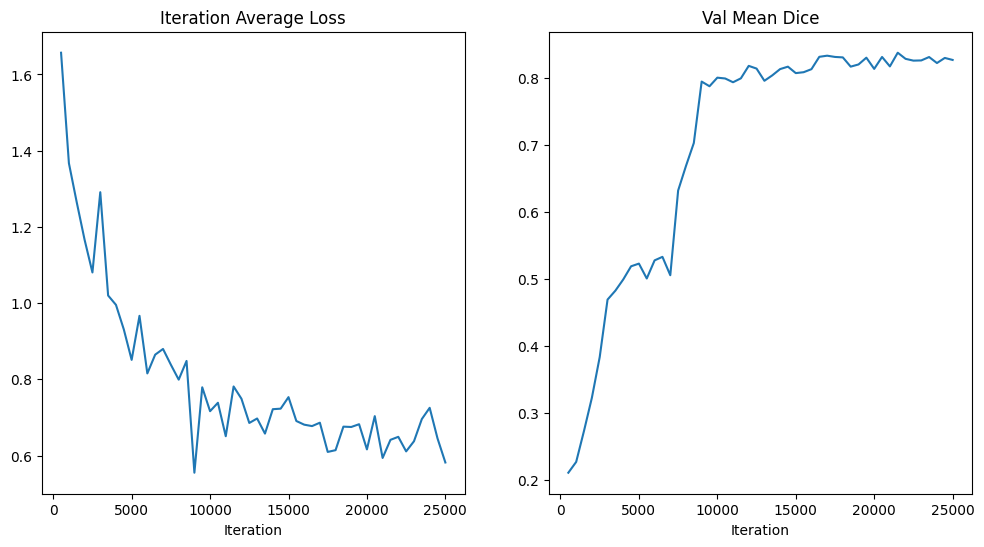

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

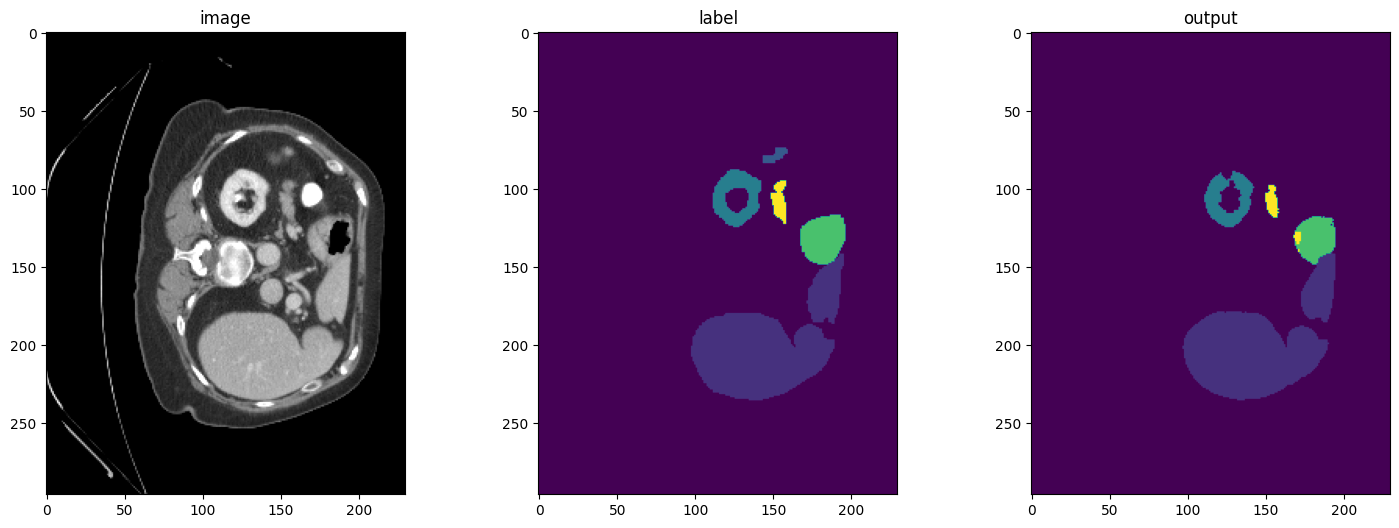

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold1_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [13]:
#fold 2
torch.cuda.empty_cache()  # 释放显存

In [14]:
# data_dir = "/dataset/"
split_json = "dataset_2.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


image shape: torch.Size([1, 242, 231, 238]), label shape: torch.Size([1, 242, 231, 238])


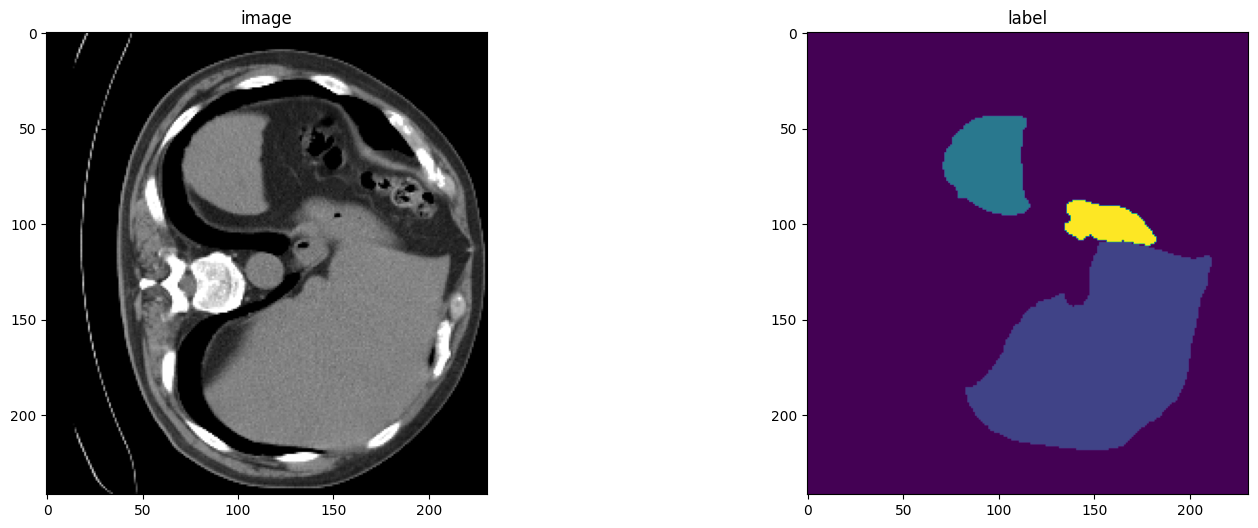

In [15]:
slice_map = {
    "img0023.nii.gz": 200,
    "img0024.nii.gz": 230,
    "img0025.nii.gz": 100,
    "img0026.nii.gz": 204,
    "img0027.nii.gz": 204,
    "img0028.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [16]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [17]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/unetr", "unetr_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.39164): 100%|█| 24/24 [00:07<00:00,  3.23it/
Training (47 / 25000 Steps) (loss=3.06166): 100%|█| 24/24 [00:07<00:00,  3.41it/
Training (71 / 25000 Steps) (loss=2.87955): 100%|█| 24/24 [00:07<00:00,  3.31it/
Training (95 / 25000 Steps) (loss=2.95553): 100%|█| 24/24 [00:07<00:00,  3.40it/
Training (119 / 25000 Steps) (loss=2.88436): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (143 / 25000 Steps) (loss=2.75522): 100%|█| 24/24 [00:07<00:00,  3.29it
Training (167 / 25000 Steps) (loss=2.79722): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (191 / 25000 Steps) (loss=2.78321): 100%|█| 24/24 [00:07<00:00,  3.39it
Training (215 / 25000 Steps) (loss=2.73029): 100%|█| 24/24 [00:07<00:00,  3.28it
Training (239 / 25000 Steps) (loss=2.60135): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (263 / 25000 Steps) (loss=2.59820): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (287 / 25000 Steps) (loss=2.54218): 100%|█| 24/24 [00:07<00:00,  3.22it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.15776559710502625 Current Avg. Dice: 0.15776559710502625


Training (503 / 25000 Steps) (loss=2.44956): 100%|█| 24/24 [00:11<00:00,  2.07it
Training (527 / 25000 Steps) (loss=2.13478): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (551 / 25000 Steps) (loss=2.22419): 100%|█| 24/24 [00:07<00:00,  3.32it
Training (575 / 25000 Steps) (loss=2.15635): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (599 / 25000 Steps) (loss=2.07640): 100%|█| 24/24 [00:07<00:00,  3.26it
Training (623 / 25000 Steps) (loss=1.98626): 100%|█| 24/24 [00:07<00:00,  3.23it
Training (647 / 25000 Steps) (loss=2.08754): 100%|█| 24/24 [00:07<00:00,  3.28it
Training (671 / 25000 Steps) (loss=2.11915): 100%|█| 24/24 [00:07<00:00,  3.34it
Training (695 / 25000 Steps) (loss=1.99182): 100%|█| 24/24 [00:07<00:00,  3.38it
Training (719 / 25000 Steps) (loss=1.88219): 100%|█| 24/24 [00:07<00:00,  3.24it
Training (743 / 25000 Steps) (loss=1.87951): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (767 / 25000 Steps) (loss=1.89191): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.21993927657604218 Current Avg. Dice: 0.21993927657604218


Training (1007 / 25000 Steps) (loss=1.73233): 100%|█| 24/24 [00:11<00:00,  2.11i
Training (1031 / 25000 Steps) (loss=1.63336): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (1055 / 25000 Steps) (loss=1.72769): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (1079 / 25000 Steps) (loss=1.65176): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1103 / 25000 Steps) (loss=1.74536): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (1127 / 25000 Steps) (loss=1.70856): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (1151 / 25000 Steps) (loss=1.65579): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (1175 / 25000 Steps) (loss=1.71753): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (1199 / 25000 Steps) (loss=1.41060): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (1223 / 25000 Steps) (loss=1.35569): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1247 / 25000 Steps) (loss=1.67510): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1271 / 25000 Steps) (loss=1.57243): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.22799712419509888 Current Avg. Dice: 0.22799712419509888


Training (1511 / 25000 Steps) (loss=1.51083): 100%|█| 24/24 [00:11<00:00,  2.11i
Training (1535 / 25000 Steps) (loss=1.34889): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1559 / 25000 Steps) (loss=1.81726): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1583 / 25000 Steps) (loss=1.44851): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (1607 / 25000 Steps) (loss=1.45033): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (1631 / 25000 Steps) (loss=1.54127): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (1655 / 25000 Steps) (loss=1.41619): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (1679 / 25000 Steps) (loss=1.48592): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1703 / 25000 Steps) (loss=1.47674): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (1727 / 25000 Steps) (loss=1.48973): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (1751 / 25000 Steps) (loss=1.55589): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (1775 / 25000 Steps) (loss=1.46041): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.33365845680236816 Current Avg. Dice: 0.33365845680236816


Training (2015 / 25000 Steps) (loss=1.29458): 100%|█| 24/24 [00:11<00:00,  2.10i
Training (2039 / 25000 Steps) (loss=1.31076): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (2063 / 25000 Steps) (loss=1.24725): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (2087 / 25000 Steps) (loss=1.43144): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (2111 / 25000 Steps) (loss=1.29278): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (2135 / 25000 Steps) (loss=1.17582): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2159 / 25000 Steps) (loss=1.30677): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (2183 / 25000 Steps) (loss=1.41381): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (2207 / 25000 Steps) (loss=1.35798): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2231 / 25000 Steps) (loss=1.40675): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2255 / 25000 Steps) (loss=1.33242): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (2279 / 25000 Steps) (loss=1.27651): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3688734471797943 Current Avg. Dice: 0.3688734471797943


Training (2519 / 25000 Steps) (loss=1.11250): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (2543 / 25000 Steps) (loss=1.08181): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (2567 / 25000 Steps) (loss=1.04588): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2591 / 25000 Steps) (loss=1.18934): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (2615 / 25000 Steps) (loss=1.11501): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (2639 / 25000 Steps) (loss=1.03620): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (2663 / 25000 Steps) (loss=1.08889): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (2687 / 25000 Steps) (loss=1.18721): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2711 / 25000 Steps) (loss=1.14242): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2735 / 25000 Steps) (loss=1.08148): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (2759 / 25000 Steps) (loss=1.16208): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (2783 / 25000 Steps) (loss=1.21809): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3727860450744629 Current Avg. Dice: 0.3727860450744629


Training (3023 / 25000 Steps) (loss=1.16814): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (3047 / 25000 Steps) (loss=1.17765): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (3071 / 25000 Steps) (loss=1.14554): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (3095 / 25000 Steps) (loss=1.40927): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3119 / 25000 Steps) (loss=0.99426): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (3143 / 25000 Steps) (loss=1.04629): 100%|█| 24/24 [00:07<00:00,  3.24i
Training (3167 / 25000 Steps) (loss=1.51911): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3191 / 25000 Steps) (loss=1.22639): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (3215 / 25000 Steps) (loss=1.08177): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3239 / 25000 Steps) (loss=1.03127): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3263 / 25000 Steps) (loss=1.07083): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (3287 / 25000 Steps) (loss=1.09238): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3727860450744629 Current Avg. Dice: 0.3420538008213043


Training (3503 / 25000 Steps) (loss=0.95950): 100%|█| 24/24 [00:10<00:00,  2.20i
Training (3527 / 25000 Steps) (loss=1.15556): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3551 / 25000 Steps) (loss=1.01425): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (3575 / 25000 Steps) (loss=1.05518): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (3599 / 25000 Steps) (loss=1.01665): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3623 / 25000 Steps) (loss=1.09547): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (3647 / 25000 Steps) (loss=1.07365): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3671 / 25000 Steps) (loss=1.15239): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3695 / 25000 Steps) (loss=0.93396): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3719 / 25000 Steps) (loss=0.95619): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3743 / 25000 Steps) (loss=1.07467): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3767 / 25000 Steps) (loss=0.89168): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5128492712974548 Current Avg. Dice: 0.5128492712974548


Training (4007 / 25000 Steps) (loss=0.99819): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (4031 / 25000 Steps) (loss=0.96135): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (4055 / 25000 Steps) (loss=0.93007): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (4079 / 25000 Steps) (loss=0.93535): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (4103 / 25000 Steps) (loss=0.94700): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (4127 / 25000 Steps) (loss=0.95581): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (4151 / 25000 Steps) (loss=0.94581): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4175 / 25000 Steps) (loss=0.90492): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (4199 / 25000 Steps) (loss=1.04060): 100%|█| 24/24 [00:07<00:00,  3.20i
Training (4223 / 25000 Steps) (loss=1.03232): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (4247 / 25000 Steps) (loss=0.93133): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4271 / 25000 Steps) (loss=0.97416): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5241682529449463 Current Avg. Dice: 0.5241682529449463


Training (4511 / 25000 Steps) (loss=0.90144): 100%|█| 24/24 [00:11<00:00,  2.11i
Training (4535 / 25000 Steps) (loss=0.83373): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (4559 / 25000 Steps) (loss=0.96048): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4583 / 25000 Steps) (loss=0.89337): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (4607 / 25000 Steps) (loss=0.79276): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (4631 / 25000 Steps) (loss=0.91653): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (4655 / 25000 Steps) (loss=0.91492): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (4679 / 25000 Steps) (loss=0.98544): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4703 / 25000 Steps) (loss=0.89350): 100%|█| 24/24 [00:07<00:00,  3.19i
Training (4727 / 25000 Steps) (loss=0.86486): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (4751 / 25000 Steps) (loss=0.92133): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4775 / 25000 Steps) (loss=0.80654): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5715397000312805 Current Avg. Dice: 0.5715397000312805


Training (5015 / 25000 Steps) (loss=0.83801): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (5039 / 25000 Steps) (loss=1.06852): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (5063 / 25000 Steps) (loss=0.83076): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (5087 / 25000 Steps) (loss=0.89850): 100%|█| 24/24 [00:07<00:00,  3.21i
Training (5111 / 25000 Steps) (loss=0.82531): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (5135 / 25000 Steps) (loss=0.84992): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (5159 / 25000 Steps) (loss=1.00875): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (5183 / 25000 Steps) (loss=0.94453): 100%|█| 24/24 [00:07<00:00,  3.21i
Training (5207 / 25000 Steps) (loss=1.57179): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (5231 / 25000 Steps) (loss=0.90876): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (5255 / 25000 Steps) (loss=0.94522): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5279 / 25000 Steps) (loss=0.83618): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5740664601325989 Current Avg. Dice: 0.5740664601325989


Training (5519 / 25000 Steps) (loss=0.84532): 100%|█| 24/24 [00:11<00:00,  2.09i
Training (5543 / 25000 Steps) (loss=1.01553): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5567 / 25000 Steps) (loss=0.93632): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5591 / 25000 Steps) (loss=0.95063): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (5615 / 25000 Steps) (loss=0.96924): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5639 / 25000 Steps) (loss=0.89523): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (5663 / 25000 Steps) (loss=0.84010): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (5687 / 25000 Steps) (loss=0.78479): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (5711 / 25000 Steps) (loss=0.73844): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (5735 / 25000 Steps) (loss=0.83147): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5759 / 25000 Steps) (loss=0.91758): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (5783 / 25000 Steps) (loss=0.82093): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6157495379447937 Current Avg. Dice: 0.6157495379447937


Training (6023 / 25000 Steps) (loss=0.96156): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (6047 / 25000 Steps) (loss=0.81842): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (6071 / 25000 Steps) (loss=0.85677): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (6095 / 25000 Steps) (loss=0.91080): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (6119 / 25000 Steps) (loss=0.93619): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (6143 / 25000 Steps) (loss=0.85327): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (6167 / 25000 Steps) (loss=0.90894): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (6191 / 25000 Steps) (loss=0.89815): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (6215 / 25000 Steps) (loss=0.79849): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6239 / 25000 Steps) (loss=0.99002): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (6263 / 25000 Steps) (loss=0.84964): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (6287 / 25000 Steps) (loss=0.93551): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.645503580570221 Current Avg. Dice: 0.645503580570221


Training (6503 / 25000 Steps) (loss=0.83325): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (6527 / 25000 Steps) (loss=0.85443): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6551 / 25000 Steps) (loss=1.09246): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6575 / 25000 Steps) (loss=1.32563): 100%|█| 24/24 [00:07<00:00,  3.23i
Training (6599 / 25000 Steps) (loss=0.91905): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6623 / 25000 Steps) (loss=0.83417): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (6647 / 25000 Steps) (loss=0.81059): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (6671 / 25000 Steps) (loss=0.74417): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6695 / 25000 Steps) (loss=0.86434): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (6719 / 25000 Steps) (loss=0.85140): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (6743 / 25000 Steps) (loss=0.84625): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (6767 / 25000 Steps) (loss=0.90792): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.645503580570221 Current Avg. Dice: 0.6300739049911499


Training (7007 / 25000 Steps) (loss=0.95066): 100%|█| 24/24 [00:10<00:00,  2.21i
Training (7031 / 25000 Steps) (loss=0.82798): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7055 / 25000 Steps) (loss=0.76583): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (7079 / 25000 Steps) (loss=0.94275): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7103 / 25000 Steps) (loss=0.75423): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (7127 / 25000 Steps) (loss=0.79885): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (7151 / 25000 Steps) (loss=0.84908): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (7175 / 25000 Steps) (loss=0.75808): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (7199 / 25000 Steps) (loss=0.86227): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (7223 / 25000 Steps) (loss=0.67986): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7247 / 25000 Steps) (loss=0.77511): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7271 / 25000 Steps) (loss=0.93594): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6476110816001892 Current Avg. Dice: 0.6476110816001892


Training (7511 / 25000 Steps) (loss=0.73345): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (7535 / 25000 Steps) (loss=0.73925): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7559 / 25000 Steps) (loss=0.80266): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7583 / 25000 Steps) (loss=0.82514): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7607 / 25000 Steps) (loss=0.80029): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (7631 / 25000 Steps) (loss=0.83470): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7655 / 25000 Steps) (loss=0.75881): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (7679 / 25000 Steps) (loss=0.76704): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (7703 / 25000 Steps) (loss=0.67948): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7727 / 25000 Steps) (loss=0.88567): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (7751 / 25000 Steps) (loss=0.85195): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (7775 / 25000 Steps) (loss=0.85493): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.685368537902832 Current Avg. Dice: 0.685368537902832


Training (8015 / 25000 Steps) (loss=0.57582): 100%|█| 24/24 [00:11<00:00,  2.14i
Training (8039 / 25000 Steps) (loss=0.75335): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8063 / 25000 Steps) (loss=0.83370): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8087 / 25000 Steps) (loss=0.83234): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (8111 / 25000 Steps) (loss=0.83392): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (8135 / 25000 Steps) (loss=0.60631): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8159 / 25000 Steps) (loss=1.12357): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8183 / 25000 Steps) (loss=0.70959): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8207 / 25000 Steps) (loss=0.72512): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8231 / 25000 Steps) (loss=0.70318): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (8255 / 25000 Steps) (loss=0.66997): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8279 / 25000 Steps) (loss=0.85830): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7013666033744812 Current Avg. Dice: 0.7013666033744812


Training (8519 / 25000 Steps) (loss=0.87457): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (8543 / 25000 Steps) (loss=0.72130): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8567 / 25000 Steps) (loss=0.77177): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (8591 / 25000 Steps) (loss=0.70407): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (8615 / 25000 Steps) (loss=0.75193): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8639 / 25000 Steps) (loss=0.74775): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (8663 / 25000 Steps) (loss=0.56114): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (8687 / 25000 Steps) (loss=0.78623): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8711 / 25000 Steps) (loss=0.73420): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (8735 / 25000 Steps) (loss=0.58253): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (8759 / 25000 Steps) (loss=0.81254): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8783 / 25000 Steps) (loss=0.85482): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7013666033744812 Current Avg. Dice: 0.6899940371513367


Training (9023 / 25000 Steps) (loss=0.76183): 100%|█| 24/24 [00:10<00:00,  2.19i
Training (9047 / 25000 Steps) (loss=0.70358): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (9071 / 25000 Steps) (loss=0.78647): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9095 / 25000 Steps) (loss=0.65421): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (9119 / 25000 Steps) (loss=0.76446): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (9143 / 25000 Steps) (loss=0.75494): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9167 / 25000 Steps) (loss=1.43234): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (9191 / 25000 Steps) (loss=0.71955): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9215 / 25000 Steps) (loss=0.69206): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9239 / 25000 Steps) (loss=0.61879): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (9263 / 25000 Steps) (loss=0.80340): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9287 / 25000 Steps) (loss=0.82101): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7370384335517883 Current Avg. Dice: 0.7370384335517883


Training (9503 / 25000 Steps) (loss=0.58656): 100%|█| 24/24 [00:11<00:00,  2.15i
Training (9527 / 25000 Steps) (loss=0.77980): 100%|█| 24/24 [00:07<00:00,  3.24i
Training (9551 / 25000 Steps) (loss=0.77254): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (9575 / 25000 Steps) (loss=0.56420): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9599 / 25000 Steps) (loss=0.61482): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (9623 / 25000 Steps) (loss=0.79698): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9647 / 25000 Steps) (loss=0.68725): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (9671 / 25000 Steps) (loss=0.53266): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (9695 / 25000 Steps) (loss=0.64173): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (9719 / 25000 Steps) (loss=0.77273): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (9743 / 25000 Steps) (loss=0.66456): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (9767 / 25000 Steps) (loss=0.98507): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7370384335517883 Current Avg. Dice: 0.712249755859375


Training (10007 / 25000 Steps) (loss=0.59650): 100%|█| 24/24 [00:10<00:00,  2.20
Training (10031 / 25000 Steps) (loss=0.81914): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10055 / 25000 Steps) (loss=1.18892): 100%|█| 24/24 [00:07<00:00,  3.36
Training (10079 / 25000 Steps) (loss=0.67370): 100%|█| 24/24 [00:07<00:00,  3.41
Training (10103 / 25000 Steps) (loss=0.72687): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10127 / 25000 Steps) (loss=1.00486): 100%|█| 24/24 [00:06<00:00,  3.43
Training (10151 / 25000 Steps) (loss=0.64417): 100%|█| 24/24 [00:07<00:00,  3.42
Training (10175 / 25000 Steps) (loss=0.54467): 100%|█| 24/24 [00:07<00:00,  3.37
Training (10199 / 25000 Steps) (loss=0.66648): 100%|█| 24/24 [00:07<00:00,  3.32
Training (10223 / 25000 Steps) (loss=0.57133): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10247 / 25000 Steps) (loss=0.61686): 100%|█| 24/24 [00:07<00:00,  3.40
Training (10271 / 25000 Steps) (loss=0.63293): 100%|█| 24/24 [00:07<00:00,  3.33
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370384335517883 Current Avg. Dice: 0.7258976101875305


Training (10511 / 25000 Steps) (loss=0.74088): 100%|█| 24/24 [00:10<00:00,  2.24
Training (10535 / 25000 Steps) (loss=0.75434): 100%|█| 24/24 [00:06<00:00,  3.44
Training (10559 / 25000 Steps) (loss=0.81671): 100%|█| 24/24 [00:07<00:00,  3.30
Training (10583 / 25000 Steps) (loss=0.58690): 100%|█| 24/24 [00:07<00:00,  3.37
Training (10607 / 25000 Steps) (loss=0.69990): 100%|█| 24/24 [00:07<00:00,  3.42
Training (10631 / 25000 Steps) (loss=0.82556): 100%|█| 24/24 [00:07<00:00,  3.33
Training (10655 / 25000 Steps) (loss=0.70235): 100%|█| 24/24 [00:07<00:00,  3.33
Training (10679 / 25000 Steps) (loss=0.63876): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10703 / 25000 Steps) (loss=0.71075): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10727 / 25000 Steps) (loss=0.66285): 100%|█| 24/24 [00:06<00:00,  3.45
Training (10751 / 25000 Steps) (loss=0.66691): 100%|█| 24/24 [00:07<00:00,  3.32
Training (10775 / 25000 Steps) (loss=0.58476): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370384335517883 Current Avg. Dice: 0.6529488563537598


Training (11015 / 25000 Steps) (loss=0.66201): 100%|█| 24/24 [00:11<00:00,  2.17
Training (11039 / 25000 Steps) (loss=0.59521): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11063 / 25000 Steps) (loss=0.78189): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11087 / 25000 Steps) (loss=0.73800): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11111 / 25000 Steps) (loss=0.79869): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11135 / 25000 Steps) (loss=0.72988): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11159 / 25000 Steps) (loss=0.51614): 100%|█| 24/24 [00:07<00:00,  3.37
Training (11183 / 25000 Steps) (loss=0.56615): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11207 / 25000 Steps) (loss=0.60758): 100%|█| 24/24 [00:07<00:00,  3.26
Training (11231 / 25000 Steps) (loss=0.56466): 100%|█| 24/24 [00:07<00:00,  3.28
Training (11255 / 25000 Steps) (loss=0.46546): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11279 / 25000 Steps) (loss=0.61239): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.7556878924369812


Training (11519 / 25000 Steps) (loss=0.78316): 100%|█| 24/24 [00:11<00:00,  2.12
Training (11543 / 25000 Steps) (loss=0.60151): 100%|█| 24/24 [00:07<00:00,  3.38
Training (11567 / 25000 Steps) (loss=0.57187): 100%|█| 24/24 [00:07<00:00,  3.28
Training (11591 / 25000 Steps) (loss=0.72869): 100%|█| 24/24 [00:07<00:00,  3.31
Training (11615 / 25000 Steps) (loss=0.61825): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11639 / 25000 Steps) (loss=0.73633): 100%|█| 24/24 [00:07<00:00,  3.32
Training (11663 / 25000 Steps) (loss=0.75395): 100%|█| 24/24 [00:07<00:00,  3.39
Training (11687 / 25000 Steps) (loss=0.74366): 100%|█| 24/24 [00:07<00:00,  3.39
Training (11711 / 25000 Steps) (loss=0.67186): 100%|█| 24/24 [00:07<00:00,  3.34
Training (11735 / 25000 Steps) (loss=0.70371): 100%|█| 24/24 [00:07<00:00,  3.27
Training (11759 / 25000 Steps) (loss=0.76422): 100%|█| 24/24 [00:07<00:00,  3.34
Training (11783 / 25000 Steps) (loss=0.94886): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.7380592226982117


Training (12023 / 25000 Steps) (loss=0.57302): 100%|█| 24/24 [00:10<00:00,  2.19
Training (12047 / 25000 Steps) (loss=0.73043): 100%|█| 24/24 [00:07<00:00,  3.29
Training (12071 / 25000 Steps) (loss=0.89777): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12095 / 25000 Steps) (loss=0.75089): 100%|█| 24/24 [00:07<00:00,  3.28
Training (12119 / 25000 Steps) (loss=0.51544): 100%|█| 24/24 [00:07<00:00,  3.30
Training (12143 / 25000 Steps) (loss=0.61280): 100%|█| 24/24 [00:07<00:00,  3.26
Training (12167 / 25000 Steps) (loss=0.71694): 100%|█| 24/24 [00:07<00:00,  3.32
Training (12191 / 25000 Steps) (loss=0.67768): 100%|█| 24/24 [00:07<00:00,  3.34
Training (12215 / 25000 Steps) (loss=0.78440): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12239 / 25000 Steps) (loss=0.65770): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12263 / 25000 Steps) (loss=0.70506): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12287 / 25000 Steps) (loss=0.67097): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.7284603118896484


Training (12503 / 25000 Steps) (loss=0.69285): 100%|█| 24/24 [00:10<00:00,  2.21
Training (12527 / 25000 Steps) (loss=0.77875): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12551 / 25000 Steps) (loss=0.80621): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12575 / 25000 Steps) (loss=0.69982): 100%|█| 24/24 [00:07<00:00,  3.30
Training (12599 / 25000 Steps) (loss=0.82258): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12623 / 25000 Steps) (loss=0.55841): 100%|█| 24/24 [00:07<00:00,  3.25
Training (12647 / 25000 Steps) (loss=0.73770): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12671 / 25000 Steps) (loss=0.64931): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12695 / 25000 Steps) (loss=0.75587): 100%|█| 24/24 [00:07<00:00,  3.28
Training (12719 / 25000 Steps) (loss=0.77104): 100%|█| 24/24 [00:07<00:00,  3.30
Training (12743 / 25000 Steps) (loss=0.73810): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12767 / 25000 Steps) (loss=0.70613): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.7527268528938293


Training (13007 / 25000 Steps) (loss=0.79695): 100%|█| 24/24 [00:10<00:00,  2.22
Training (13031 / 25000 Steps) (loss=0.65600): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13055 / 25000 Steps) (loss=0.50999): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13079 / 25000 Steps) (loss=0.81699): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13103 / 25000 Steps) (loss=0.64759): 100%|█| 24/24 [00:07<00:00,  3.32
Training (13127 / 25000 Steps) (loss=0.75741): 100%|█| 24/24 [00:07<00:00,  3.34
Training (13151 / 25000 Steps) (loss=0.62299): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13175 / 25000 Steps) (loss=0.74280): 100%|█| 24/24 [00:07<00:00,  3.41
Training (13199 / 25000 Steps) (loss=0.83423): 100%|█| 24/24 [00:07<00:00,  3.35
Training (13223 / 25000 Steps) (loss=0.72272): 100%|█| 24/24 [00:07<00:00,  3.42
Training (13247 / 25000 Steps) (loss=0.65067): 100%|█| 24/24 [00:07<00:00,  3.21
Training (13271 / 25000 Steps) (loss=0.64902): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.7396540641784668


Training (13511 / 25000 Steps) (loss=0.72427): 100%|█| 24/24 [00:11<00:00,  2.17
Training (13535 / 25000 Steps) (loss=0.84598): 100%|█| 24/24 [00:07<00:00,  3.26
Training (13559 / 25000 Steps) (loss=0.43305): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13583 / 25000 Steps) (loss=0.71039): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13607 / 25000 Steps) (loss=0.64343): 100%|█| 24/24 [00:07<00:00,  3.27
Training (13631 / 25000 Steps) (loss=0.70900): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13655 / 25000 Steps) (loss=0.59231): 100%|█| 24/24 [00:07<00:00,  3.35
Training (13679 / 25000 Steps) (loss=0.73483): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13703 / 25000 Steps) (loss=0.68033): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13727 / 25000 Steps) (loss=0.71253): 100%|█| 24/24 [00:07<00:00,  3.35
Training (13751 / 25000 Steps) (loss=0.66973): 100%|█| 24/24 [00:07<00:00,  3.40
Training (13775 / 25000 Steps) (loss=0.80177): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.7372243404388428


Training (14015 / 25000 Steps) (loss=0.68613): 100%|█| 24/24 [00:10<00:00,  2.23
Training (14039 / 25000 Steps) (loss=0.64854): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14063 / 25000 Steps) (loss=0.88525): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14087 / 25000 Steps) (loss=0.81895): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14111 / 25000 Steps) (loss=0.77018): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14135 / 25000 Steps) (loss=0.69054): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14159 / 25000 Steps) (loss=0.67032): 100%|█| 24/24 [00:07<00:00,  3.30
Training (14183 / 25000 Steps) (loss=0.54210): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14207 / 25000 Steps) (loss=0.74362): 100%|█| 24/24 [00:07<00:00,  3.37
Training (14231 / 25000 Steps) (loss=0.53877): 100%|█| 24/24 [00:07<00:00,  3.36
Training (14255 / 25000 Steps) (loss=0.70093): 100%|█| 24/24 [00:07<00:00,  3.42
Training (14279 / 25000 Steps) (loss=0.69789): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7556878924369812 Current Avg. Dice: 0.6995019316673279


Training (14519 / 25000 Steps) (loss=0.53599): 100%|█| 24/24 [00:10<00:00,  2.23
Training (14543 / 25000 Steps) (loss=0.64438): 100%|█| 24/24 [00:06<00:00,  3.44
Training (14567 / 25000 Steps) (loss=0.61061): 100%|█| 24/24 [00:07<00:00,  3.33
Training (14591 / 25000 Steps) (loss=0.69159): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14615 / 25000 Steps) (loss=0.49486): 100%|█| 24/24 [00:07<00:00,  3.41
Training (14639 / 25000 Steps) (loss=0.55942): 100%|█| 24/24 [00:07<00:00,  3.33
Training (14663 / 25000 Steps) (loss=0.45160): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14687 / 25000 Steps) (loss=0.79928): 100%|█| 24/24 [00:07<00:00,  3.37
Training (14711 / 25000 Steps) (loss=0.79019): 100%|█| 24/24 [00:07<00:00,  3.40
Training (14735 / 25000 Steps) (loss=0.67581): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14759 / 25000 Steps) (loss=0.50878): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14783 / 25000 Steps) (loss=0.61114): 100%|█| 24/24 [00:07<00:00,  3.27
Training (14807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7669739127159119 Current Avg. Dice: 0.7669739127159119


Training (15023 / 25000 Steps) (loss=0.51773): 100%|█| 24/24 [00:11<00:00,  2.16
Training (15047 / 25000 Steps) (loss=0.54258): 100%|█| 24/24 [00:07<00:00,  3.37
Training (15071 / 25000 Steps) (loss=0.44369): 100%|█| 24/24 [00:07<00:00,  3.31
Training (15095 / 25000 Steps) (loss=0.60109): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15119 / 25000 Steps) (loss=0.67309): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15143 / 25000 Steps) (loss=0.68908): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15167 / 25000 Steps) (loss=0.66830): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15191 / 25000 Steps) (loss=0.71640): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15215 / 25000 Steps) (loss=0.76628): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15239 / 25000 Steps) (loss=0.71954): 100%|█| 24/24 [00:07<00:00,  3.41
Training (15263 / 25000 Steps) (loss=0.64848): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15287 / 25000 Steps) (loss=0.76900): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7669739127159119 Current Avg. Dice: 0.7068891525268555


Training (15503 / 25000 Steps) (loss=0.63763): 100%|█| 24/24 [00:10<00:00,  2.23
Training (15527 / 25000 Steps) (loss=0.71214): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15551 / 25000 Steps) (loss=0.74816): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15575 / 25000 Steps) (loss=0.56482): 100%|█| 24/24 [00:07<00:00,  3.36
Training (15599 / 25000 Steps) (loss=0.77818): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15623 / 25000 Steps) (loss=0.63239): 100%|█| 24/24 [00:07<00:00,  3.33
Training (15647 / 25000 Steps) (loss=0.47048): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15671 / 25000 Steps) (loss=0.61583): 100%|█| 24/24 [00:07<00:00,  3.29
Training (15695 / 25000 Steps) (loss=0.62413): 100%|█| 24/24 [00:07<00:00,  3.43
Training (15719 / 25000 Steps) (loss=0.79301): 100%|█| 24/24 [00:07<00:00,  3.41
Training (15743 / 25000 Steps) (loss=0.67480): 100%|█| 24/24 [00:07<00:00,  3.25
Training (15767 / 25000 Steps) (loss=0.67083): 100%|█| 24/24 [00:07<00:00,  3.36
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7669739127159119 Current Avg. Dice: 0.7337178587913513


Training (16007 / 25000 Steps) (loss=0.68044): 100%|█| 24/24 [00:10<00:00,  2.19
Training (16031 / 25000 Steps) (loss=0.51009): 100%|█| 24/24 [00:07<00:00,  3.23
Training (16055 / 25000 Steps) (loss=0.74779): 100%|█| 24/24 [00:07<00:00,  3.30
Training (16079 / 25000 Steps) (loss=0.46761): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16103 / 25000 Steps) (loss=0.80427): 100%|█| 24/24 [00:07<00:00,  3.39
Training (16127 / 25000 Steps) (loss=0.48630): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16151 / 25000 Steps) (loss=0.50468): 100%|█| 24/24 [00:07<00:00,  3.42
Training (16175 / 25000 Steps) (loss=0.72512): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16199 / 25000 Steps) (loss=0.82272): 100%|█| 24/24 [00:07<00:00,  3.39
Training (16223 / 25000 Steps) (loss=0.79307): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16247 / 25000 Steps) (loss=0.64798): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16271 / 25000 Steps) (loss=0.62789): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7669739127159119 Current Avg. Dice: 0.7432085871696472


Training (16511 / 25000 Steps) (loss=0.50174): 100%|█| 24/24 [00:11<00:00,  2.16
Training (16535 / 25000 Steps) (loss=0.71944): 100%|█| 24/24 [00:07<00:00,  3.39
Training (16559 / 25000 Steps) (loss=0.63673): 100%|█| 24/24 [00:07<00:00,  3.38
Training (16583 / 25000 Steps) (loss=0.60153): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16607 / 25000 Steps) (loss=0.76996): 100%|█| 24/24 [00:07<00:00,  3.27
Training (16631 / 25000 Steps) (loss=0.67170): 100%|█| 24/24 [00:07<00:00,  3.38
Training (16655 / 25000 Steps) (loss=1.23898): 100%|█| 24/24 [00:07<00:00,  3.39
Training (16679 / 25000 Steps) (loss=0.79550): 100%|█| 24/24 [00:07<00:00,  3.38
Training (16703 / 25000 Steps) (loss=0.64140): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16727 / 25000 Steps) (loss=0.62292): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16751 / 25000 Steps) (loss=0.54564): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16775 / 25000 Steps) (loss=0.57248): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7669739127159119 Current Avg. Dice: 0.7617425322532654


Training (17015 / 25000 Steps) (loss=0.84061): 100%|█| 24/24 [00:11<00:00,  2.18
Training (17039 / 25000 Steps) (loss=0.70028): 100%|█| 24/24 [00:07<00:00,  3.39
Training (17063 / 25000 Steps) (loss=0.81614): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17087 / 25000 Steps) (loss=0.66248): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17111 / 25000 Steps) (loss=0.77906): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17135 / 25000 Steps) (loss=0.78036): 100%|█| 24/24 [00:07<00:00,  3.32
Training (17159 / 25000 Steps) (loss=0.77652): 100%|█| 24/24 [00:07<00:00,  3.33
Training (17183 / 25000 Steps) (loss=0.64127): 100%|█| 24/24 [00:07<00:00,  3.34
Training (17207 / 25000 Steps) (loss=0.69917): 100%|█| 24/24 [00:07<00:00,  3.27
Training (17231 / 25000 Steps) (loss=0.79709): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17255 / 25000 Steps) (loss=0.48165): 100%|█| 24/24 [00:07<00:00,  3.33
Training (17279 / 25000 Steps) (loss=0.71218): 100%|█| 24/24 [00:07<00:00,  3.40
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7669739127159119 Current Avg. Dice: 0.7523878216743469


Training (17519 / 25000 Steps) (loss=0.61401): 100%|█| 24/24 [00:10<00:00,  2.19
Training (17543 / 25000 Steps) (loss=0.70393): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17567 / 25000 Steps) (loss=0.77321): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17591 / 25000 Steps) (loss=0.66476): 100%|█| 24/24 [00:07<00:00,  3.40
Training (17615 / 25000 Steps) (loss=0.73123): 100%|█| 24/24 [00:07<00:00,  3.33
Training (17639 / 25000 Steps) (loss=0.80912): 100%|█| 24/24 [00:07<00:00,  3.37
Training (17663 / 25000 Steps) (loss=0.70427): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17687 / 25000 Steps) (loss=0.74740): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17711 / 25000 Steps) (loss=0.65420): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17735 / 25000 Steps) (loss=0.64638): 100%|█| 24/24 [00:07<00:00,  3.28
Training (17759 / 25000 Steps) (loss=0.62744): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17783 / 25000 Steps) (loss=0.62087): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.782630443572998


Training (18023 / 25000 Steps) (loss=0.57689): 100%|█| 24/24 [00:11<00:00,  2.11
Training (18047 / 25000 Steps) (loss=1.48585): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18071 / 25000 Steps) (loss=0.78662): 100%|█| 24/24 [00:07<00:00,  3.38
Training (18095 / 25000 Steps) (loss=0.71608): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18119 / 25000 Steps) (loss=0.46307): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18143 / 25000 Steps) (loss=0.55584): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18167 / 25000 Steps) (loss=0.52362): 100%|█| 24/24 [00:07<00:00,  3.42
Training (18191 / 25000 Steps) (loss=0.50904): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18215 / 25000 Steps) (loss=0.61479): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18239 / 25000 Steps) (loss=0.70903): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18263 / 25000 Steps) (loss=0.91749): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18287 / 25000 Steps) (loss=0.63658): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7405503392219543


Training (18503 / 25000 Steps) (loss=0.70749): 100%|█| 24/24 [00:10<00:00,  2.22
Training (18527 / 25000 Steps) (loss=0.52273): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18551 / 25000 Steps) (loss=0.50519): 100%|█| 24/24 [00:07<00:00,  3.27
Training (18575 / 25000 Steps) (loss=0.56107): 100%|█| 24/24 [00:07<00:00,  3.40
Training (18599 / 25000 Steps) (loss=0.56411): 100%|█| 24/24 [00:07<00:00,  3.39
Training (18623 / 25000 Steps) (loss=0.68034): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18647 / 25000 Steps) (loss=0.68360): 100%|█| 24/24 [00:07<00:00,  3.33
Training (18671 / 25000 Steps) (loss=0.50357): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18695 / 25000 Steps) (loss=0.67157): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18719 / 25000 Steps) (loss=0.65456): 100%|█| 24/24 [00:07<00:00,  3.37
Training (18743 / 25000 Steps) (loss=0.39676): 100%|█| 24/24 [00:07<00:00,  3.22
Training (18767 / 25000 Steps) (loss=0.44601): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7554790377616882


Training (19007 / 25000 Steps) (loss=0.68835): 100%|█| 24/24 [00:11<00:00,  2.11
Training (19031 / 25000 Steps) (loss=0.78970): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19055 / 25000 Steps) (loss=0.70788): 100%|█| 24/24 [00:07<00:00,  3.26
Training (19079 / 25000 Steps) (loss=0.44054): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19103 / 25000 Steps) (loss=0.56685): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19127 / 25000 Steps) (loss=0.76586): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19151 / 25000 Steps) (loss=0.56817): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19175 / 25000 Steps) (loss=0.68248): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19199 / 25000 Steps) (loss=0.92366): 100%|█| 24/24 [00:07<00:00,  3.30
Training (19223 / 25000 Steps) (loss=0.43786): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19247 / 25000 Steps) (loss=0.64174): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19271 / 25000 Steps) (loss=0.47376): 100%|█| 24/24 [00:07<00:00,  3.40
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7430334687232971


Training (19511 / 25000 Steps) (loss=0.62577): 100%|█| 24/24 [00:10<00:00,  2.24
Training (19535 / 25000 Steps) (loss=0.69587): 100%|█| 24/24 [00:07<00:00,  3.34
Training (19559 / 25000 Steps) (loss=0.58626): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19583 / 25000 Steps) (loss=0.63433): 100%|█| 24/24 [00:07<00:00,  3.29
Training (19607 / 25000 Steps) (loss=0.58019): 100%|█| 24/24 [00:07<00:00,  3.38
Training (19631 / 25000 Steps) (loss=0.72843): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19655 / 25000 Steps) (loss=0.59588): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19679 / 25000 Steps) (loss=0.68158): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19703 / 25000 Steps) (loss=0.52110): 100%|█| 24/24 [00:06<00:00,  3.44
Training (19727 / 25000 Steps) (loss=0.71682): 100%|█| 24/24 [00:07<00:00,  3.42
Training (19751 / 25000 Steps) (loss=0.63440): 100%|█| 24/24 [00:07<00:00,  3.42
Training (19775 / 25000 Steps) (loss=0.53028): 100%|█| 24/24 [00:07<00:00,  3.36
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7340090870857239


Training (20015 / 25000 Steps) (loss=0.79305): 100%|█| 24/24 [00:10<00:00,  2.19
Training (20039 / 25000 Steps) (loss=0.70750): 100%|█| 24/24 [00:07<00:00,  3.38
Training (20063 / 25000 Steps) (loss=0.62401): 100%|█| 24/24 [00:07<00:00,  3.30
Training (20087 / 25000 Steps) (loss=0.70194): 100%|█| 24/24 [00:07<00:00,  3.43
Training (20111 / 25000 Steps) (loss=0.57904): 100%|█| 24/24 [00:06<00:00,  3.44
Training (20135 / 25000 Steps) (loss=0.71143): 100%|█| 24/24 [00:07<00:00,  3.43
Training (20159 / 25000 Steps) (loss=0.77586): 100%|█| 24/24 [00:07<00:00,  3.34
Training (20183 / 25000 Steps) (loss=0.62885): 100%|█| 24/24 [00:07<00:00,  3.37
Training (20207 / 25000 Steps) (loss=0.65460): 100%|█| 24/24 [00:07<00:00,  3.31
Training (20231 / 25000 Steps) (loss=0.83365): 100%|█| 24/24 [00:07<00:00,  3.37
Training (20255 / 25000 Steps) (loss=0.40454): 100%|█| 24/24 [00:07<00:00,  3.34
Training (20279 / 25000 Steps) (loss=0.91323): 100%|█| 24/24 [00:07<00:00,  3.35
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7548527717590332


Training (20519 / 25000 Steps) (loss=0.67804): 100%|█| 24/24 [00:10<00:00,  2.23
Training (20543 / 25000 Steps) (loss=0.72277): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20567 / 25000 Steps) (loss=0.88322): 100%|█| 24/24 [00:07<00:00,  3.38
Training (20591 / 25000 Steps) (loss=0.70338): 100%|█| 24/24 [00:07<00:00,  3.36
Training (20615 / 25000 Steps) (loss=0.68467): 100%|█| 24/24 [00:07<00:00,  3.42
Training (20639 / 25000 Steps) (loss=0.55786): 100%|█| 24/24 [00:07<00:00,  3.36
Training (20663 / 25000 Steps) (loss=0.69080): 100%|█| 24/24 [00:07<00:00,  3.34
Training (20687 / 25000 Steps) (loss=0.64561): 100%|█| 24/24 [00:06<00:00,  3.45
Training (20711 / 25000 Steps) (loss=0.38860): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20735 / 25000 Steps) (loss=0.74209): 100%|█| 24/24 [00:07<00:00,  3.42
Training (20759 / 25000 Steps) (loss=0.72446): 100%|█| 24/24 [00:06<00:00,  3.46
Training (20783 / 25000 Steps) (loss=0.40759): 100%|█| 24/24 [00:07<00:00,  3.40
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7557716369628906


Training (21023 / 25000 Steps) (loss=0.71792): 100%|█| 24/24 [00:10<00:00,  2.22
Training (21047 / 25000 Steps) (loss=0.58078): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21071 / 25000 Steps) (loss=0.46630): 100%|█| 24/24 [00:07<00:00,  3.35
Training (21095 / 25000 Steps) (loss=0.83624): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21119 / 25000 Steps) (loss=0.67653): 100%|█| 24/24 [00:07<00:00,  3.37
Training (21143 / 25000 Steps) (loss=0.74042): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21167 / 25000 Steps) (loss=0.49979): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21191 / 25000 Steps) (loss=0.69409): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21215 / 25000 Steps) (loss=0.58673): 100%|█| 24/24 [00:07<00:00,  3.35
Training (21239 / 25000 Steps) (loss=0.53516): 100%|█| 24/24 [00:07<00:00,  3.31
Training (21263 / 25000 Steps) (loss=0.63997): 100%|█| 24/24 [00:07<00:00,  3.36
Training (21287 / 25000 Steps) (loss=0.54944): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7572725415229797


Training (21503 / 25000 Steps) (loss=0.55013): 100%|█| 24/24 [00:10<00:00,  2.22
Training (21527 / 25000 Steps) (loss=0.45943): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21551 / 25000 Steps) (loss=0.74263): 100%|█| 24/24 [00:07<00:00,  3.41
Training (21575 / 25000 Steps) (loss=0.67153): 100%|█| 24/24 [00:07<00:00,  3.38
Training (21599 / 25000 Steps) (loss=0.69605): 100%|█| 24/24 [00:07<00:00,  3.42
Training (21623 / 25000 Steps) (loss=0.80853): 100%|█| 24/24 [00:06<00:00,  3.43
Training (21647 / 25000 Steps) (loss=0.67997): 100%|█| 24/24 [00:06<00:00,  3.43
Training (21671 / 25000 Steps) (loss=0.66009): 100%|█| 24/24 [00:06<00:00,  3.45
Training (21695 / 25000 Steps) (loss=0.46460): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21719 / 25000 Steps) (loss=0.61227): 100%|█| 24/24 [00:07<00:00,  3.28
Training (21743 / 25000 Steps) (loss=0.49643): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21767 / 25000 Steps) (loss=0.48609): 100%|█| 24/24 [00:07<00:00,  3.38
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.776522159576416


Training (22007 / 25000 Steps) (loss=0.52970): 100%|█| 24/24 [00:10<00:00,  2.19
Training (22031 / 25000 Steps) (loss=0.83041): 100%|█| 24/24 [00:07<00:00,  3.42
Training (22055 / 25000 Steps) (loss=0.59591): 100%|█| 24/24 [00:07<00:00,  3.37
Training (22079 / 25000 Steps) (loss=0.61482): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22103 / 25000 Steps) (loss=0.78687): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22127 / 25000 Steps) (loss=0.75099): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22151 / 25000 Steps) (loss=0.67255): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22175 / 25000 Steps) (loss=0.53240): 100%|█| 24/24 [00:07<00:00,  3.28
Training (22199 / 25000 Steps) (loss=0.68671): 100%|█| 24/24 [00:06<00:00,  3.44
Training (22223 / 25000 Steps) (loss=0.49299): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22247 / 25000 Steps) (loss=0.61119): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22271 / 25000 Steps) (loss=0.76210): 100%|█| 24/24 [00:07<00:00,  3.40
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7677111029624939


Training (22511 / 25000 Steps) (loss=0.54216): 100%|█| 24/24 [00:10<00:00,  2.20
Training (22535 / 25000 Steps) (loss=0.57942): 100%|█| 24/24 [00:07<00:00,  3.32
Training (22559 / 25000 Steps) (loss=0.49891): 100%|█| 24/24 [00:07<00:00,  3.37
Training (22583 / 25000 Steps) (loss=0.57466): 100%|█| 24/24 [00:06<00:00,  3.43
Training (22607 / 25000 Steps) (loss=0.54684): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22631 / 25000 Steps) (loss=0.50169): 100%|█| 24/24 [00:07<00:00,  3.31
Training (22655 / 25000 Steps) (loss=0.99984): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22679 / 25000 Steps) (loss=0.53767): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22703 / 25000 Steps) (loss=0.66284): 100%|█| 24/24 [00:07<00:00,  3.40
Training (22727 / 25000 Steps) (loss=0.71103): 100%|█| 24/24 [00:07<00:00,  3.34
Training (22751 / 25000 Steps) (loss=0.59521): 100%|█| 24/24 [00:07<00:00,  3.35
Training (22775 / 25000 Steps) (loss=0.41855): 100%|█| 24/24 [00:07<00:00,  3.20
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.6937416195869446


Training (23015 / 25000 Steps) (loss=0.45062): 100%|█| 24/24 [00:10<00:00,  2.22
Training (23039 / 25000 Steps) (loss=0.65778): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23063 / 25000 Steps) (loss=0.47098): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23087 / 25000 Steps) (loss=0.56491): 100%|█| 24/24 [00:06<00:00,  3.47
Training (23111 / 25000 Steps) (loss=0.57366): 100%|█| 24/24 [00:07<00:00,  3.34
Training (23135 / 25000 Steps) (loss=0.77136): 100%|█| 24/24 [00:07<00:00,  3.36
Training (23159 / 25000 Steps) (loss=0.66754): 100%|█| 24/24 [00:07<00:00,  3.35
Training (23183 / 25000 Steps) (loss=0.47348): 100%|█| 24/24 [00:07<00:00,  3.34
Training (23207 / 25000 Steps) (loss=0.53753): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23231 / 25000 Steps) (loss=0.51410): 100%|█| 24/24 [00:07<00:00,  3.23
Training (23255 / 25000 Steps) (loss=0.64711): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23279 / 25000 Steps) (loss=0.73959): 100%|█| 24/24 [00:07<00:00,  3.41
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7484251856803894


Training (23519 / 25000 Steps) (loss=0.44052): 100%|█| 24/24 [00:11<00:00,  2.17
Training (23543 / 25000 Steps) (loss=0.65220): 100%|█| 24/24 [00:07<00:00,  3.43
Training (23567 / 25000 Steps) (loss=0.50091): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23591 / 25000 Steps) (loss=0.67898): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23615 / 25000 Steps) (loss=0.62937): 100%|█| 24/24 [00:07<00:00,  3.22
Training (23639 / 25000 Steps) (loss=0.43395): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23663 / 25000 Steps) (loss=0.55517): 100%|█| 24/24 [00:07<00:00,  3.34
Training (23687 / 25000 Steps) (loss=0.66273): 100%|█| 24/24 [00:06<00:00,  3.44
Training (23711 / 25000 Steps) (loss=0.71321): 100%|█| 24/24 [00:07<00:00,  3.35
Training (23735 / 25000 Steps) (loss=0.60737): 100%|█| 24/24 [00:07<00:00,  3.35
Training (23759 / 25000 Steps) (loss=0.77351): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23783 / 25000 Steps) (loss=0.60700): 100%|█| 24/24 [00:07<00:00,  3.32
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7587650418281555


Training (24023 / 25000 Steps) (loss=0.60364): 100%|█| 24/24 [00:10<00:00,  2.21
Training (24047 / 25000 Steps) (loss=0.60975): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24071 / 25000 Steps) (loss=0.74645): 100%|█| 24/24 [00:07<00:00,  3.38
Training (24095 / 25000 Steps) (loss=0.59684): 100%|█| 24/24 [00:06<00:00,  3.43
Training (24119 / 25000 Steps) (loss=0.67434): 100%|█| 24/24 [00:07<00:00,  3.43
Training (24143 / 25000 Steps) (loss=0.64862): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24167 / 25000 Steps) (loss=0.50439): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24191 / 25000 Steps) (loss=0.65667): 100%|█| 24/24 [00:07<00:00,  3.40
Training (24215 / 25000 Steps) (loss=0.56013): 100%|█| 24/24 [00:07<00:00,  3.36
Training (24239 / 25000 Steps) (loss=0.76610): 100%|█| 24/24 [00:07<00:00,  3.37
Training (24263 / 25000 Steps) (loss=0.61666): 100%|█| 24/24 [00:07<00:00,  3.41
Training (24287 / 25000 Steps) (loss=0.44851): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.782630443572998 Current Avg. Dice: 0.7346712946891785


Training (24503 / 25000 Steps) (loss=0.48456): 100%|█| 24/24 [00:11<00:00,  2.15
Training (24527 / 25000 Steps) (loss=0.59003): 100%|█| 24/24 [00:07<00:00,  3.42
Training (24551 / 25000 Steps) (loss=0.60923): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24575 / 25000 Steps) (loss=0.70296): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24599 / 25000 Steps) (loss=0.65985): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24623 / 25000 Steps) (loss=0.49287): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24647 / 25000 Steps) (loss=0.53477): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24671 / 25000 Steps) (loss=0.80519): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24695 / 25000 Steps) (loss=0.45780): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24719 / 25000 Steps) (loss=0.51735): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24743 / 25000 Steps) (loss=0.67320): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24767 / 25000 Steps) (loss=0.71921): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7855501174926758 Current Avg. Dice: 0.7855501174926758


Training (25007 / 25000 Steps) (loss=0.70858): 100%|█| 24/24 [00:11<00:00,  2.15


<All keys matched successfully>

In [18]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7856 at iteration: 25000


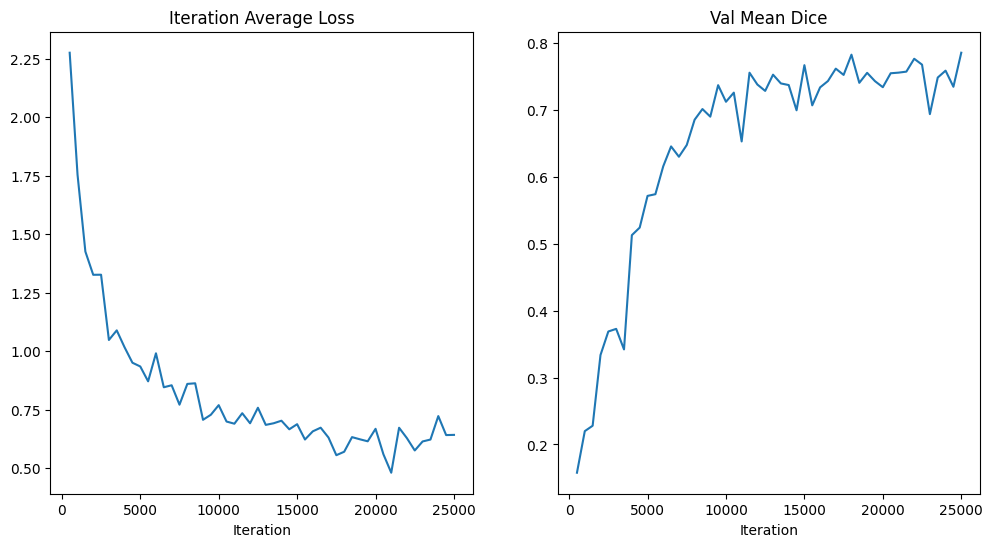

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

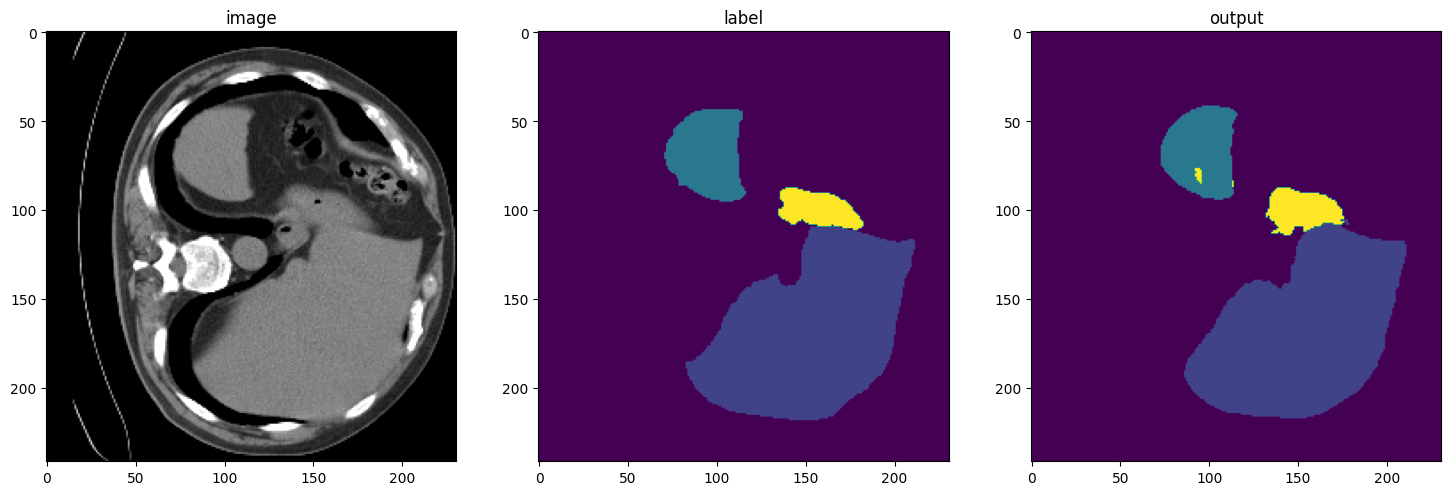

In [20]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold2_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [21]:
#fold 3
torch.cuda.empty_cache()

In [22]:
# data_dir = "/dataset/"
split_json = "dataset_3.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]


image shape: torch.Size([1, 256, 226, 244]), label shape: torch.Size([1, 256, 226, 244])


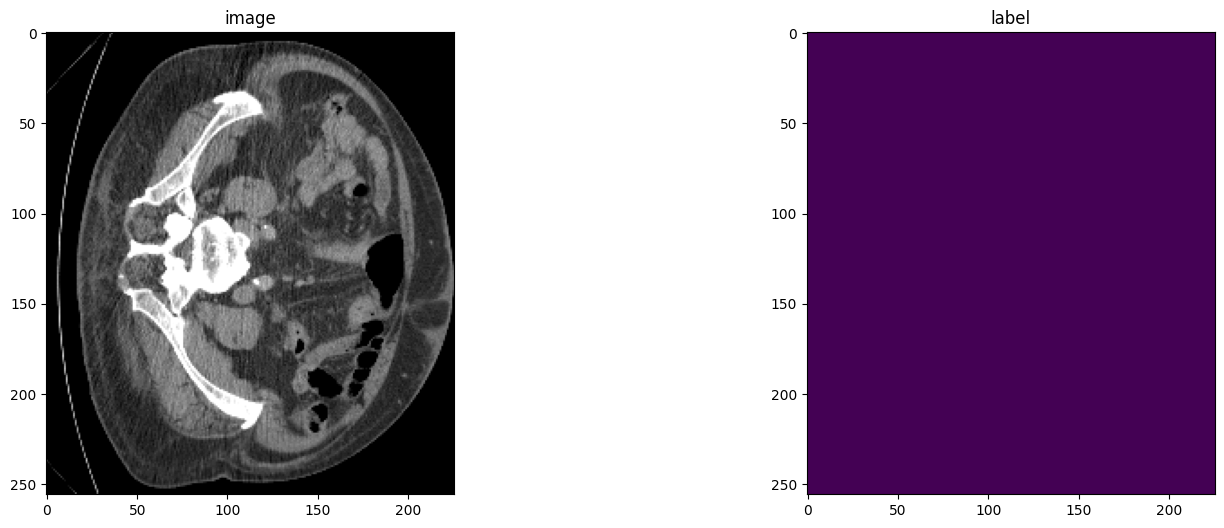

In [23]:
slice_map = {
    "img0007.nii.gz": 90,
    "img0008.nii.gz": 90,
    "img0009.nii.gz": 90,
    "img0010.nii.gz": 90,
    "img0021.nii.gz": 90,
    "img0022.nii.gz": 90,
}

case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [24]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [25]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/unetr", "unetr_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.65669): 100%|█| 24/24 [00:07<00:00,  3.20it/
Training (47 / 25000 Steps) (loss=2.47110): 100%|█| 24/24 [00:07<00:00,  3.39it/
Training (71 / 25000 Steps) (loss=2.41432): 100%|█| 24/24 [00:07<00:00,  3.40it/
Training (95 / 25000 Steps) (loss=2.34971): 100%|█| 24/24 [00:07<00:00,  3.35it/
Training (119 / 25000 Steps) (loss=2.31278): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (143 / 25000 Steps) (loss=2.27776): 100%|█| 24/24 [00:07<00:00,  3.36it
Training (167 / 25000 Steps) (loss=2.25115): 100%|█| 24/24 [00:07<00:00,  3.34it
Training (191 / 25000 Steps) (loss=2.15611): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (215 / 25000 Steps) (loss=2.14598): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (239 / 25000 Steps) (loss=2.18664): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (263 / 25000 Steps) (loss=2.08001): 100%|█| 24/24 [00:07<00:00,  3.34it
Training (287 / 25000 Steps) (loss=2.09441): 100%|█| 24/24 [00:07<00:00,  3.34it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.1876291036605835 Current Avg. Dice: 0.1876291036605835


Training (503 / 25000 Steps) (loss=1.85350): 100%|█| 24/24 [00:11<00:00,  2.13it
Training (527 / 25000 Steps) (loss=1.80438): 100%|█| 24/24 [00:07<00:00,  3.37it
Training (551 / 25000 Steps) (loss=1.75954): 100%|█| 24/24 [00:07<00:00,  3.39it
Training (575 / 25000 Steps) (loss=1.78016): 100%|█| 24/24 [00:07<00:00,  3.39it
Training (599 / 25000 Steps) (loss=1.70359): 100%|█| 24/24 [00:07<00:00,  3.26it
Training (623 / 25000 Steps) (loss=1.72063): 100%|█| 24/24 [00:07<00:00,  3.40it
Training (647 / 25000 Steps) (loss=1.52641): 100%|█| 24/24 [00:07<00:00,  3.36it
Training (671 / 25000 Steps) (loss=1.60564): 100%|█| 24/24 [00:07<00:00,  3.39it
Training (695 / 25000 Steps) (loss=1.59153): 100%|█| 24/24 [00:07<00:00,  3.29it
Training (719 / 25000 Steps) (loss=1.56425): 100%|█| 24/24 [00:07<00:00,  3.40it
Training (743 / 25000 Steps) (loss=1.48241): 100%|█| 24/24 [00:07<00:00,  3.29it
Training (767 / 25000 Steps) (loss=1.52047): 100%|█| 24/24 [00:07<00:00,  3.40it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.21792791783809662 Current Avg. Dice: 0.21792791783809662


Training (1007 / 25000 Steps) (loss=1.41994): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (1031 / 25000 Steps) (loss=1.40269): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (1055 / 25000 Steps) (loss=1.25551): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1079 / 25000 Steps) (loss=1.44125): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1103 / 25000 Steps) (loss=1.59363): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (1127 / 25000 Steps) (loss=1.27039): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1151 / 25000 Steps) (loss=1.24527): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1175 / 25000 Steps) (loss=1.33873): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (1199 / 25000 Steps) (loss=1.37770): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1223 / 25000 Steps) (loss=1.34002): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (1247 / 25000 Steps) (loss=1.27989): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (1271 / 25000 Steps) (loss=1.33241): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.2358122318983078 Current Avg. Dice: 0.2358122318983078


Training (1511 / 25000 Steps) (loss=1.21211): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (1535 / 25000 Steps) (loss=1.21908): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (1559 / 25000 Steps) (loss=1.11882): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (1583 / 25000 Steps) (loss=1.19710): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (1607 / 25000 Steps) (loss=1.22313): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1631 / 25000 Steps) (loss=1.27263): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1655 / 25000 Steps) (loss=1.32162): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (1679 / 25000 Steps) (loss=1.09602): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1703 / 25000 Steps) (loss=1.45161): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1727 / 25000 Steps) (loss=1.40521): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (1751 / 25000 Steps) (loss=1.04214): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1775 / 25000 Steps) (loss=1.06993): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.2358122318983078 Current Avg. Dice: 0.23219704627990723


Training (2015 / 25000 Steps) (loss=1.78688): 100%|█| 24/24 [00:10<00:00,  2.20i
Training (2039 / 25000 Steps) (loss=1.17612): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2063 / 25000 Steps) (loss=1.06106): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (2087 / 25000 Steps) (loss=1.12470): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (2111 / 25000 Steps) (loss=1.09022): 100%|█| 24/24 [00:07<00:00,  3.14i
Training (2135 / 25000 Steps) (loss=1.19738): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (2159 / 25000 Steps) (loss=1.04190): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (2183 / 25000 Steps) (loss=1.04187): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (2207 / 25000 Steps) (loss=1.19524): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (2231 / 25000 Steps) (loss=1.12647): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2255 / 25000 Steps) (loss=1.06387): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (2279 / 25000 Steps) (loss=1.06830): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3327019512653351 Current Avg. Dice: 0.3327019512653351


Training (2519 / 25000 Steps) (loss=1.00925): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (2543 / 25000 Steps) (loss=1.04841): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (2567 / 25000 Steps) (loss=1.15138): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2591 / 25000 Steps) (loss=1.07417): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (2615 / 25000 Steps) (loss=0.99836): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (2639 / 25000 Steps) (loss=1.02544): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (2663 / 25000 Steps) (loss=1.07006): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (2687 / 25000 Steps) (loss=1.09518): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (2711 / 25000 Steps) (loss=1.02739): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (2735 / 25000 Steps) (loss=1.05754): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (2759 / 25000 Steps) (loss=0.99968): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (2783 / 25000 Steps) (loss=1.01642): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3816700875759125 Current Avg. Dice: 0.3816700875759125


Training (3023 / 25000 Steps) (loss=0.94342): 100%|█| 24/24 [00:11<00:00,  2.15i
Training (3047 / 25000 Steps) (loss=0.98791): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (3071 / 25000 Steps) (loss=1.07880): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3095 / 25000 Steps) (loss=1.03621): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3119 / 25000 Steps) (loss=0.95482): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3143 / 25000 Steps) (loss=0.98280): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (3167 / 25000 Steps) (loss=1.19102): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3191 / 25000 Steps) (loss=0.93464): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3215 / 25000 Steps) (loss=1.03283): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (3239 / 25000 Steps) (loss=1.01598): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (3263 / 25000 Steps) (loss=1.09236): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3287 / 25000 Steps) (loss=0.93857): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4040221869945526 Current Avg. Dice: 0.4040221869945526


Training (3503 / 25000 Steps) (loss=0.94445): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (3527 / 25000 Steps) (loss=0.96796): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (3551 / 25000 Steps) (loss=0.86836): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (3575 / 25000 Steps) (loss=0.95839): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (3599 / 25000 Steps) (loss=0.93129): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3623 / 25000 Steps) (loss=0.92294): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3647 / 25000 Steps) (loss=1.01723): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3671 / 25000 Steps) (loss=0.83402): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (3695 / 25000 Steps) (loss=0.97253): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (3719 / 25000 Steps) (loss=0.96047): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3743 / 25000 Steps) (loss=0.98104): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3767 / 25000 Steps) (loss=1.13421): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4351840019226074 Current Avg. Dice: 0.4351840019226074


Training (4007 / 25000 Steps) (loss=0.94678): 100%|█| 24/24 [00:11<00:00,  2.15i
Training (4031 / 25000 Steps) (loss=0.91833): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (4055 / 25000 Steps) (loss=1.03903): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (4079 / 25000 Steps) (loss=0.99718): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (4103 / 25000 Steps) (loss=0.86268): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4127 / 25000 Steps) (loss=0.87010): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4151 / 25000 Steps) (loss=0.99125): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4175 / 25000 Steps) (loss=1.00118): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4199 / 25000 Steps) (loss=0.93915): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (4223 / 25000 Steps) (loss=0.83762): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4247 / 25000 Steps) (loss=0.84114): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (4271 / 25000 Steps) (loss=0.92147): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4645339548587799 Current Avg. Dice: 0.4645339548587799


Training (4511 / 25000 Steps) (loss=0.82983): 100%|█| 24/24 [00:11<00:00,  2.14i
Training (4535 / 25000 Steps) (loss=0.99383): 100%|█| 24/24 [00:07<00:00,  3.20i
Training (4559 / 25000 Steps) (loss=0.79454): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4583 / 25000 Steps) (loss=1.28582): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (4607 / 25000 Steps) (loss=0.81063): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (4631 / 25000 Steps) (loss=0.91746): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (4655 / 25000 Steps) (loss=0.85060): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (4679 / 25000 Steps) (loss=0.91664): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (4703 / 25000 Steps) (loss=0.86704): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4727 / 25000 Steps) (loss=0.94381): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (4751 / 25000 Steps) (loss=0.88073): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (4775 / 25000 Steps) (loss=0.91098): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4645339548587799 Current Avg. Dice: 0.4631791412830353


Training (5015 / 25000 Steps) (loss=0.76197): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (5039 / 25000 Steps) (loss=0.89608): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (5063 / 25000 Steps) (loss=0.83116): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (5087 / 25000 Steps) (loss=0.92608): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (5111 / 25000 Steps) (loss=0.83755): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (5135 / 25000 Steps) (loss=0.97205): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5159 / 25000 Steps) (loss=0.97765): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (5183 / 25000 Steps) (loss=0.96693): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (5207 / 25000 Steps) (loss=1.12566): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5231 / 25000 Steps) (loss=0.81284): 100%|█| 24/24 [00:07<00:00,  3.24i
Training (5255 / 25000 Steps) (loss=0.86087): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (5279 / 25000 Steps) (loss=1.25886): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.49327245354652405 Current Avg. Dice: 0.49327245354652405


Training (5519 / 25000 Steps) (loss=0.81534): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (5543 / 25000 Steps) (loss=0.84763): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (5567 / 25000 Steps) (loss=0.85727): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (5591 / 25000 Steps) (loss=0.92178): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (5615 / 25000 Steps) (loss=0.73549): 100%|█| 24/24 [00:07<00:00,  3.20i
Training (5639 / 25000 Steps) (loss=0.86274): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (5663 / 25000 Steps) (loss=0.78850): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (5687 / 25000 Steps) (loss=0.97528): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (5711 / 25000 Steps) (loss=0.92517): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (5735 / 25000 Steps) (loss=0.86790): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (5759 / 25000 Steps) (loss=0.86746): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (5783 / 25000 Steps) (loss=0.74006): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5261116027832031 Current Avg. Dice: 0.5261116027832031


Training (6023 / 25000 Steps) (loss=0.86863): 100%|█| 24/24 [00:11<00:00,  2.15i
Training (6047 / 25000 Steps) (loss=0.85201): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6071 / 25000 Steps) (loss=0.80918): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (6095 / 25000 Steps) (loss=0.82374): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (6119 / 25000 Steps) (loss=0.82584): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (6143 / 25000 Steps) (loss=0.89156): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (6167 / 25000 Steps) (loss=0.83802): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (6191 / 25000 Steps) (loss=0.81115): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (6215 / 25000 Steps) (loss=0.84185): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (6239 / 25000 Steps) (loss=0.86906): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (6263 / 25000 Steps) (loss=0.80062): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (6287 / 25000 Steps) (loss=0.76740): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5487021803855896 Current Avg. Dice: 0.5487021803855896


Training (6503 / 25000 Steps) (loss=0.69572): 100%|█| 24/24 [00:11<00:00,  2.12i
Training (6527 / 25000 Steps) (loss=0.84913): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (6551 / 25000 Steps) (loss=0.81316): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6575 / 25000 Steps) (loss=0.94830): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6599 / 25000 Steps) (loss=0.78909): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (6623 / 25000 Steps) (loss=0.80257): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (6647 / 25000 Steps) (loss=0.80350): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6671 / 25000 Steps) (loss=0.79790): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (6695 / 25000 Steps) (loss=0.73886): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (6719 / 25000 Steps) (loss=0.82858): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6743 / 25000 Steps) (loss=0.78229): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6767 / 25000 Steps) (loss=1.00879): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5487021803855896 Current Avg. Dice: 0.5271627306938171


Training (7007 / 25000 Steps) (loss=0.85420): 100%|█| 24/24 [00:10<00:00,  2.21i
Training (7031 / 25000 Steps) (loss=0.74627): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (7055 / 25000 Steps) (loss=0.86298): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (7079 / 25000 Steps) (loss=0.83335): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (7103 / 25000 Steps) (loss=0.70466): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7127 / 25000 Steps) (loss=0.80947): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (7151 / 25000 Steps) (loss=0.73270): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (7175 / 25000 Steps) (loss=0.89674): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7199 / 25000 Steps) (loss=0.86655): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7223 / 25000 Steps) (loss=0.92514): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7247 / 25000 Steps) (loss=0.71161): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (7271 / 25000 Steps) (loss=0.81331): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.562800943851471 Current Avg. Dice: 0.562800943851471


Training (7511 / 25000 Steps) (loss=0.68862): 100%|█| 24/24 [00:11<00:00,  2.10i
Training (7535 / 25000 Steps) (loss=0.67471): 100%|█| 24/24 [00:07<00:00,  3.24i
Training (7559 / 25000 Steps) (loss=0.92324): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (7583 / 25000 Steps) (loss=0.68135): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (7607 / 25000 Steps) (loss=0.76699): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (7631 / 25000 Steps) (loss=0.68053): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7655 / 25000 Steps) (loss=0.83170): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7679 / 25000 Steps) (loss=0.67556): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7703 / 25000 Steps) (loss=0.70017): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (7727 / 25000 Steps) (loss=0.61938): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (7751 / 25000 Steps) (loss=0.85132): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (7775 / 25000 Steps) (loss=0.74586): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6107663512229919 Current Avg. Dice: 0.6107663512229919


Training (8015 / 25000 Steps) (loss=0.78465): 100%|█| 24/24 [00:11<00:00,  2.11i
Training (8039 / 25000 Steps) (loss=0.82054): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (8063 / 25000 Steps) (loss=0.63915): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8087 / 25000 Steps) (loss=0.63938): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (8111 / 25000 Steps) (loss=0.86936): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8135 / 25000 Steps) (loss=0.82657): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8159 / 25000 Steps) (loss=0.82701): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (8183 / 25000 Steps) (loss=0.81590): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (8207 / 25000 Steps) (loss=0.60067): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (8231 / 25000 Steps) (loss=0.73081): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (8255 / 25000 Steps) (loss=0.73121): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (8279 / 25000 Steps) (loss=0.62526): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6166608333587646 Current Avg. Dice: 0.6166608333587646


Training (8519 / 25000 Steps) (loss=0.67921): 100%|█| 24/24 [00:11<00:00,  2.13i
Training (8543 / 25000 Steps) (loss=0.73984): 100%|█| 24/24 [00:07<00:00,  3.43i
Training (8567 / 25000 Steps) (loss=0.69337): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (8591 / 25000 Steps) (loss=0.78839): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (8615 / 25000 Steps) (loss=0.74621): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (8639 / 25000 Steps) (loss=0.63749): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8663 / 25000 Steps) (loss=0.75041): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8687 / 25000 Steps) (loss=0.69699): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (8711 / 25000 Steps) (loss=0.82099): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (8735 / 25000 Steps) (loss=0.78768): 100%|█| 24/24 [00:06<00:00,  3.43i
Training (8759 / 25000 Steps) (loss=0.82656): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (8783 / 25000 Steps) (loss=0.62412): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6320621967315674 Current Avg. Dice: 0.6320621967315674


Training (9023 / 25000 Steps) (loss=0.58211): 100%|█| 24/24 [00:11<00:00,  2.14i
Training (9047 / 25000 Steps) (loss=0.78321): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9071 / 25000 Steps) (loss=0.70582): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (9095 / 25000 Steps) (loss=0.61341): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9119 / 25000 Steps) (loss=0.71722): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (9143 / 25000 Steps) (loss=0.70694): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (9167 / 25000 Steps) (loss=0.76476): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9191 / 25000 Steps) (loss=0.82722): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (9215 / 25000 Steps) (loss=0.65195): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9239 / 25000 Steps) (loss=0.63282): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (9263 / 25000 Steps) (loss=0.63062): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (9287 / 25000 Steps) (loss=0.68331): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6320621967315674 Current Avg. Dice: 0.6277977824211121


Training (9503 / 25000 Steps) (loss=0.70620): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (9527 / 25000 Steps) (loss=0.75699): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (9551 / 25000 Steps) (loss=0.65589): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9575 / 25000 Steps) (loss=0.73098): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9599 / 25000 Steps) (loss=0.67949): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9623 / 25000 Steps) (loss=0.64928): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9647 / 25000 Steps) (loss=0.76495): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9671 / 25000 Steps) (loss=0.79553): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (9695 / 25000 Steps) (loss=0.69057): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (9719 / 25000 Steps) (loss=0.65314): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (9743 / 25000 Steps) (loss=0.71474): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9767 / 25000 Steps) (loss=0.73072): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6320621967315674 Current Avg. Dice: 0.6071403622627258


Training (10007 / 25000 Steps) (loss=0.68684): 100%|█| 24/24 [00:10<00:00,  2.22
Training (10031 / 25000 Steps) (loss=0.73867): 100%|█| 24/24 [00:07<00:00,  3.36
Training (10055 / 25000 Steps) (loss=0.77430): 100%|█| 24/24 [00:07<00:00,  3.20
Training (10079 / 25000 Steps) (loss=0.67419): 100%|█| 24/24 [00:07<00:00,  3.31
Training (10103 / 25000 Steps) (loss=0.73688): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10127 / 25000 Steps) (loss=0.82743): 100%|█| 24/24 [00:07<00:00,  3.36
Training (10151 / 25000 Steps) (loss=0.80092): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10175 / 25000 Steps) (loss=0.72284): 100%|█| 24/24 [00:07<00:00,  3.37
Training (10199 / 25000 Steps) (loss=0.51965): 100%|█| 24/24 [00:07<00:00,  3.31
Training (10223 / 25000 Steps) (loss=0.69468): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10247 / 25000 Steps) (loss=0.73097): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10271 / 25000 Steps) (loss=0.64442): 100%|█| 24/24 [00:07<00:00,  3.28
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.637929379940033 Current Avg. Dice: 0.637929379940033


Training (10511 / 25000 Steps) (loss=0.61697): 100%|█| 24/24 [00:11<00:00,  2.11
Training (10535 / 25000 Steps) (loss=0.86061): 100%|█| 24/24 [00:07<00:00,  3.33
Training (10559 / 25000 Steps) (loss=0.85344): 100%|█| 24/24 [00:06<00:00,  3.43
Training (10583 / 25000 Steps) (loss=0.72165): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10607 / 25000 Steps) (loss=0.66950): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10631 / 25000 Steps) (loss=0.76309): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10655 / 25000 Steps) (loss=0.82945): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10679 / 25000 Steps) (loss=0.76214): 100%|█| 24/24 [00:07<00:00,  3.35
Training (10703 / 25000 Steps) (loss=0.49631): 100%|█| 24/24 [00:07<00:00,  3.37
Training (10727 / 25000 Steps) (loss=0.66153): 100%|█| 24/24 [00:07<00:00,  3.31
Training (10751 / 25000 Steps) (loss=0.65141): 100%|█| 24/24 [00:07<00:00,  3.36
Training (10775 / 25000 Steps) (loss=0.76927): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6482951641082764 Current Avg. Dice: 0.6482951641082764


Training (11015 / 25000 Steps) (loss=0.63995): 100%|█| 24/24 [00:11<00:00,  2.15
Training (11039 / 25000 Steps) (loss=0.84946): 100%|█| 24/24 [00:07<00:00,  3.29
Training (11063 / 25000 Steps) (loss=0.66662): 100%|█| 24/24 [00:07<00:00,  3.40
Training (11087 / 25000 Steps) (loss=0.85316): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11111 / 25000 Steps) (loss=0.65644): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11135 / 25000 Steps) (loss=0.68258): 100%|█| 24/24 [00:07<00:00,  3.27
Training (11159 / 25000 Steps) (loss=0.69896): 100%|█| 24/24 [00:07<00:00,  3.28
Training (11183 / 25000 Steps) (loss=0.77540): 100%|█| 24/24 [00:07<00:00,  3.39
Training (11207 / 25000 Steps) (loss=0.60401): 100%|█| 24/24 [00:07<00:00,  3.38
Training (11231 / 25000 Steps) (loss=0.79509): 100%|█| 24/24 [00:07<00:00,  3.38
Training (11255 / 25000 Steps) (loss=0.79031): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11279 / 25000 Steps) (loss=0.70611): 100%|█| 24/24 [00:07<00:00,  3.32
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6482951641082764 Current Avg. Dice: 0.643826425075531


Training (11519 / 25000 Steps) (loss=0.55196): 100%|█| 24/24 [00:10<00:00,  2.18
Training (11543 / 25000 Steps) (loss=0.62502): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11567 / 25000 Steps) (loss=0.53206): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11591 / 25000 Steps) (loss=0.48161): 100%|█| 24/24 [00:07<00:00,  3.38
Training (11615 / 25000 Steps) (loss=0.68778): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11639 / 25000 Steps) (loss=0.75605): 100%|█| 24/24 [00:07<00:00,  3.40
Training (11663 / 25000 Steps) (loss=0.78666): 100%|█| 24/24 [00:07<00:00,  3.40
Training (11687 / 25000 Steps) (loss=0.58345): 100%|█| 24/24 [00:07<00:00,  3.23
Training (11711 / 25000 Steps) (loss=0.73188): 100%|█| 24/24 [00:07<00:00,  3.28
Training (11735 / 25000 Steps) (loss=0.74742): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11759 / 25000 Steps) (loss=0.89337): 100%|█| 24/24 [00:07<00:00,  3.32
Training (11783 / 25000 Steps) (loss=0.50039): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6482951641082764 Current Avg. Dice: 0.6148918867111206


Training (12023 / 25000 Steps) (loss=0.79436): 100%|█| 24/24 [00:10<00:00,  2.22
Training (12047 / 25000 Steps) (loss=0.65059): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12071 / 25000 Steps) (loss=0.59480): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12095 / 25000 Steps) (loss=0.69007): 100%|█| 24/24 [00:07<00:00,  3.34
Training (12119 / 25000 Steps) (loss=0.60347): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12143 / 25000 Steps) (loss=0.44482): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12167 / 25000 Steps) (loss=0.68369): 100%|█| 24/24 [00:07<00:00,  3.29
Training (12191 / 25000 Steps) (loss=0.61734): 100%|█| 24/24 [00:07<00:00,  3.34
Training (12215 / 25000 Steps) (loss=0.65440): 100%|█| 24/24 [00:07<00:00,  3.31
Training (12239 / 25000 Steps) (loss=0.79042): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12263 / 25000 Steps) (loss=0.71869): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12287 / 25000 Steps) (loss=0.67066): 100%|█| 24/24 [00:07<00:00,  3.31
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6540256142616272 Current Avg. Dice: 0.6540256142616272


Training (12503 / 25000 Steps) (loss=0.71559): 100%|█| 24/24 [00:11<00:00,  2.14
Training (12527 / 25000 Steps) (loss=0.73140): 100%|█| 24/24 [00:07<00:00,  3.32
Training (12551 / 25000 Steps) (loss=0.65931): 100%|█| 24/24 [00:07<00:00,  3.34
Training (12575 / 25000 Steps) (loss=0.63981): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12599 / 25000 Steps) (loss=0.65580): 100%|█| 24/24 [00:07<00:00,  3.34
Training (12623 / 25000 Steps) (loss=0.77266): 100%|█| 24/24 [00:07<00:00,  3.37
Training (12647 / 25000 Steps) (loss=0.58262): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12671 / 25000 Steps) (loss=0.78107): 100%|█| 24/24 [00:07<00:00,  3.38
Training (12695 / 25000 Steps) (loss=0.81078): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12719 / 25000 Steps) (loss=0.78335): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12743 / 25000 Steps) (loss=0.77791): 100%|█| 24/24 [00:07<00:00,  3.37
Training (12767 / 25000 Steps) (loss=0.68291): 100%|█| 24/24 [00:07<00:00,  3.32
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6592788100242615 Current Avg. Dice: 0.6592788100242615


Training (13007 / 25000 Steps) (loss=0.68931): 100%|█| 24/24 [00:11<00:00,  2.08
Training (13031 / 25000 Steps) (loss=0.63333): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13055 / 25000 Steps) (loss=0.59582): 100%|█| 24/24 [00:07<00:00,  3.36
Training (13079 / 25000 Steps) (loss=0.73265): 100%|█| 24/24 [00:07<00:00,  3.42
Training (13103 / 25000 Steps) (loss=0.63005): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13127 / 25000 Steps) (loss=0.74028): 100%|█| 24/24 [00:07<00:00,  3.40
Training (13151 / 25000 Steps) (loss=0.74539): 100%|█| 24/24 [00:07<00:00,  3.34
Training (13175 / 25000 Steps) (loss=0.54523): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13199 / 25000 Steps) (loss=0.60599): 100%|█| 24/24 [00:07<00:00,  3.32
Training (13223 / 25000 Steps) (loss=0.66207): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13247 / 25000 Steps) (loss=0.60847): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13271 / 25000 Steps) (loss=0.65240): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6592788100242615 Current Avg. Dice: 0.6526628136634827


Training (13511 / 25000 Steps) (loss=0.71118): 100%|█| 24/24 [00:10<00:00,  2.18
Training (13535 / 25000 Steps) (loss=0.52206): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13559 / 25000 Steps) (loss=0.62488): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13583 / 25000 Steps) (loss=0.63080): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13607 / 25000 Steps) (loss=0.62288): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13631 / 25000 Steps) (loss=0.78146): 100%|█| 24/24 [00:07<00:00,  3.42
Training (13655 / 25000 Steps) (loss=0.64506): 100%|█| 24/24 [00:07<00:00,  3.37
Training (13679 / 25000 Steps) (loss=0.63783): 100%|█| 24/24 [00:07<00:00,  3.36
Training (13703 / 25000 Steps) (loss=0.76898): 100%|█| 24/24 [00:07<00:00,  3.32
Training (13727 / 25000 Steps) (loss=0.73833): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13751 / 25000 Steps) (loss=0.59395): 100%|█| 24/24 [00:07<00:00,  3.40
Training (13775 / 25000 Steps) (loss=0.55683): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6592788100242615 Current Avg. Dice: 0.6569338440895081


Training (14015 / 25000 Steps) (loss=0.60887): 100%|█| 24/24 [00:10<00:00,  2.20
Training (14039 / 25000 Steps) (loss=0.77893): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14063 / 25000 Steps) (loss=0.55497): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14087 / 25000 Steps) (loss=0.60585): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14111 / 25000 Steps) (loss=0.58338): 100%|█| 24/24 [00:07<00:00,  3.41
Training (14135 / 25000 Steps) (loss=0.68731): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14159 / 25000 Steps) (loss=0.60017): 100%|█| 24/24 [00:07<00:00,  3.35
Training (14183 / 25000 Steps) (loss=0.65541): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14207 / 25000 Steps) (loss=0.67205): 100%|█| 24/24 [00:07<00:00,  3.29
Training (14231 / 25000 Steps) (loss=0.78118): 100%|█| 24/24 [00:07<00:00,  3.29
Training (14255 / 25000 Steps) (loss=0.51488): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14279 / 25000 Steps) (loss=0.59553): 100%|█| 24/24 [00:07<00:00,  3.36
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6764240264892578 Current Avg. Dice: 0.6764240264892578


Training (14519 / 25000 Steps) (loss=0.74940): 100%|█| 24/24 [00:11<00:00,  2.12
Training (14543 / 25000 Steps) (loss=0.60450): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14567 / 25000 Steps) (loss=0.65357): 100%|█| 24/24 [00:07<00:00,  3.30
Training (14591 / 25000 Steps) (loss=0.69905): 100%|█| 24/24 [00:07<00:00,  3.35
Training (14615 / 25000 Steps) (loss=0.57738): 100%|█| 24/24 [00:07<00:00,  3.40
Training (14639 / 25000 Steps) (loss=0.66959): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14663 / 25000 Steps) (loss=0.66917): 100%|█| 24/24 [00:07<00:00,  3.37
Training (14687 / 25000 Steps) (loss=0.61580): 100%|█| 24/24 [00:07<00:00,  3.40
Training (14711 / 25000 Steps) (loss=0.76418): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14735 / 25000 Steps) (loss=0.58769): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14759 / 25000 Steps) (loss=0.66559): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14783 / 25000 Steps) (loss=0.61858): 100%|█| 24/24 [00:07<00:00,  3.33
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6764240264892578 Current Avg. Dice: 0.6584869027137756


Training (15023 / 25000 Steps) (loss=0.69745): 100%|█| 24/24 [00:10<00:00,  2.21
Training (15047 / 25000 Steps) (loss=0.57627): 100%|█| 24/24 [00:07<00:00,  3.29
Training (15071 / 25000 Steps) (loss=0.77682): 100%|█| 24/24 [00:07<00:00,  3.29
Training (15095 / 25000 Steps) (loss=0.64873): 100%|█| 24/24 [00:07<00:00,  3.36
Training (15119 / 25000 Steps) (loss=0.59763): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15143 / 25000 Steps) (loss=0.48949): 100%|█| 24/24 [00:07<00:00,  3.30
Training (15167 / 25000 Steps) (loss=0.55754): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15191 / 25000 Steps) (loss=0.59384): 100%|█| 24/24 [00:07<00:00,  3.36
Training (15215 / 25000 Steps) (loss=0.61770): 100%|█| 24/24 [00:07<00:00,  3.30
Training (15239 / 25000 Steps) (loss=0.63505): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15263 / 25000 Steps) (loss=0.64859): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15287 / 25000 Steps) (loss=0.67430): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6764240264892578 Current Avg. Dice: 0.6699807643890381


Training (15503 / 25000 Steps) (loss=0.46792): 100%|█| 24/24 [00:10<00:00,  2.20
Training (15527 / 25000 Steps) (loss=0.87303): 100%|█| 24/24 [00:07<00:00,  3.28
Training (15551 / 25000 Steps) (loss=0.64158): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15575 / 25000 Steps) (loss=0.69987): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15599 / 25000 Steps) (loss=0.66925): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15623 / 25000 Steps) (loss=0.65836): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15647 / 25000 Steps) (loss=0.50450): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15671 / 25000 Steps) (loss=0.64022): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15695 / 25000 Steps) (loss=0.83943): 100%|█| 24/24 [00:07<00:00,  3.37
Training (15719 / 25000 Steps) (loss=0.49086): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15743 / 25000 Steps) (loss=0.94385): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15767 / 25000 Steps) (loss=0.60793): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6764240264892578 Current Avg. Dice: 0.6503115296363831


Training (16007 / 25000 Steps) (loss=0.66987): 100%|█| 24/24 [00:10<00:00,  2.18
Training (16031 / 25000 Steps) (loss=0.70657): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16055 / 25000 Steps) (loss=0.59527): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16079 / 25000 Steps) (loss=0.59830): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16103 / 25000 Steps) (loss=0.67069): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16127 / 25000 Steps) (loss=0.58702): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16151 / 25000 Steps) (loss=0.74442): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16175 / 25000 Steps) (loss=0.56902): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16199 / 25000 Steps) (loss=0.46728): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16223 / 25000 Steps) (loss=0.62456): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16247 / 25000 Steps) (loss=0.67436): 100%|█| 24/24 [00:07<00:00,  3.30
Training (16271 / 25000 Steps) (loss=0.57234): 100%|█| 24/24 [00:07<00:00,  3.38
Training (16295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6783999800682068 Current Avg. Dice: 0.6783999800682068


Training (16511 / 25000 Steps) (loss=0.56179): 100%|█| 24/24 [00:11<00:00,  2.09
Training (16535 / 25000 Steps) (loss=0.50928): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16559 / 25000 Steps) (loss=0.73464): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16583 / 25000 Steps) (loss=0.74622): 100%|█| 24/24 [00:07<00:00,  3.42
Training (16607 / 25000 Steps) (loss=0.66702): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16631 / 25000 Steps) (loss=0.65170): 100%|█| 24/24 [00:07<00:00,  3.37
Training (16655 / 25000 Steps) (loss=0.77766): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16679 / 25000 Steps) (loss=0.59392): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16703 / 25000 Steps) (loss=0.56650): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16727 / 25000 Steps) (loss=0.56783): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16751 / 25000 Steps) (loss=0.66357): 100%|█| 24/24 [00:07<00:00,  3.36
Training (16775 / 25000 Steps) (loss=0.63121): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6783999800682068 Current Avg. Dice: 0.6638538241386414


Training (17015 / 25000 Steps) (loss=0.78568): 100%|█| 24/24 [00:11<00:00,  2.13
Training (17039 / 25000 Steps) (loss=0.64714): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17063 / 25000 Steps) (loss=0.65103): 100%|█| 24/24 [00:07<00:00,  3.30
Training (17087 / 25000 Steps) (loss=0.61354): 100%|█| 24/24 [00:07<00:00,  3.32
Training (17111 / 25000 Steps) (loss=0.55211): 100%|█| 24/24 [00:07<00:00,  3.37
Training (17135 / 25000 Steps) (loss=0.66138): 100%|█| 24/24 [00:07<00:00,  3.33
Training (17159 / 25000 Steps) (loss=0.57101): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17183 / 25000 Steps) (loss=0.59450): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17207 / 25000 Steps) (loss=0.57281): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17231 / 25000 Steps) (loss=0.65959): 100%|█| 24/24 [00:07<00:00,  3.33
Training (17255 / 25000 Steps) (loss=0.59930): 100%|█| 24/24 [00:07<00:00,  3.40
Training (17279 / 25000 Steps) (loss=0.57166): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.680787980556488 Current Avg. Dice: 0.680787980556488


Training (17519 / 25000 Steps) (loss=0.57543): 100%|█| 24/24 [00:11<00:00,  2.12
Training (17543 / 25000 Steps) (loss=0.41498): 100%|█| 24/24 [00:07<00:00,  3.38
Training (17567 / 25000 Steps) (loss=0.50711): 100%|█| 24/24 [00:07<00:00,  3.38
Training (17591 / 25000 Steps) (loss=0.64825): 100%|█| 24/24 [00:07<00:00,  3.34
Training (17615 / 25000 Steps) (loss=0.60771): 100%|█| 24/24 [00:07<00:00,  3.30
Training (17639 / 25000 Steps) (loss=0.72163): 100%|█| 24/24 [00:07<00:00,  3.38
Training (17663 / 25000 Steps) (loss=0.59356): 100%|█| 24/24 [00:07<00:00,  3.42
Training (17687 / 25000 Steps) (loss=0.60034): 100%|█| 24/24 [00:07<00:00,  3.32
Training (17711 / 25000 Steps) (loss=0.73428): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17735 / 25000 Steps) (loss=0.63417): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17759 / 25000 Steps) (loss=0.60051): 100%|█| 24/24 [00:07<00:00,  3.30
Training (17783 / 25000 Steps) (loss=0.49014): 100%|█| 24/24 [00:07<00:00,  3.43
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.680787980556488 Current Avg. Dice: 0.6724599003791809


Training (18023 / 25000 Steps) (loss=0.54130): 100%|█| 24/24 [00:10<00:00,  2.20
Training (18047 / 25000 Steps) (loss=0.77456): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18071 / 25000 Steps) (loss=0.59240): 100%|█| 24/24 [00:07<00:00,  3.31
Training (18095 / 25000 Steps) (loss=0.64219): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18119 / 25000 Steps) (loss=0.58046): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18143 / 25000 Steps) (loss=0.44921): 100%|█| 24/24 [00:07<00:00,  3.43
Training (18167 / 25000 Steps) (loss=0.65850): 100%|█| 24/24 [00:07<00:00,  3.41
Training (18191 / 25000 Steps) (loss=0.74877): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18215 / 25000 Steps) (loss=0.63397): 100%|█| 24/24 [00:07<00:00,  3.33
Training (18239 / 25000 Steps) (loss=0.53249): 100%|█| 24/24 [00:07<00:00,  3.39
Training (18263 / 25000 Steps) (loss=0.78084): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18287 / 25000 Steps) (loss=0.66377): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.680787980556488 Current Avg. Dice: 0.6622214913368225


Training (18503 / 25000 Steps) (loss=0.65532): 100%|█| 24/24 [00:11<00:00,  2.13
Training (18527 / 25000 Steps) (loss=0.53875): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18551 / 25000 Steps) (loss=0.64713): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18575 / 25000 Steps) (loss=0.54186): 100%|█| 24/24 [00:07<00:00,  3.39
Training (18599 / 25000 Steps) (loss=0.67105): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18623 / 25000 Steps) (loss=0.70681): 100%|█| 24/24 [00:07<00:00,  3.41
Training (18647 / 25000 Steps) (loss=0.61813): 100%|█| 24/24 [00:07<00:00,  3.40
Training (18671 / 25000 Steps) (loss=0.68744): 100%|█| 24/24 [00:07<00:00,  3.40
Training (18695 / 25000 Steps) (loss=0.54529): 100%|█| 24/24 [00:07<00:00,  3.21
Training (18719 / 25000 Steps) (loss=0.76791): 100%|█| 24/24 [00:07<00:00,  3.35
Training (18743 / 25000 Steps) (loss=0.63630): 100%|█| 24/24 [00:07<00:00,  3.36
Training (18767 / 25000 Steps) (loss=0.61340): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.680787980556488 Current Avg. Dice: 0.6754670143127441


Training (19007 / 25000 Steps) (loss=0.50262): 100%|█| 24/24 [00:10<00:00,  2.20
Training (19031 / 25000 Steps) (loss=0.57886): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19055 / 25000 Steps) (loss=0.53696): 100%|█| 24/24 [00:07<00:00,  3.38
Training (19079 / 25000 Steps) (loss=0.62760): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19103 / 25000 Steps) (loss=0.53930): 100%|█| 24/24 [00:07<00:00,  3.29
Training (19127 / 25000 Steps) (loss=0.65072): 100%|█| 24/24 [00:07<00:00,  3.40
Training (19151 / 25000 Steps) (loss=0.48734): 100%|█| 24/24 [00:07<00:00,  3.39
Training (19175 / 25000 Steps) (loss=0.58370): 100%|█| 24/24 [00:07<00:00,  3.29
Training (19199 / 25000 Steps) (loss=0.66092): 100%|█| 24/24 [00:07<00:00,  3.37
Training (19223 / 25000 Steps) (loss=0.59720): 100%|█| 24/24 [00:07<00:00,  3.42
Training (19247 / 25000 Steps) (loss=0.49164): 100%|█| 24/24 [00:07<00:00,  3.41
Training (19271 / 25000 Steps) (loss=0.47802): 100%|█| 24/24 [00:07<00:00,  3.30
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.680787980556488 Current Avg. Dice: 0.6753551363945007


Training (19511 / 25000 Steps) (loss=0.60524): 100%|█| 24/24 [00:10<00:00,  2.19
Training (19535 / 25000 Steps) (loss=0.57375): 100%|█| 24/24 [00:07<00:00,  3.30
Training (19559 / 25000 Steps) (loss=0.68429): 100%|█| 24/24 [00:07<00:00,  3.40
Training (19583 / 25000 Steps) (loss=0.55070): 100%|█| 24/24 [00:07<00:00,  3.27
Training (19607 / 25000 Steps) (loss=0.64023): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19631 / 25000 Steps) (loss=0.56649): 100%|█| 24/24 [00:07<00:00,  3.20
Training (19655 / 25000 Steps) (loss=0.58087): 100%|█| 24/24 [00:07<00:00,  3.36
Training (19679 / 25000 Steps) (loss=0.49890): 100%|█| 24/24 [00:07<00:00,  3.39
Training (19703 / 25000 Steps) (loss=0.68719): 100%|█| 24/24 [00:07<00:00,  3.34
Training (19727 / 25000 Steps) (loss=0.51658): 100%|█| 24/24 [00:07<00:00,  3.36
Training (19751 / 25000 Steps) (loss=0.62827): 100%|█| 24/24 [00:07<00:00,  3.36
Training (19775 / 25000 Steps) (loss=0.81919): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.680787980556488 Current Avg. Dice: 0.677236795425415


Training (20015 / 25000 Steps) (loss=0.46445): 100%|█| 24/24 [00:10<00:00,  2.20
Training (20039 / 25000 Steps) (loss=0.65572): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20063 / 25000 Steps) (loss=0.57920): 100%|█| 24/24 [00:06<00:00,  3.43
Training (20087 / 25000 Steps) (loss=0.76616): 100%|█| 24/24 [00:07<00:00,  3.34
Training (20111 / 25000 Steps) (loss=0.70549): 100%|█| 24/24 [00:07<00:00,  3.30
Training (20135 / 25000 Steps) (loss=0.58039): 100%|█| 24/24 [00:07<00:00,  3.29
Training (20159 / 25000 Steps) (loss=0.72505): 100%|█| 24/24 [00:07<00:00,  3.42
Training (20183 / 25000 Steps) (loss=0.46213): 100%|█| 24/24 [00:07<00:00,  3.30
Training (20207 / 25000 Steps) (loss=0.56249): 100%|█| 24/24 [00:07<00:00,  3.34
Training (20231 / 25000 Steps) (loss=0.65647): 100%|█| 24/24 [00:07<00:00,  3.38
Training (20255 / 25000 Steps) (loss=0.49299): 100%|█| 24/24 [00:07<00:00,  3.40
Training (20279 / 25000 Steps) (loss=0.66352): 100%|█| 24/24 [00:07<00:00,  3.29
Training (20303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6925047039985657


Training (20519 / 25000 Steps) (loss=0.67975): 100%|█| 24/24 [00:11<00:00,  2.13
Training (20543 / 25000 Steps) (loss=0.77588): 100%|█| 24/24 [00:07<00:00,  3.32
Training (20567 / 25000 Steps) (loss=0.65874): 100%|█| 24/24 [00:07<00:00,  3.42
Training (20591 / 25000 Steps) (loss=0.65264): 100%|█| 24/24 [00:07<00:00,  3.31
Training (20615 / 25000 Steps) (loss=0.74021): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20639 / 25000 Steps) (loss=0.55465): 100%|█| 24/24 [00:07<00:00,  3.40
Training (20663 / 25000 Steps) (loss=0.39161): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20687 / 25000 Steps) (loss=0.56453): 100%|█| 24/24 [00:07<00:00,  3.30
Training (20711 / 25000 Steps) (loss=0.63198): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20735 / 25000 Steps) (loss=0.49890): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20759 / 25000 Steps) (loss=0.45563): 100%|█| 24/24 [00:07<00:00,  3.39
Training (20783 / 25000 Steps) (loss=0.54980): 100%|█| 24/24 [00:07<00:00,  3.40
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.672132670879364


Training (21023 / 25000 Steps) (loss=0.70987): 100%|█| 24/24 [00:11<00:00,  2.18
Training (21047 / 25000 Steps) (loss=0.65630): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21071 / 25000 Steps) (loss=0.71961): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21095 / 25000 Steps) (loss=0.49889): 100%|█| 24/24 [00:07<00:00,  3.33
Training (21119 / 25000 Steps) (loss=0.68249): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21143 / 25000 Steps) (loss=0.48385): 100%|█| 24/24 [00:07<00:00,  3.32
Training (21167 / 25000 Steps) (loss=0.67941): 100%|█| 24/24 [00:07<00:00,  3.42
Training (21191 / 25000 Steps) (loss=0.80155): 100%|█| 24/24 [00:06<00:00,  3.44
Training (21215 / 25000 Steps) (loss=0.68586): 100%|█| 24/24 [00:07<00:00,  3.41
Training (21239 / 25000 Steps) (loss=0.73872): 100%|█| 24/24 [00:07<00:00,  3.41
Training (21263 / 25000 Steps) (loss=0.69982): 100%|█| 24/24 [00:07<00:00,  3.38
Training (21287 / 25000 Steps) (loss=0.79717): 100%|█| 24/24 [00:07<00:00,  3.37
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6898918747901917


Training (21503 / 25000 Steps) (loss=0.61755): 100%|█| 24/24 [00:10<00:00,  2.21
Training (21527 / 25000 Steps) (loss=0.46115): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21551 / 25000 Steps) (loss=0.55796): 100%|█| 24/24 [00:07<00:00,  3.29
Training (21575 / 25000 Steps) (loss=0.71123): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21599 / 25000 Steps) (loss=0.70970): 100%|█| 24/24 [00:07<00:00,  3.40
Training (21623 / 25000 Steps) (loss=0.59017): 100%|█| 24/24 [00:07<00:00,  3.33
Training (21647 / 25000 Steps) (loss=0.45538): 100%|█| 24/24 [00:07<00:00,  3.42
Training (21671 / 25000 Steps) (loss=0.81219): 100%|█| 24/24 [00:07<00:00,  3.22
Training (21695 / 25000 Steps) (loss=0.62740): 100%|█| 24/24 [00:07<00:00,  3.27
Training (21719 / 25000 Steps) (loss=0.57223): 100%|█| 24/24 [00:07<00:00,  3.38
Training (21743 / 25000 Steps) (loss=0.82305): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21767 / 25000 Steps) (loss=0.63537): 100%|█| 24/24 [00:07<00:00,  3.39
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6784005165100098


Training (22007 / 25000 Steps) (loss=0.52339): 100%|█| 24/24 [00:10<00:00,  2.18
Training (22031 / 25000 Steps) (loss=0.57841): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22055 / 25000 Steps) (loss=0.59461): 100%|█| 24/24 [00:07<00:00,  3.35
Training (22079 / 25000 Steps) (loss=0.46800): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22103 / 25000 Steps) (loss=0.65495): 100%|█| 24/24 [00:06<00:00,  3.44
Training (22127 / 25000 Steps) (loss=0.54767): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22151 / 25000 Steps) (loss=0.61335): 100%|█| 24/24 [00:07<00:00,  3.25
Training (22175 / 25000 Steps) (loss=0.73605): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22199 / 25000 Steps) (loss=0.45722): 100%|█| 24/24 [00:07<00:00,  3.41
Training (22223 / 25000 Steps) (loss=0.63379): 100%|█| 24/24 [00:07<00:00,  3.37
Training (22247 / 25000 Steps) (loss=0.52537): 100%|█| 24/24 [00:07<00:00,  3.32
Training (22271 / 25000 Steps) (loss=0.70119): 100%|█| 24/24 [00:07<00:00,  3.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6797470450401306


Training (22511 / 25000 Steps) (loss=0.51364): 100%|█| 24/24 [00:10<00:00,  2.20
Training (22535 / 25000 Steps) (loss=0.63424): 100%|█| 24/24 [00:07<00:00,  3.30
Training (22559 / 25000 Steps) (loss=0.41064): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22583 / 25000 Steps) (loss=0.73001): 100%|█| 24/24 [00:07<00:00,  3.42
Training (22607 / 25000 Steps) (loss=0.46169): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22631 / 25000 Steps) (loss=0.64736): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22655 / 25000 Steps) (loss=0.47836): 100%|█| 24/24 [00:07<00:00,  3.27
Training (22679 / 25000 Steps) (loss=0.35543): 100%|█| 24/24 [00:07<00:00,  3.33
Training (22703 / 25000 Steps) (loss=0.55023): 100%|█| 24/24 [00:07<00:00,  3.39
Training (22727 / 25000 Steps) (loss=0.48844): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22751 / 25000 Steps) (loss=0.51409): 100%|█| 24/24 [00:07<00:00,  3.25
Training (22775 / 25000 Steps) (loss=0.70519): 100%|█| 24/24 [00:07<00:00,  3.29
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6743612885475159


Training (23015 / 25000 Steps) (loss=0.43006): 100%|█| 24/24 [00:11<00:00,  2.17
Training (23039 / 25000 Steps) (loss=0.62245): 100%|█| 24/24 [00:07<00:00,  3.29
Training (23063 / 25000 Steps) (loss=0.52067): 100%|█| 24/24 [00:07<00:00,  3.41
Training (23087 / 25000 Steps) (loss=0.60518): 100%|█| 24/24 [00:07<00:00,  3.39
Training (23111 / 25000 Steps) (loss=0.41536): 100%|█| 24/24 [00:07<00:00,  3.42
Training (23135 / 25000 Steps) (loss=0.52696): 100%|█| 24/24 [00:07<00:00,  3.27
Training (23159 / 25000 Steps) (loss=0.50068): 100%|█| 24/24 [00:07<00:00,  3.43
Training (23183 / 25000 Steps) (loss=0.69582): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23207 / 25000 Steps) (loss=0.57887): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23231 / 25000 Steps) (loss=0.61904): 100%|█| 24/24 [00:07<00:00,  3.28
Training (23255 / 25000 Steps) (loss=0.58899): 100%|█| 24/24 [00:07<00:00,  3.41
Training (23279 / 25000 Steps) (loss=0.56174): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6779035925865173


Training (23519 / 25000 Steps) (loss=0.57719): 100%|█| 24/24 [00:10<00:00,  2.21
Training (23543 / 25000 Steps) (loss=0.64648): 100%|█| 24/24 [00:07<00:00,  3.30
Training (23567 / 25000 Steps) (loss=0.61241): 100%|█| 24/24 [00:07<00:00,  3.39
Training (23591 / 25000 Steps) (loss=0.82235): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23615 / 25000 Steps) (loss=0.64537): 100%|█| 24/24 [00:07<00:00,  3.36
Training (23639 / 25000 Steps) (loss=0.43292): 100%|█| 24/24 [00:07<00:00,  3.34
Training (23663 / 25000 Steps) (loss=0.71501): 100%|█| 24/24 [00:07<00:00,  3.33
Training (23687 / 25000 Steps) (loss=0.71807): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23711 / 25000 Steps) (loss=0.40196): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23735 / 25000 Steps) (loss=0.40352): 100%|█| 24/24 [00:07<00:00,  3.32
Training (23759 / 25000 Steps) (loss=0.64836): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23783 / 25000 Steps) (loss=0.65770): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6573481559753418


Training (24023 / 25000 Steps) (loss=0.65093): 100%|█| 24/24 [00:10<00:00,  2.18
Training (24047 / 25000 Steps) (loss=0.61759): 100%|█| 24/24 [00:07<00:00,  3.36
Training (24071 / 25000 Steps) (loss=0.52098): 100%|█| 24/24 [00:07<00:00,  3.42
Training (24095 / 25000 Steps) (loss=0.78013): 100%|█| 24/24 [00:07<00:00,  3.28
Training (24119 / 25000 Steps) (loss=0.46974): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24143 / 25000 Steps) (loss=0.70157): 100%|█| 24/24 [00:07<00:00,  3.40
Training (24167 / 25000 Steps) (loss=0.61605): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24191 / 25000 Steps) (loss=0.66139): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24215 / 25000 Steps) (loss=0.40939): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24239 / 25000 Steps) (loss=0.66448): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24263 / 25000 Steps) (loss=0.60713): 100%|█| 24/24 [00:07<00:00,  3.28
Training (24287 / 25000 Steps) (loss=0.59799): 100%|█| 24/24 [00:07<00:00,  3.34
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6682447791099548


Training (24503 / 25000 Steps) (loss=0.39400): 100%|█| 24/24 [00:10<00:00,  2.21
Training (24527 / 25000 Steps) (loss=0.34509): 100%|█| 24/24 [00:07<00:00,  3.27
Training (24551 / 25000 Steps) (loss=0.50017): 100%|█| 24/24 [00:07<00:00,  3.37
Training (24575 / 25000 Steps) (loss=0.63880): 100%|█| 24/24 [00:07<00:00,  3.36
Training (24599 / 25000 Steps) (loss=0.55248): 100%|█| 24/24 [00:07<00:00,  3.43
Training (24623 / 25000 Steps) (loss=0.64776): 100%|█| 24/24 [00:06<00:00,  3.44
Training (24647 / 25000 Steps) (loss=0.56808): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24671 / 25000 Steps) (loss=0.72726): 100%|█| 24/24 [00:07<00:00,  3.29
Training (24695 / 25000 Steps) (loss=0.50367): 100%|█| 24/24 [00:07<00:00,  3.37
Training (24719 / 25000 Steps) (loss=0.72397): 100%|█| 24/24 [00:07<00:00,  3.37
Training (24743 / 25000 Steps) (loss=0.43820): 100%|█| 24/24 [00:07<00:00,  3.40
Training (24767 / 25000 Steps) (loss=0.47862): 100%|█| 24/24 [00:07<00:00,  3.21
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6925047039985657 Current Avg. Dice: 0.6824067234992981


Training (25007 / 25000 Steps) (loss=0.80217): 100%|█| 24/24 [00:10<00:00,  2.22


<All keys matched successfully>

In [26]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.6925 at iteration: 20500


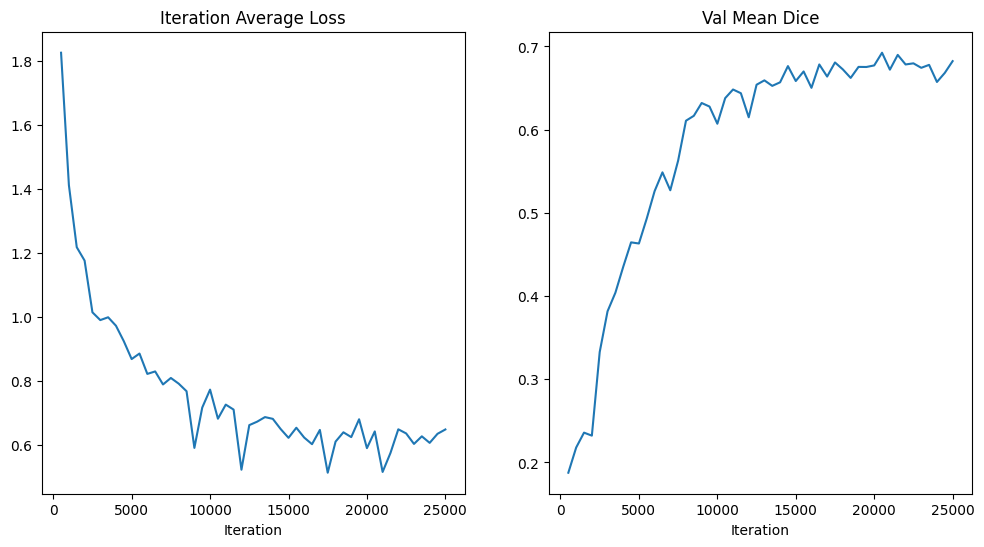

In [27]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [28]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold3_best_metric_model.pth"")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

SyntaxError: EOL while scanning string literal (986798878.py, line 2)

In [29]:
#fold 4
torch.cuda.empty_cache()

In [30]:
# data_dir = "/dataset/"
split_json = "dataset_4.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.00s/it]


image shape: torch.Size([1, 229, 192, 220]), label shape: torch.Size([1, 229, 192, 220])


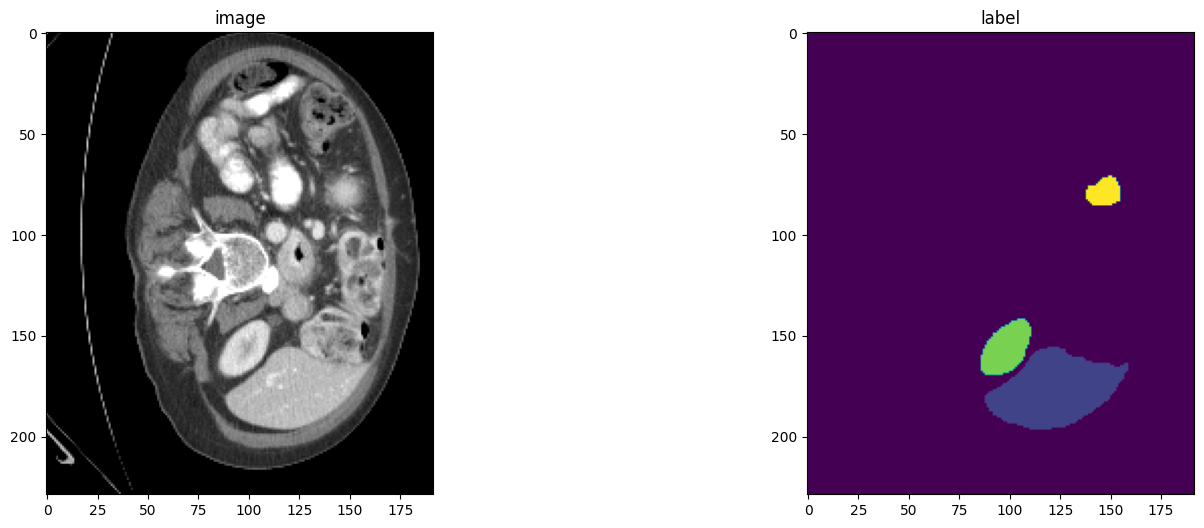

In [31]:
slice_map = {
    "img0001.nii.gz": 125,
    "img0002.nii.gz": 230,
    "img0003.nii.gz": 204,
    "img0004.nii.gz": 204,
    "img0005.nii.gz": 204,
    "img0006.nii.gz": 180,
}

case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [32]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [33]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/unetr", "unetr_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.97163): 100%|█| 24/24 [00:07<00:00,  3.13it/
Training (47 / 25000 Steps) (loss=2.56805): 100%|█| 24/24 [00:07<00:00,  3.30it/
Training (71 / 25000 Steps) (loss=2.54734): 100%|█| 24/24 [00:07<00:00,  3.32it/
Training (95 / 25000 Steps) (loss=2.24373): 100%|█| 24/24 [00:07<00:00,  3.30it/
Training (119 / 25000 Steps) (loss=2.30638): 100%|█| 24/24 [00:07<00:00,  3.25it
Training (143 / 25000 Steps) (loss=2.30453): 100%|█| 24/24 [00:07<00:00,  3.28it
Training (167 / 25000 Steps) (loss=2.28404): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (191 / 25000 Steps) (loss=2.23817): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (215 / 25000 Steps) (loss=2.07563): 100%|█| 24/24 [00:07<00:00,  3.26it
Training (239 / 25000 Steps) (loss=2.28206): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (263 / 25000 Steps) (loss=2.11818): 100%|█| 24/24 [00:07<00:00,  3.26it
Training (287 / 25000 Steps) (loss=2.03826): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.151651069521904 Current Avg. Dice: 0.151651069521904


Training (503 / 25000 Steps) (loss=1.79432): 100%|█| 24/24 [00:10<00:00,  2.20it
Training (527 / 25000 Steps) (loss=1.82487): 100%|█| 24/24 [00:07<00:00,  3.26it
Training (551 / 25000 Steps) (loss=1.80030): 100%|█| 24/24 [00:07<00:00,  3.30it
Training (575 / 25000 Steps) (loss=1.76883): 100%|█| 24/24 [00:07<00:00,  3.32it
Training (599 / 25000 Steps) (loss=1.87388): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (623 / 25000 Steps) (loss=1.72175): 100%|█| 24/24 [00:07<00:00,  3.35it
Training (647 / 25000 Steps) (loss=1.76142): 100%|█| 24/24 [00:07<00:00,  3.32it
Training (671 / 25000 Steps) (loss=1.82326): 100%|█| 24/24 [00:07<00:00,  3.32it
Training (695 / 25000 Steps) (loss=1.80007): 100%|█| 24/24 [00:07<00:00,  3.38it
Training (719 / 25000 Steps) (loss=1.66135): 100%|█| 24/24 [00:07<00:00,  3.33it
Training (743 / 25000 Steps) (loss=1.63353): 100%|█| 24/24 [00:07<00:00,  3.27it
Training (767 / 25000 Steps) (loss=1.71066): 100%|█| 24/24 [00:07<00:00,  3.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.19209825992584229 Current Avg. Dice: 0.19209825992584229


Training (1007 / 25000 Steps) (loss=1.41660): 100%|█| 24/24 [00:10<00:00,  2.22i
Training (1031 / 25000 Steps) (loss=1.43217): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1055 / 25000 Steps) (loss=1.38654): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (1079 / 25000 Steps) (loss=1.40484): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1103 / 25000 Steps) (loss=1.42460): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1127 / 25000 Steps) (loss=1.61819): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (1151 / 25000 Steps) (loss=1.42644): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (1175 / 25000 Steps) (loss=1.54458): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (1199 / 25000 Steps) (loss=1.41759): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (1223 / 25000 Steps) (loss=1.37394): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1247 / 25000 Steps) (loss=1.37134): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1271 / 25000 Steps) (loss=1.34369): 100%|█| 24/24 [00:07<00:00,  3.22i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.22281111776828766 Current Avg. Dice: 0.22281111776828766


Training (1511 / 25000 Steps) (loss=1.35131): 100%|█| 24/24 [00:10<00:00,  2.21i
Training (1535 / 25000 Steps) (loss=1.19097): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (1559 / 25000 Steps) (loss=1.32224): 100%|█| 24/24 [00:07<00:00,  3.25i
Training (1583 / 25000 Steps) (loss=1.27897): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1607 / 25000 Steps) (loss=1.24698): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (1631 / 25000 Steps) (loss=1.46669): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (1655 / 25000 Steps) (loss=1.24542): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (1679 / 25000 Steps) (loss=1.20061): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (1703 / 25000 Steps) (loss=1.26087): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (1727 / 25000 Steps) (loss=1.36502): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (1751 / 25000 Steps) (loss=1.29640): 100%|█| 24/24 [00:07<00:00,  3.14i
Training (1775 / 25000 Steps) (loss=2.03778): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.25991714000701904 Current Avg. Dice: 0.25991714000701904


Training (2015 / 25000 Steps) (loss=1.30153): 100%|█| 24/24 [00:11<00:00,  2.14i
Training (2039 / 25000 Steps) (loss=1.17589): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (2063 / 25000 Steps) (loss=1.09115): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2087 / 25000 Steps) (loss=1.20787): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (2111 / 25000 Steps) (loss=1.21780): 100%|█| 24/24 [00:07<00:00,  3.25i
Training (2135 / 25000 Steps) (loss=1.22146): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (2159 / 25000 Steps) (loss=1.26369): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2183 / 25000 Steps) (loss=1.26657): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (2207 / 25000 Steps) (loss=1.23392): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2231 / 25000 Steps) (loss=1.13671): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (2255 / 25000 Steps) (loss=1.27340): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2279 / 25000 Steps) (loss=0.99610): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.2830081284046173 Current Avg. Dice: 0.2830081284046173


Training (2519 / 25000 Steps) (loss=1.42677): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (2543 / 25000 Steps) (loss=1.18516): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (2567 / 25000 Steps) (loss=1.13874): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (2591 / 25000 Steps) (loss=1.17467): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (2615 / 25000 Steps) (loss=1.14494): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (2639 / 25000 Steps) (loss=1.05443): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (2663 / 25000 Steps) (loss=1.24094): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (2687 / 25000 Steps) (loss=1.22609): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (2711 / 25000 Steps) (loss=1.13707): 100%|█| 24/24 [00:07<00:00,  3.23i
Training (2735 / 25000 Steps) (loss=1.04941): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (2759 / 25000 Steps) (loss=1.10543): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (2783 / 25000 Steps) (loss=1.01279): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.2830081284046173 Current Avg. Dice: 0.2818325459957123


Training (3023 / 25000 Steps) (loss=1.01462): 100%|█| 24/24 [00:10<00:00,  2.32i
Training (3047 / 25000 Steps) (loss=1.06638): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (3071 / 25000 Steps) (loss=1.07000): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (3095 / 25000 Steps) (loss=1.19773): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (3119 / 25000 Steps) (loss=1.19734): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (3143 / 25000 Steps) (loss=0.97636): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3167 / 25000 Steps) (loss=1.01958): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3191 / 25000 Steps) (loss=1.23914): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (3215 / 25000 Steps) (loss=1.13405): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (3239 / 25000 Steps) (loss=1.14311): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3263 / 25000 Steps) (loss=1.09015): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (3287 / 25000 Steps) (loss=1.03300): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.34599387645721436 Current Avg. Dice: 0.34599387645721436


Training (3503 / 25000 Steps) (loss=1.00680): 100%|█| 24/24 [00:10<00:00,  2.20i
Training (3527 / 25000 Steps) (loss=1.06527): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3551 / 25000 Steps) (loss=1.04304): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (3575 / 25000 Steps) (loss=1.01549): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (3599 / 25000 Steps) (loss=1.00226): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (3623 / 25000 Steps) (loss=1.02414): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3647 / 25000 Steps) (loss=1.12159): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (3671 / 25000 Steps) (loss=0.99566): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3695 / 25000 Steps) (loss=0.94366): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (3719 / 25000 Steps) (loss=0.96567): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (3743 / 25000 Steps) (loss=1.03562): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (3767 / 25000 Steps) (loss=0.99010): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.34599387645721436 Current Avg. Dice: 0.341357558965683


Training (4007 / 25000 Steps) (loss=0.98685): 100%|█| 24/24 [00:10<00:00,  2.33i
Training (4031 / 25000 Steps) (loss=0.90297): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (4055 / 25000 Steps) (loss=0.96856): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (4079 / 25000 Steps) (loss=0.99679): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (4103 / 25000 Steps) (loss=1.07929): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (4127 / 25000 Steps) (loss=1.05735): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (4151 / 25000 Steps) (loss=0.98397): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (4175 / 25000 Steps) (loss=1.07331): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (4199 / 25000 Steps) (loss=1.06543): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (4223 / 25000 Steps) (loss=0.95885): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4247 / 25000 Steps) (loss=0.90843): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4271 / 25000 Steps) (loss=0.97843): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3592561185359955 Current Avg. Dice: 0.3592561185359955


Training (4511 / 25000 Steps) (loss=0.94026): 100%|█| 24/24 [00:10<00:00,  2.22i
Training (4535 / 25000 Steps) (loss=0.98650): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (4559 / 25000 Steps) (loss=1.03504): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (4583 / 25000 Steps) (loss=0.96329): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (4607 / 25000 Steps) (loss=0.92172): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (4631 / 25000 Steps) (loss=0.97161): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (4655 / 25000 Steps) (loss=0.85185): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (4679 / 25000 Steps) (loss=1.32898): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (4703 / 25000 Steps) (loss=0.90550): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (4727 / 25000 Steps) (loss=0.90959): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (4751 / 25000 Steps) (loss=0.99366): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (4775 / 25000 Steps) (loss=0.90425): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4344482123851776 Current Avg. Dice: 0.4344482123851776


Training (5015 / 25000 Steps) (loss=0.94791): 100%|█| 24/24 [00:10<00:00,  2.25i
Training (5039 / 25000 Steps) (loss=0.86918): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5063 / 25000 Steps) (loss=0.93663): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5087 / 25000 Steps) (loss=0.88661): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5111 / 25000 Steps) (loss=0.87955): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5135 / 25000 Steps) (loss=0.88541): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (5159 / 25000 Steps) (loss=1.16443): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (5183 / 25000 Steps) (loss=0.98987): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (5207 / 25000 Steps) (loss=0.95821): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (5231 / 25000 Steps) (loss=0.90005): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5255 / 25000 Steps) (loss=1.10601): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (5279 / 25000 Steps) (loss=1.52834): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48369064927101135 Current Avg. Dice: 0.48369064927101135


Training (5519 / 25000 Steps) (loss=0.87881): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (5543 / 25000 Steps) (loss=0.90597): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (5567 / 25000 Steps) (loss=0.87874): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (5591 / 25000 Steps) (loss=1.01174): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (5615 / 25000 Steps) (loss=0.99074): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (5639 / 25000 Steps) (loss=0.89933): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (5663 / 25000 Steps) (loss=0.86792): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (5687 / 25000 Steps) (loss=0.82868): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (5711 / 25000 Steps) (loss=0.89695): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (5735 / 25000 Steps) (loss=0.96177): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (5759 / 25000 Steps) (loss=0.88190): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (5783 / 25000 Steps) (loss=0.92207): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5541583299636841 Current Avg. Dice: 0.5541583299636841


Training (6023 / 25000 Steps) (loss=1.01892): 100%|█| 24/24 [00:10<00:00,  2.23i
Training (6047 / 25000 Steps) (loss=0.88020): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6071 / 25000 Steps) (loss=0.85737): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (6095 / 25000 Steps) (loss=0.73825): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (6119 / 25000 Steps) (loss=0.80282): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (6143 / 25000 Steps) (loss=0.83948): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6167 / 25000 Steps) (loss=0.94562): 100%|█| 24/24 [00:07<00:00,  3.25i
Training (6191 / 25000 Steps) (loss=0.88743): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (6215 / 25000 Steps) (loss=0.89870): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (6239 / 25000 Steps) (loss=1.48398): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (6263 / 25000 Steps) (loss=1.06018): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (6287 / 25000 Steps) (loss=0.95613): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5541583299636841 Current Avg. Dice: 0.5251403450965881


Training (6503 / 25000 Steps) (loss=0.86532): 100%|█| 24/24 [00:10<00:00,  2.31i
Training (6527 / 25000 Steps) (loss=0.92037): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (6551 / 25000 Steps) (loss=0.81516): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (6575 / 25000 Steps) (loss=0.97745): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (6599 / 25000 Steps) (loss=0.91550): 100%|█| 24/24 [00:07<00:00,  3.42i
Training (6623 / 25000 Steps) (loss=0.87843): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (6647 / 25000 Steps) (loss=0.90008): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (6671 / 25000 Steps) (loss=0.92877): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (6695 / 25000 Steps) (loss=0.89886): 100%|█| 24/24 [00:07<00:00,  3.26i
Training (6719 / 25000 Steps) (loss=0.81857): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (6743 / 25000 Steps) (loss=1.35845): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (6767 / 25000 Steps) (loss=0.83852): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5893539786338806 Current Avg. Dice: 0.5893539786338806


Training (7007 / 25000 Steps) (loss=0.87370): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (7031 / 25000 Steps) (loss=0.84681): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7055 / 25000 Steps) (loss=0.80874): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (7079 / 25000 Steps) (loss=0.85744): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (7103 / 25000 Steps) (loss=0.80607): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7127 / 25000 Steps) (loss=0.78279): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (7151 / 25000 Steps) (loss=0.90039): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (7175 / 25000 Steps) (loss=0.81127): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7199 / 25000 Steps) (loss=0.90004): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7223 / 25000 Steps) (loss=0.84748): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7247 / 25000 Steps) (loss=0.87299): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (7271 / 25000 Steps) (loss=0.73288): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6104587912559509 Current Avg. Dice: 0.6104587912559509


Training (7511 / 25000 Steps) (loss=1.29938): 100%|█| 24/24 [00:10<00:00,  2.26i
Training (7535 / 25000 Steps) (loss=0.99858): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (7559 / 25000 Steps) (loss=0.86114): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (7583 / 25000 Steps) (loss=0.86402): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (7607 / 25000 Steps) (loss=0.77397): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (7631 / 25000 Steps) (loss=0.84392): 100%|█| 24/24 [00:07<00:00,  3.35i
Training (7655 / 25000 Steps) (loss=0.65289): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (7679 / 25000 Steps) (loss=0.72594): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (7703 / 25000 Steps) (loss=0.91011): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (7727 / 25000 Steps) (loss=0.78283): 100%|█| 24/24 [00:07<00:00,  3.23i
Training (7751 / 25000 Steps) (loss=0.83727): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (7775 / 25000 Steps) (loss=0.71967): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6281478404998779 Current Avg. Dice: 0.6281478404998779


Training (8015 / 25000 Steps) (loss=0.82459): 100%|█| 24/24 [00:10<00:00,  2.21i
Training (8039 / 25000 Steps) (loss=0.79349): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (8063 / 25000 Steps) (loss=0.81857): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (8087 / 25000 Steps) (loss=0.82336): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8111 / 25000 Steps) (loss=0.77185): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (8135 / 25000 Steps) (loss=0.89429): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (8159 / 25000 Steps) (loss=0.74399): 100%|█| 24/24 [00:07<00:00,  3.34i
Training (8183 / 25000 Steps) (loss=0.84871): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (8207 / 25000 Steps) (loss=0.89110): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (8231 / 25000 Steps) (loss=0.81708): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (8255 / 25000 Steps) (loss=0.76096): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (8279 / 25000 Steps) (loss=0.80947): 100%|█| 24/24 [00:07<00:00,  3.38i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6863759160041809 Current Avg. Dice: 0.6863759160041809


Training (8519 / 25000 Steps) (loss=0.68809): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (8543 / 25000 Steps) (loss=0.87609): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8567 / 25000 Steps) (loss=0.76166): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (8591 / 25000 Steps) (loss=0.67500): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (8615 / 25000 Steps) (loss=0.69120): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (8639 / 25000 Steps) (loss=0.81714): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8663 / 25000 Steps) (loss=0.78839): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8687 / 25000 Steps) (loss=0.75190): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (8711 / 25000 Steps) (loss=0.63123): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8735 / 25000 Steps) (loss=0.84486): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (8759 / 25000 Steps) (loss=0.76902): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8783 / 25000 Steps) (loss=0.66489): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6863759160041809 Current Avg. Dice: 0.6852100491523743


Training (9023 / 25000 Steps) (loss=0.69243): 100%|█| 24/24 [00:10<00:00,  2.29i
Training (9047 / 25000 Steps) (loss=0.76311): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (9071 / 25000 Steps) (loss=0.62617): 100%|█| 24/24 [00:07<00:00,  3.37i
Training (9095 / 25000 Steps) (loss=1.06758): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9119 / 25000 Steps) (loss=0.93463): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9143 / 25000 Steps) (loss=0.64715): 100%|█| 24/24 [00:07<00:00,  3.28i
Training (9167 / 25000 Steps) (loss=0.86852): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (9191 / 25000 Steps) (loss=0.60843): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (9215 / 25000 Steps) (loss=0.78698): 100%|█| 24/24 [00:07<00:00,  3.27i
Training (9239 / 25000 Steps) (loss=0.77895): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (9263 / 25000 Steps) (loss=0.78681): 100%|█| 24/24 [00:07<00:00,  3.41i
Training (9287 / 25000 Steps) (loss=0.79602): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6952844262123108 Current Avg. Dice: 0.6952844262123108


Training (9503 / 25000 Steps) (loss=0.67919): 100%|█| 24/24 [00:10<00:00,  2.24i
Training (9527 / 25000 Steps) (loss=0.64965): 100%|█| 24/24 [00:07<00:00,  3.33i
Training (9551 / 25000 Steps) (loss=0.80897): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (9575 / 25000 Steps) (loss=0.83287): 100%|█| 24/24 [00:07<00:00,  3.31i
Training (9599 / 25000 Steps) (loss=0.73931): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (9623 / 25000 Steps) (loss=0.89635): 100%|█| 24/24 [00:07<00:00,  3.40i
Training (9647 / 25000 Steps) (loss=0.69013): 100%|█| 24/24 [00:07<00:00,  3.29i
Training (9671 / 25000 Steps) (loss=0.74435): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (9695 / 25000 Steps) (loss=0.71501): 100%|█| 24/24 [00:07<00:00,  3.36i
Training (9719 / 25000 Steps) (loss=0.69416): 100%|█| 24/24 [00:07<00:00,  3.30i
Training (9743 / 25000 Steps) (loss=0.93563): 100%|█| 24/24 [00:07<00:00,  3.39i
Training (9767 / 25000 Steps) (loss=0.72185): 100%|█| 24/24 [00:07<00:00,  3.32i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7178542017936707 Current Avg. Dice: 0.7178542017936707


Training (10007 / 25000 Steps) (loss=0.79195): 100%|█| 24/24 [00:10<00:00,  2.22
Training (10031 / 25000 Steps) (loss=0.68996): 100%|█| 24/24 [00:07<00:00,  3.23
Training (10055 / 25000 Steps) (loss=0.72238): 100%|█| 24/24 [00:07<00:00,  3.41
Training (10079 / 25000 Steps) (loss=0.79287): 100%|█| 24/24 [00:07<00:00,  3.36
Training (10103 / 25000 Steps) (loss=0.73056): 100%|█| 24/24 [00:07<00:00,  3.30
Training (10127 / 25000 Steps) (loss=0.75300): 100%|█| 24/24 [00:07<00:00,  3.27
Training (10151 / 25000 Steps) (loss=0.56920): 100%|█| 24/24 [00:07<00:00,  3.39
Training (10175 / 25000 Steps) (loss=0.83990): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10199 / 25000 Steps) (loss=0.71032): 100%|█| 24/24 [00:07<00:00,  3.33
Training (10223 / 25000 Steps) (loss=0.76962): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10247 / 25000 Steps) (loss=0.79108): 100%|█| 24/24 [00:07<00:00,  3.30
Training (10271 / 25000 Steps) (loss=0.76175): 100%|█| 24/24 [00:07<00:00,  3.29
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7178542017936707 Current Avg. Dice: 0.7111510634422302


Training (10511 / 25000 Steps) (loss=0.46805): 100%|█| 24/24 [00:10<00:00,  2.28
Training (10535 / 25000 Steps) (loss=0.67934): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10559 / 25000 Steps) (loss=0.72593): 100%|█| 24/24 [00:07<00:00,  3.30
Training (10583 / 25000 Steps) (loss=0.82442): 100%|█| 24/24 [00:07<00:00,  3.37
Training (10607 / 25000 Steps) (loss=0.89918): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10631 / 25000 Steps) (loss=0.66616): 100%|█| 24/24 [00:07<00:00,  3.39
Training (10655 / 25000 Steps) (loss=0.54923): 100%|█| 24/24 [00:07<00:00,  3.32
Training (10679 / 25000 Steps) (loss=0.89742): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10703 / 25000 Steps) (loss=0.68012): 100%|█| 24/24 [00:07<00:00,  3.34
Training (10727 / 25000 Steps) (loss=0.90053): 100%|█| 24/24 [00:07<00:00,  3.32
Training (10751 / 25000 Steps) (loss=0.65029): 100%|█| 24/24 [00:07<00:00,  3.38
Training (10775 / 25000 Steps) (loss=0.65236): 100%|█| 24/24 [00:07<00:00,  3.32
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7178542017936707 Current Avg. Dice: 0.6760442852973938


Training (11015 / 25000 Steps) (loss=0.76511): 100%|█| 24/24 [00:10<00:00,  2.29
Training (11039 / 25000 Steps) (loss=0.73927): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11063 / 25000 Steps) (loss=0.61678): 100%|█| 24/24 [00:07<00:00,  3.41
Training (11087 / 25000 Steps) (loss=0.93749): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11111 / 25000 Steps) (loss=0.83522): 100%|█| 24/24 [00:07<00:00,  3.30
Training (11135 / 25000 Steps) (loss=1.05470): 100%|█| 24/24 [00:07<00:00,  3.42
Training (11159 / 25000 Steps) (loss=0.76180): 100%|█| 24/24 [00:07<00:00,  3.39
Training (11183 / 25000 Steps) (loss=0.67449): 100%|█| 24/24 [00:07<00:00,  3.21
Training (11207 / 25000 Steps) (loss=0.90334): 100%|█| 24/24 [00:07<00:00,  3.29
Training (11231 / 25000 Steps) (loss=0.86442): 100%|█| 24/24 [00:07<00:00,  3.26
Training (11255 / 25000 Steps) (loss=0.73288): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11279 / 25000 Steps) (loss=0.52193): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7178542017936707 Current Avg. Dice: 0.6991044878959656


Training (11519 / 25000 Steps) (loss=0.68797): 100%|█| 24/24 [00:10<00:00,  2.34
Training (11543 / 25000 Steps) (loss=0.79132): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11567 / 25000 Steps) (loss=0.65382): 100%|█| 24/24 [00:07<00:00,  3.35
Training (11591 / 25000 Steps) (loss=0.77989): 100%|█| 24/24 [00:07<00:00,  3.39
Training (11615 / 25000 Steps) (loss=0.53779): 100%|█| 24/24 [00:07<00:00,  3.31
Training (11639 / 25000 Steps) (loss=0.75522): 100%|█| 24/24 [00:07<00:00,  3.36
Training (11663 / 25000 Steps) (loss=0.61561): 100%|█| 24/24 [00:07<00:00,  3.27
Training (11687 / 25000 Steps) (loss=0.71253): 100%|█| 24/24 [00:07<00:00,  3.31
Training (11711 / 25000 Steps) (loss=0.67897): 100%|█| 24/24 [00:07<00:00,  3.34
Training (11735 / 25000 Steps) (loss=0.82691): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11759 / 25000 Steps) (loss=0.77411): 100%|█| 24/24 [00:07<00:00,  3.33
Training (11783 / 25000 Steps) (loss=0.78882): 100%|█| 24/24 [00:07<00:00,  3.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7178542017936707 Current Avg. Dice: 0.7157567143440247


Training (12023 / 25000 Steps) (loss=0.74118): 100%|█| 24/24 [00:10<00:00,  2.27
Training (12047 / 25000 Steps) (loss=0.78825): 100%|█| 24/24 [00:07<00:00,  3.38
Training (12071 / 25000 Steps) (loss=0.64573): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12095 / 25000 Steps) (loss=0.75410): 100%|█| 24/24 [00:07<00:00,  3.38
Training (12119 / 25000 Steps) (loss=0.74227): 100%|█| 24/24 [00:07<00:00,  3.24
Training (12143 / 25000 Steps) (loss=0.66378): 100%|█| 24/24 [00:07<00:00,  3.29
Training (12167 / 25000 Steps) (loss=0.74200): 100%|█| 24/24 [00:07<00:00,  3.27
Training (12191 / 25000 Steps) (loss=0.79714): 100%|█| 24/24 [00:07<00:00,  3.38
Training (12215 / 25000 Steps) (loss=0.80975): 100%|█| 24/24 [00:07<00:00,  3.28
Training (12239 / 25000 Steps) (loss=0.60788): 100%|█| 24/24 [00:07<00:00,  3.28
Training (12263 / 25000 Steps) (loss=0.75020): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12287 / 25000 Steps) (loss=0.78751): 100%|█| 24/24 [00:07<00:00,  3.34
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7178542017936707 Current Avg. Dice: 0.7130724787712097


Training (12503 / 25000 Steps) (loss=0.77233): 100%|█| 24/24 [00:10<00:00,  2.28
Training (12527 / 25000 Steps) (loss=0.85773): 100%|█| 24/24 [00:07<00:00,  3.35
Training (12551 / 25000 Steps) (loss=0.60582): 100%|█| 24/24 [00:07<00:00,  3.31
Training (12575 / 25000 Steps) (loss=0.58311): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12599 / 25000 Steps) (loss=0.62578): 100%|█| 24/24 [00:07<00:00,  3.27
Training (12623 / 25000 Steps) (loss=0.87610): 100%|█| 24/24 [00:07<00:00,  3.32
Training (12647 / 25000 Steps) (loss=0.87285): 100%|█| 24/24 [00:07<00:00,  3.39
Training (12671 / 25000 Steps) (loss=0.63906): 100%|█| 24/24 [00:07<00:00,  3.40
Training (12695 / 25000 Steps) (loss=0.75053): 100%|█| 24/24 [00:07<00:00,  3.33
Training (12719 / 25000 Steps) (loss=0.68324): 100%|█| 24/24 [00:07<00:00,  3.37
Training (12743 / 25000 Steps) (loss=0.76110): 100%|█| 24/24 [00:07<00:00,  3.41
Training (12767 / 25000 Steps) (loss=0.74700): 100%|█| 24/24 [00:07<00:00,  3.36
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7295759320259094 Current Avg. Dice: 0.7295759320259094


Training (13007 / 25000 Steps) (loss=0.51963): 100%|█| 24/24 [00:10<00:00,  2.24
Training (13031 / 25000 Steps) (loss=0.54945): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13055 / 25000 Steps) (loss=0.62630): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13079 / 25000 Steps) (loss=0.85263): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13103 / 25000 Steps) (loss=0.75945): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13127 / 25000 Steps) (loss=0.73022): 100%|█| 24/24 [00:07<00:00,  3.36
Training (13151 / 25000 Steps) (loss=0.85956): 100%|█| 24/24 [00:07<00:00,  3.28
Training (13175 / 25000 Steps) (loss=0.77663): 100%|█| 24/24 [00:07<00:00,  3.38
Training (13199 / 25000 Steps) (loss=0.69043): 100%|█| 24/24 [00:07<00:00,  3.27
Training (13223 / 25000 Steps) (loss=0.47393): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13247 / 25000 Steps) (loss=0.82857): 100%|█| 24/24 [00:07<00:00,  3.32
Training (13271 / 25000 Steps) (loss=0.67436): 100%|█| 24/24 [00:07<00:00,  3.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7295759320259094 Current Avg. Dice: 0.7112221121788025


Training (13511 / 25000 Steps) (loss=0.75539): 100%|█| 24/24 [00:10<00:00,  2.33
Training (13535 / 25000 Steps) (loss=0.54017): 100%|█| 24/24 [00:07<00:00,  3.38
Training (13559 / 25000 Steps) (loss=0.51647): 100%|█| 24/24 [00:07<00:00,  3.35
Training (13583 / 25000 Steps) (loss=0.70744): 100%|█| 24/24 [00:07<00:00,  3.42
Training (13607 / 25000 Steps) (loss=0.68654): 100%|█| 24/24 [00:07<00:00,  3.40
Training (13631 / 25000 Steps) (loss=0.63201): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13655 / 25000 Steps) (loss=0.69403): 100%|█| 24/24 [00:07<00:00,  3.27
Training (13679 / 25000 Steps) (loss=0.66831): 100%|█| 24/24 [00:07<00:00,  3.31
Training (13703 / 25000 Steps) (loss=0.97663): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13727 / 25000 Steps) (loss=0.67604): 100%|█| 24/24 [00:07<00:00,  3.39
Training (13751 / 25000 Steps) (loss=0.79035): 100%|█| 24/24 [00:07<00:00,  3.33
Training (13775 / 25000 Steps) (loss=0.58911): 100%|█| 24/24 [00:07<00:00,  3.30
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7295759320259094 Current Avg. Dice: 0.6960826516151428


Training (14015 / 25000 Steps) (loss=0.54129): 100%|█| 24/24 [00:10<00:00,  2.34
Training (14039 / 25000 Steps) (loss=0.53929): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14063 / 25000 Steps) (loss=0.74975): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14087 / 25000 Steps) (loss=0.55240): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14111 / 25000 Steps) (loss=0.68085): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14135 / 25000 Steps) (loss=0.60532): 100%|█| 24/24 [00:07<00:00,  3.35
Training (14159 / 25000 Steps) (loss=0.91411): 100%|█| 24/24 [00:07<00:00,  3.31
Training (14183 / 25000 Steps) (loss=0.47093): 100%|█| 24/24 [00:07<00:00,  3.33
Training (14207 / 25000 Steps) (loss=0.86782): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14231 / 25000 Steps) (loss=0.73016): 100%|█| 24/24 [00:07<00:00,  3.36
Training (14255 / 25000 Steps) (loss=0.64275): 100%|█| 24/24 [00:07<00:00,  3.35
Training (14279 / 25000 Steps) (loss=0.67907): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7295759320259094 Current Avg. Dice: 0.7072437405586243


Training (14519 / 25000 Steps) (loss=0.49558): 100%|█| 24/24 [00:10<00:00,  2.29
Training (14543 / 25000 Steps) (loss=0.56379): 100%|█| 24/24 [00:07<00:00,  3.36
Training (14567 / 25000 Steps) (loss=0.62553): 100%|█| 24/24 [00:07<00:00,  3.37
Training (14591 / 25000 Steps) (loss=0.65060): 100%|█| 24/24 [00:07<00:00,  3.36
Training (14615 / 25000 Steps) (loss=0.67216): 100%|█| 24/24 [00:07<00:00,  3.39
Training (14639 / 25000 Steps) (loss=0.55235): 100%|█| 24/24 [00:07<00:00,  3.34
Training (14663 / 25000 Steps) (loss=0.80114): 100%|█| 24/24 [00:07<00:00,  3.32
Training (14687 / 25000 Steps) (loss=0.83333): 100%|█| 24/24 [00:07<00:00,  3.38
Training (14711 / 25000 Steps) (loss=0.87282): 100%|█| 24/24 [00:07<00:00,  3.22
Training (14735 / 25000 Steps) (loss=0.63204): 100%|█| 24/24 [00:07<00:00,  3.27
Training (14759 / 25000 Steps) (loss=0.53076): 100%|█| 24/24 [00:07<00:00,  3.37
Training (14783 / 25000 Steps) (loss=0.76284): 100%|█| 24/24 [00:07<00:00,  3.29
Training (14807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7298211455345154 Current Avg. Dice: 0.7298211455345154


Training (15023 / 25000 Steps) (loss=0.68627): 100%|█| 24/24 [00:10<00:00,  2.25
Training (15047 / 25000 Steps) (loss=0.78089): 100%|█| 24/24 [00:07<00:00,  3.39
Training (15071 / 25000 Steps) (loss=0.71124): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15095 / 25000 Steps) (loss=0.65736): 100%|█| 24/24 [00:07<00:00,  3.30
Training (15119 / 25000 Steps) (loss=0.61848): 100%|█| 24/24 [00:07<00:00,  3.38
Training (15143 / 25000 Steps) (loss=0.59092): 100%|█| 24/24 [00:07<00:00,  3.37
Training (15167 / 25000 Steps) (loss=0.46771): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15191 / 25000 Steps) (loss=0.67897): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15215 / 25000 Steps) (loss=0.71379): 100%|█| 24/24 [00:07<00:00,  3.29
Training (15239 / 25000 Steps) (loss=0.66905): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15263 / 25000 Steps) (loss=0.55872): 100%|█| 24/24 [00:07<00:00,  3.27
Training (15287 / 25000 Steps) (loss=0.47284): 100%|█| 24/24 [00:07<00:00,  3.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7298211455345154 Current Avg. Dice: 0.7292093634605408


Training (15503 / 25000 Steps) (loss=0.67755): 100%|█| 24/24 [00:10<00:00,  2.34
Training (15527 / 25000 Steps) (loss=0.53196): 100%|█| 24/24 [00:07<00:00,  3.35
Training (15551 / 25000 Steps) (loss=0.74810): 100%|█| 24/24 [00:07<00:00,  3.29
Training (15575 / 25000 Steps) (loss=0.88056): 100%|█| 24/24 [00:07<00:00,  3.22
Training (15599 / 25000 Steps) (loss=0.75417): 100%|█| 24/24 [00:07<00:00,  3.32
Training (15623 / 25000 Steps) (loss=0.71166): 100%|█| 24/24 [00:07<00:00,  3.31
Training (15647 / 25000 Steps) (loss=0.71250): 100%|█| 24/24 [00:07<00:00,  3.30
Training (15671 / 25000 Steps) (loss=0.62983): 100%|█| 24/24 [00:07<00:00,  3.15
Training (15695 / 25000 Steps) (loss=0.56171): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15719 / 25000 Steps) (loss=0.87322): 100%|█| 24/24 [00:07<00:00,  3.34
Training (15743 / 25000 Steps) (loss=0.69307): 100%|█| 24/24 [00:07<00:00,  3.40
Training (15767 / 25000 Steps) (loss=0.89172): 100%|█| 24/24 [00:07<00:00,  3.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7298211455345154 Current Avg. Dice: 0.7249581217765808


Training (16007 / 25000 Steps) (loss=0.62092): 100%|█| 24/24 [00:10<00:00,  2.28
Training (16031 / 25000 Steps) (loss=0.45408): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16055 / 25000 Steps) (loss=0.47968): 100%|█| 24/24 [00:07<00:00,  3.37
Training (16079 / 25000 Steps) (loss=0.76743): 100%|█| 24/24 [00:07<00:00,  3.35
Training (16103 / 25000 Steps) (loss=0.67878): 100%|█| 24/24 [00:07<00:00,  3.27
Training (16127 / 25000 Steps) (loss=0.67587): 100%|█| 24/24 [00:07<00:00,  3.29
Training (16151 / 25000 Steps) (loss=0.63783): 100%|█| 24/24 [00:07<00:00,  3.23
Training (16175 / 25000 Steps) (loss=0.64302): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16199 / 25000 Steps) (loss=0.73329): 100%|█| 24/24 [00:07<00:00,  3.37
Training (16223 / 25000 Steps) (loss=0.69504): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16247 / 25000 Steps) (loss=0.70522): 100%|█| 24/24 [00:07<00:00,  3.30
Training (16271 / 25000 Steps) (loss=0.85381): 100%|█| 24/24 [00:07<00:00,  3.31
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7298211455345154 Current Avg. Dice: 0.7296096682548523


Training (16511 / 25000 Steps) (loss=0.83615): 100%|█| 24/24 [00:10<00:00,  2.22
Training (16535 / 25000 Steps) (loss=0.51667): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16559 / 25000 Steps) (loss=0.41979): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16583 / 25000 Steps) (loss=0.83951): 100%|█| 24/24 [00:07<00:00,  3.29
Training (16607 / 25000 Steps) (loss=0.70716): 100%|█| 24/24 [00:07<00:00,  3.34
Training (16631 / 25000 Steps) (loss=0.79048): 100%|█| 24/24 [00:07<00:00,  3.40
Training (16655 / 25000 Steps) (loss=0.54050): 100%|█| 24/24 [00:07<00:00,  3.38
Training (16679 / 25000 Steps) (loss=0.52101): 100%|█| 24/24 [00:07<00:00,  3.33
Training (16703 / 25000 Steps) (loss=0.74021): 100%|█| 24/24 [00:07<00:00,  3.37
Training (16727 / 25000 Steps) (loss=0.66634): 100%|█| 24/24 [00:07<00:00,  3.29
Training (16751 / 25000 Steps) (loss=0.66605): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16775 / 25000 Steps) (loss=0.79914): 100%|█| 24/24 [00:07<00:00,  3.32
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7298211455345154 Current Avg. Dice: 0.7185000777244568


Training (17015 / 25000 Steps) (loss=0.57773): 100%|█| 24/24 [00:10<00:00,  2.29
Training (17039 / 25000 Steps) (loss=0.66669): 100%|█| 24/24 [00:07<00:00,  3.27
Training (17063 / 25000 Steps) (loss=0.48151): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17087 / 25000 Steps) (loss=0.60487): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17111 / 25000 Steps) (loss=0.94740): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17135 / 25000 Steps) (loss=0.75376): 100%|█| 24/24 [00:07<00:00,  3.34
Training (17159 / 25000 Steps) (loss=0.65262): 100%|█| 24/24 [00:07<00:00,  3.37
Training (17183 / 25000 Steps) (loss=0.52929): 100%|█| 24/24 [00:07<00:00,  3.16
Training (17207 / 25000 Steps) (loss=0.66189): 100%|█| 24/24 [00:07<00:00,  3.36
Training (17231 / 25000 Steps) (loss=0.71376): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17255 / 25000 Steps) (loss=0.56624): 100%|█| 24/24 [00:07<00:00,  3.35
Training (17279 / 25000 Steps) (loss=0.67658): 100%|█| 24/24 [00:07<00:00,  3.38
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7298211455345154 Current Avg. Dice: 0.7132532596588135


Training (17519 / 25000 Steps) (loss=0.62957): 100%|█| 24/24 [00:10<00:00,  2.32
Training (17543 / 25000 Steps) (loss=0.59957): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17567 / 25000 Steps) (loss=0.67591): 100%|█| 24/24 [00:07<00:00,  3.34
Training (17591 / 25000 Steps) (loss=0.75559): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17615 / 25000 Steps) (loss=0.62106): 100%|█| 24/24 [00:07<00:00,  3.28
Training (17639 / 25000 Steps) (loss=0.71011): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17663 / 25000 Steps) (loss=0.54395): 100%|█| 24/24 [00:07<00:00,  3.31
Training (17687 / 25000 Steps) (loss=0.55856): 100%|█| 24/24 [00:07<00:00,  3.28
Training (17711 / 25000 Steps) (loss=0.79864): 100%|█| 24/24 [00:07<00:00,  3.40
Training (17735 / 25000 Steps) (loss=0.57943): 100%|█| 24/24 [00:07<00:00,  3.28
Training (17759 / 25000 Steps) (loss=0.71452): 100%|█| 24/24 [00:07<00:00,  3.25
Training (17783 / 25000 Steps) (loss=0.68697): 100%|█| 24/24 [00:07<00:00,  3.29
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7427684664726257 Current Avg. Dice: 0.7427684664726257


Training (18023 / 25000 Steps) (loss=0.65341): 100%|█| 24/24 [00:10<00:00,  2.21
Training (18047 / 25000 Steps) (loss=0.64320): 100%|█| 24/24 [00:07<00:00,  3.28
Training (18071 / 25000 Steps) (loss=0.50273): 100%|█| 24/24 [00:07<00:00,  3.26
Training (18095 / 25000 Steps) (loss=0.73791): 100%|█| 24/24 [00:07<00:00,  3.24
Training (18119 / 25000 Steps) (loss=0.70513): 100%|█| 24/24 [00:07<00:00,  3.27
Training (18143 / 25000 Steps) (loss=0.72579): 100%|█| 24/24 [00:07<00:00,  3.23
Training (18167 / 25000 Steps) (loss=0.67602): 100%|█| 24/24 [00:07<00:00,  3.24
Training (18191 / 25000 Steps) (loss=0.46508): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18215 / 25000 Steps) (loss=0.64001): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18239 / 25000 Steps) (loss=0.56339): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18263 / 25000 Steps) (loss=0.63557): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18287 / 25000 Steps) (loss=0.65430): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7471607327461243 Current Avg. Dice: 0.7471607327461243


Training (18503 / 25000 Steps) (loss=0.58496): 100%|█| 24/24 [00:11<00:00,  2.17
Training (18527 / 25000 Steps) (loss=0.53206): 100%|█| 24/24 [00:07<00:00,  3.32
Training (18551 / 25000 Steps) (loss=0.73563): 100%|█| 24/24 [00:07<00:00,  3.24
Training (18575 / 25000 Steps) (loss=0.69953): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18599 / 25000 Steps) (loss=0.63526): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18623 / 25000 Steps) (loss=0.61657): 100%|█| 24/24 [00:07<00:00,  3.30
Training (18647 / 25000 Steps) (loss=0.58972): 100%|█| 24/24 [00:07<00:00,  3.24
Training (18671 / 25000 Steps) (loss=0.62447): 100%|█| 24/24 [00:07<00:00,  3.18
Training (18695 / 25000 Steps) (loss=0.59076): 100%|█| 24/24 [00:07<00:00,  3.26
Training (18719 / 25000 Steps) (loss=0.68734): 100%|█| 24/24 [00:07<00:00,  3.34
Training (18743 / 25000 Steps) (loss=0.59468): 100%|█| 24/24 [00:07<00:00,  3.28
Training (18767 / 25000 Steps) (loss=0.65177): 100%|█| 24/24 [00:07<00:00,  3.37
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7471607327461243 Current Avg. Dice: 0.7299484610557556


Training (19007 / 25000 Steps) (loss=0.74495): 100%|█| 24/24 [00:10<00:00,  2.26
Training (19031 / 25000 Steps) (loss=0.40604): 100%|█| 24/24 [00:07<00:00,  3.34
Training (19055 / 25000 Steps) (loss=0.53509): 100%|█| 24/24 [00:07<00:00,  3.28
Training (19079 / 25000 Steps) (loss=0.56208): 100%|█| 24/24 [00:07<00:00,  3.33
Training (19103 / 25000 Steps) (loss=0.76184): 100%|█| 24/24 [00:07<00:00,  3.33
Training (19127 / 25000 Steps) (loss=0.63673): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19151 / 25000 Steps) (loss=0.42203): 100%|█| 24/24 [00:07<00:00,  3.25
Training (19175 / 25000 Steps) (loss=0.59419): 100%|█| 24/24 [00:07<00:00,  3.28
Training (19199 / 25000 Steps) (loss=0.62314): 100%|█| 24/24 [00:07<00:00,  3.30
Training (19223 / 25000 Steps) (loss=0.66174): 100%|█| 24/24 [00:07<00:00,  3.32
Training (19247 / 25000 Steps) (loss=0.60876): 100%|█| 24/24 [00:07<00:00,  3.29
Training (19271 / 25000 Steps) (loss=0.61060): 100%|█| 24/24 [00:07<00:00,  3.26
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7471607327461243 Current Avg. Dice: 0.7201563715934753


Training (19511 / 25000 Steps) (loss=0.60008): 100%|█| 24/24 [00:10<00:00,  2.28
Training (19535 / 25000 Steps) (loss=0.66603): 100%|█| 24/24 [00:07<00:00,  3.28
Training (19559 / 25000 Steps) (loss=0.59356): 100%|█| 24/24 [00:07<00:00,  3.27
Training (19583 / 25000 Steps) (loss=0.77342): 100%|█| 24/24 [00:07<00:00,  3.21
Training (19607 / 25000 Steps) (loss=0.62468): 100%|█| 24/24 [00:07<00:00,  3.20
Training (19631 / 25000 Steps) (loss=0.60975): 100%|█| 24/24 [00:07<00:00,  3.24
Training (19655 / 25000 Steps) (loss=0.82542): 100%|█| 24/24 [00:07<00:00,  3.16
Training (19679 / 25000 Steps) (loss=0.68391): 100%|█| 24/24 [00:07<00:00,  3.24
Training (19703 / 25000 Steps) (loss=0.63873): 100%|█| 24/24 [00:07<00:00,  3.25
Training (19727 / 25000 Steps) (loss=0.71305): 100%|█| 24/24 [00:07<00:00,  3.31
Training (19751 / 25000 Steps) (loss=0.70480): 100%|█| 24/24 [00:07<00:00,  3.28
Training (19775 / 25000 Steps) (loss=0.81543): 100%|█| 24/24 [00:07<00:00,  3.33
Training (19799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7491791248321533 Current Avg. Dice: 0.7491791248321533


Training (20015 / 25000 Steps) (loss=0.67441): 100%|█| 24/24 [00:10<00:00,  2.23
Training (20039 / 25000 Steps) (loss=0.58881): 100%|█| 24/24 [00:07<00:00,  3.28
Training (20063 / 25000 Steps) (loss=0.69119): 100%|█| 24/24 [00:07<00:00,  3.26
Training (20087 / 25000 Steps) (loss=0.69385): 100%|█| 24/24 [00:07<00:00,  3.35
Training (20111 / 25000 Steps) (loss=0.58395): 100%|█| 24/24 [00:07<00:00,  3.23
Training (20135 / 25000 Steps) (loss=0.50956): 100%|█| 24/24 [00:07<00:00,  3.29
Training (20159 / 25000 Steps) (loss=0.67374): 100%|█| 24/24 [00:07<00:00,  3.18
Training (20183 / 25000 Steps) (loss=0.61857): 100%|█| 24/24 [00:07<00:00,  3.24
Training (20207 / 25000 Steps) (loss=0.65457): 100%|█| 24/24 [00:07<00:00,  3.37
Training (20231 / 25000 Steps) (loss=0.73154): 100%|█| 24/24 [00:07<00:00,  3.23
Training (20255 / 25000 Steps) (loss=0.83963): 100%|█| 24/24 [00:07<00:00,  3.27
Training (20279 / 25000 Steps) (loss=0.57785): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7491791248321533 Current Avg. Dice: 0.719610869884491


Training (20519 / 25000 Steps) (loss=0.77237): 100%|█| 24/24 [00:10<00:00,  2.25
Training (20543 / 25000 Steps) (loss=1.64403): 100%|█| 24/24 [00:07<00:00,  3.26
Training (20567 / 25000 Steps) (loss=0.70597): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20591 / 25000 Steps) (loss=0.39318): 100%|█| 24/24 [00:07<00:00,  3.26
Training (20615 / 25000 Steps) (loss=0.66291): 100%|█| 24/24 [00:07<00:00,  3.24
Training (20639 / 25000 Steps) (loss=0.78687): 100%|█| 24/24 [00:07<00:00,  3.28
Training (20663 / 25000 Steps) (loss=0.77210): 100%|█| 24/24 [00:07<00:00,  3.38
Training (20687 / 25000 Steps) (loss=0.69748): 100%|█| 24/24 [00:07<00:00,  3.29
Training (20711 / 25000 Steps) (loss=0.69523): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20735 / 25000 Steps) (loss=0.81255): 100%|█| 24/24 [00:07<00:00,  3.30
Training (20759 / 25000 Steps) (loss=0.70939): 100%|█| 24/24 [00:07<00:00,  3.33
Training (20783 / 25000 Steps) (loss=0.44701): 100%|█| 24/24 [00:07<00:00,  3.32
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7514685988426208 Current Avg. Dice: 0.7514685988426208


Training (21023 / 25000 Steps) (loss=0.58377): 100%|█| 24/24 [00:11<00:00,  2.14
Training (21047 / 25000 Steps) (loss=0.68331): 100%|█| 24/24 [00:07<00:00,  3.36
Training (21071 / 25000 Steps) (loss=0.46593): 100%|█| 24/24 [00:07<00:00,  3.26
Training (21095 / 25000 Steps) (loss=0.55108): 100%|█| 24/24 [00:07<00:00,  3.26
Training (21119 / 25000 Steps) (loss=0.53845): 100%|█| 24/24 [00:07<00:00,  3.22
Training (21143 / 25000 Steps) (loss=0.55649): 100%|█| 24/24 [00:07<00:00,  3.23
Training (21167 / 25000 Steps) (loss=0.57786): 100%|█| 24/24 [00:07<00:00,  3.29
Training (21191 / 25000 Steps) (loss=0.71896): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21215 / 25000 Steps) (loss=0.66170): 100%|█| 24/24 [00:07<00:00,  3.27
Training (21239 / 25000 Steps) (loss=0.94915): 100%|█| 24/24 [00:07<00:00,  3.31
Training (21263 / 25000 Steps) (loss=0.61847): 100%|█| 24/24 [00:07<00:00,  3.25
Training (21287 / 25000 Steps) (loss=0.63716): 100%|█| 24/24 [00:07<00:00,  3.30
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7514685988426208 Current Avg. Dice: 0.725243091583252


Training (21503 / 25000 Steps) (loss=0.63744): 100%|█| 24/24 [00:10<00:00,  2.24
Training (21527 / 25000 Steps) (loss=0.62523): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21551 / 25000 Steps) (loss=0.54083): 100%|█| 24/24 [00:07<00:00,  3.32
Training (21575 / 25000 Steps) (loss=0.52760): 100%|█| 24/24 [00:07<00:00,  3.33
Training (21599 / 25000 Steps) (loss=0.79514): 100%|█| 24/24 [00:07<00:00,  3.27
Training (21623 / 25000 Steps) (loss=0.70946): 100%|█| 24/24 [00:07<00:00,  3.24
Training (21647 / 25000 Steps) (loss=0.86473): 100%|█| 24/24 [00:07<00:00,  3.26
Training (21671 / 25000 Steps) (loss=0.76864): 100%|█| 24/24 [00:07<00:00,  3.34
Training (21695 / 25000 Steps) (loss=0.63162): 100%|█| 24/24 [00:07<00:00,  3.26
Training (21719 / 25000 Steps) (loss=0.50394): 100%|█| 24/24 [00:07<00:00,  3.27
Training (21743 / 25000 Steps) (loss=0.44586): 100%|█| 24/24 [00:07<00:00,  3.36
Training (21767 / 25000 Steps) (loss=0.65237): 100%|█| 24/24 [00:07<00:00,  3.30
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7514685988426208 Current Avg. Dice: 0.748822033405304


Training (22007 / 25000 Steps) (loss=0.72285): 100%|█| 24/24 [00:10<00:00,  2.29
Training (22031 / 25000 Steps) (loss=0.59984): 100%|█| 24/24 [00:07<00:00,  3.38
Training (22055 / 25000 Steps) (loss=0.66302): 100%|█| 24/24 [00:07<00:00,  3.24
Training (22079 / 25000 Steps) (loss=0.60113): 100%|█| 24/24 [00:07<00:00,  3.26
Training (22103 / 25000 Steps) (loss=0.67802): 100%|█| 24/24 [00:07<00:00,  3.28
Training (22127 / 25000 Steps) (loss=0.38247): 100%|█| 24/24 [00:07<00:00,  3.27
Training (22151 / 25000 Steps) (loss=0.45737): 100%|█| 24/24 [00:07<00:00,  3.29
Training (22175 / 25000 Steps) (loss=0.70030): 100%|█| 24/24 [00:07<00:00,  3.25
Training (22199 / 25000 Steps) (loss=0.51074): 100%|█| 24/24 [00:07<00:00,  3.25
Training (22223 / 25000 Steps) (loss=0.73127): 100%|█| 24/24 [00:07<00:00,  3.27
Training (22247 / 25000 Steps) (loss=0.78588): 100%|█| 24/24 [00:07<00:00,  3.35
Training (22271 / 25000 Steps) (loss=0.68840): 100%|█| 24/24 [00:07<00:00,  3.27
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7514685988426208 Current Avg. Dice: 0.7067916393280029


Training (22511 / 25000 Steps) (loss=0.70998): 100%|█| 24/24 [00:10<00:00,  2.27
Training (22535 / 25000 Steps) (loss=0.87547): 100%|█| 24/24 [00:07<00:00,  3.29
Training (22559 / 25000 Steps) (loss=0.69731): 100%|█| 24/24 [00:07<00:00,  3.28
Training (22583 / 25000 Steps) (loss=0.69706): 100%|█| 24/24 [00:07<00:00,  3.23
Training (22607 / 25000 Steps) (loss=0.50845): 100%|█| 24/24 [00:07<00:00,  3.27
Training (22631 / 25000 Steps) (loss=0.69998): 100%|█| 24/24 [00:07<00:00,  3.31
Training (22655 / 25000 Steps) (loss=0.62885): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22679 / 25000 Steps) (loss=0.59453): 100%|█| 24/24 [00:07<00:00,  3.29
Training (22703 / 25000 Steps) (loss=0.51348): 100%|█| 24/24 [00:07<00:00,  3.32
Training (22727 / 25000 Steps) (loss=0.55949): 100%|█| 24/24 [00:07<00:00,  3.36
Training (22751 / 25000 Steps) (loss=0.65955): 100%|█| 24/24 [00:07<00:00,  3.37
Training (22775 / 25000 Steps) (loss=1.03557): 100%|█| 24/24 [00:07<00:00,  3.37
Training (22799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.753943145275116 Current Avg. Dice: 0.753943145275116


Training (23015 / 25000 Steps) (loss=0.54518): 100%|█| 24/24 [00:10<00:00,  2.25
Training (23039 / 25000 Steps) (loss=0.56128): 100%|█| 24/24 [00:07<00:00,  3.36
Training (23063 / 25000 Steps) (loss=0.64266): 100%|█| 24/24 [00:07<00:00,  3.41
Training (23087 / 25000 Steps) (loss=0.48317): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23111 / 25000 Steps) (loss=0.72050): 100%|█| 24/24 [00:07<00:00,  3.35
Training (23135 / 25000 Steps) (loss=0.65648): 100%|█| 24/24 [00:07<00:00,  3.39
Training (23159 / 25000 Steps) (loss=0.63620): 100%|█| 24/24 [00:07<00:00,  3.29
Training (23183 / 25000 Steps) (loss=0.57205): 100%|█| 24/24 [00:07<00:00,  3.27
Training (23207 / 25000 Steps) (loss=0.68367): 100%|█| 24/24 [00:07<00:00,  3.26
Training (23231 / 25000 Steps) (loss=0.59026): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23255 / 25000 Steps) (loss=0.38567): 100%|█| 24/24 [00:07<00:00,  3.29
Training (23279 / 25000 Steps) (loss=0.66051): 100%|█| 24/24 [00:07<00:00,  3.38
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.753943145275116 Current Avg. Dice: 0.7261895537376404


Training (23519 / 25000 Steps) (loss=0.67961): 100%|█| 24/24 [00:10<00:00,  2.30
Training (23543 / 25000 Steps) (loss=0.72720): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23567 / 25000 Steps) (loss=0.71324): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23591 / 25000 Steps) (loss=0.70945): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23615 / 25000 Steps) (loss=0.67379): 100%|█| 24/24 [00:07<00:00,  3.32
Training (23639 / 25000 Steps) (loss=0.60830): 100%|█| 24/24 [00:07<00:00,  3.32
Training (23663 / 25000 Steps) (loss=0.71590): 100%|█| 24/24 [00:07<00:00,  3.35
Training (23687 / 25000 Steps) (loss=0.77540): 100%|█| 24/24 [00:07<00:00,  3.28
Training (23711 / 25000 Steps) (loss=0.63061): 100%|█| 24/24 [00:07<00:00,  3.34
Training (23735 / 25000 Steps) (loss=0.69251): 100%|█| 24/24 [00:07<00:00,  3.37
Training (23759 / 25000 Steps) (loss=0.64187): 100%|█| 24/24 [00:07<00:00,  3.31
Training (23783 / 25000 Steps) (loss=0.76921): 100%|█| 24/24 [00:07<00:00,  3.26
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.753943145275116 Current Avg. Dice: 0.7211587429046631


Training (24023 / 25000 Steps) (loss=0.73756): 100%|█| 24/24 [00:10<00:00,  2.29
Training (24047 / 25000 Steps) (loss=0.69185): 100%|█| 24/24 [00:07<00:00,  3.41
Training (24071 / 25000 Steps) (loss=0.68511): 100%|█| 24/24 [00:07<00:00,  3.36
Training (24095 / 25000 Steps) (loss=0.69043): 100%|█| 24/24 [00:07<00:00,  3.28
Training (24119 / 25000 Steps) (loss=0.69683): 100%|█| 24/24 [00:07<00:00,  3.35
Training (24143 / 25000 Steps) (loss=0.69149): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24167 / 25000 Steps) (loss=0.68800): 100%|█| 24/24 [00:07<00:00,  3.28
Training (24191 / 25000 Steps) (loss=0.93940): 100%|█| 24/24 [00:07<00:00,  3.39
Training (24215 / 25000 Steps) (loss=0.64986): 100%|█| 24/24 [00:07<00:00,  3.31
Training (24239 / 25000 Steps) (loss=0.51484): 100%|█| 24/24 [00:07<00:00,  3.30
Training (24263 / 25000 Steps) (loss=0.57142): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24287 / 25000 Steps) (loss=0.62984): 100%|█| 24/24 [00:07<00:00,  3.25
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.753943145275116 Current Avg. Dice: 0.7439897656440735


Training (24503 / 25000 Steps) (loss=0.73839): 100%|█| 24/24 [00:10<00:00,  2.29
Training (24527 / 25000 Steps) (loss=0.62637): 100%|█| 24/24 [00:07<00:00,  3.30
Training (24551 / 25000 Steps) (loss=0.68268): 100%|█| 24/24 [00:07<00:00,  3.27
Training (24575 / 25000 Steps) (loss=0.54813): 100%|█| 24/24 [00:07<00:00,  3.21
Training (24599 / 25000 Steps) (loss=0.53345): 100%|█| 24/24 [00:07<00:00,  3.35
Training (24623 / 25000 Steps) (loss=0.66466): 100%|█| 24/24 [00:07<00:00,  3.37
Training (24647 / 25000 Steps) (loss=0.57487): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24671 / 25000 Steps) (loss=0.57075): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24695 / 25000 Steps) (loss=0.69252): 100%|█| 24/24 [00:07<00:00,  3.33
Training (24719 / 25000 Steps) (loss=0.52714): 100%|█| 24/24 [00:07<00:00,  3.29
Training (24743 / 25000 Steps) (loss=0.58515): 100%|█| 24/24 [00:07<00:00,  3.32
Training (24767 / 25000 Steps) (loss=0.80765): 100%|█| 24/24 [00:07<00:00,  3.30
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.753943145275116 Current Avg. Dice: 0.731452465057373


Training (25007 / 25000 Steps) (loss=0.68261): 100%|█| 24/24 [00:10<00:00,  2.30


<All keys matched successfully>

In [34]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7539 at iteration: 23000


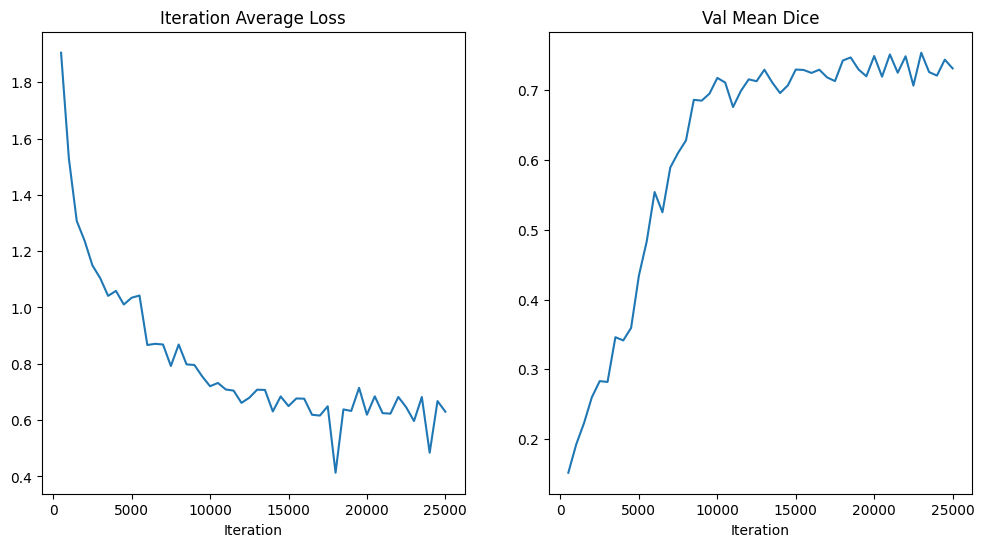

In [35]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

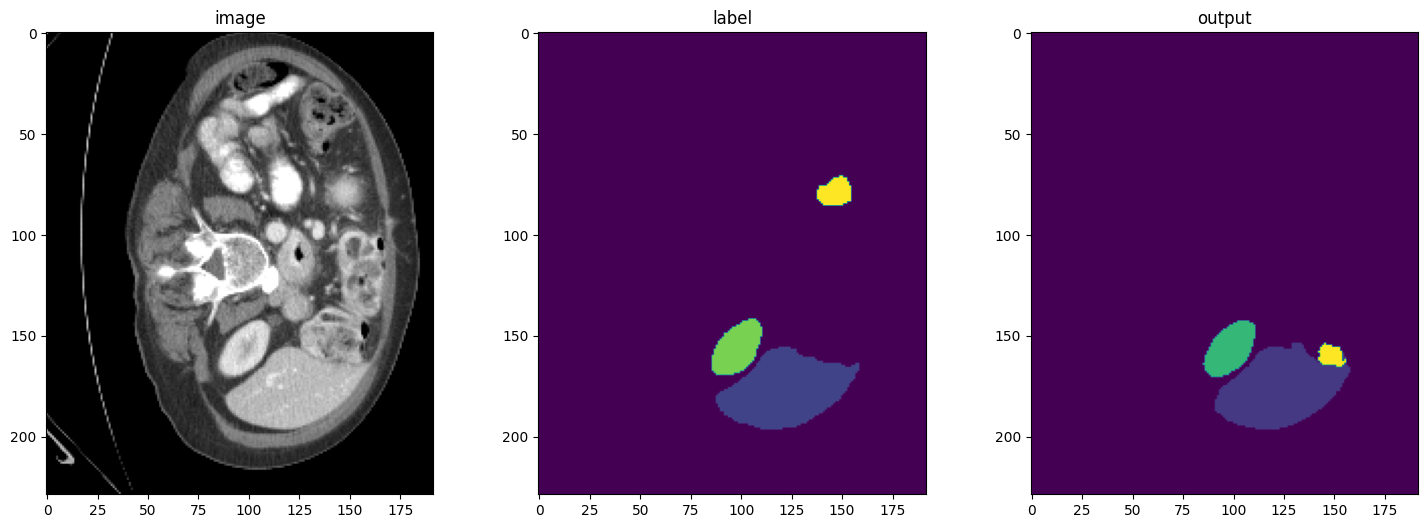

In [36]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold4_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [ ]:
#inference MMH and save

In [ ]:
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

print_config()


In [ ]:
from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")


In [ ]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

test_files = load_decathlon_datalist(datasets, True, "validation")

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/MMH_unetr_output", output_postfix="", resample=False),
    ]
)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=114, cache_rate=1.0, num_workers=4)
test_ds = CacheDataset(data=test_files, transform=test_transforms, num_workers=4)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1)

# data = transform(img_path).to(device)

In [ ]:
model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

In [ ]:
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold0_best_metric_model")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1
# with torch.no_grad():
# #     for case_num in range(0,114):
#     img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
#     img = test_ds[case_num]["image"]
#     test_inputs = torch.unsqueeze(img, 1).cuda()
#     test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), 4, model, overlap=0.8,sw_device="cuda")
#     test_outputs=torch.argmax(test_outputs, dim=1)
# #     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei/swinunetr_majei_output',output_ext=img_name)
#     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei',output_ext=img_name)
#     saver.save(test_outputs

# with torch.no_grad():
#     for test_data in test_loader:
#         test_inputs = test_data["image"].to(device)
#         test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]
#         test_output = from_engine(["pred"])(test_data)


with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)
